# Overview

In this exercise, I will be to explore the performance of a market making strategy from the data in `fills_data.parq` and `market_data.parq`. 

The strategy generated in `fills_data.parq` quotes on the bid and ask, with the goal of providing liquidity while at the same time minimizing positional risk. Note that because the strategy is market making on a spot symbol, it cannot go short. Instead, it will market make around a target inventory. 

This notebook will have the following sections:

1. Data Exploration: Understanding the data
2. Investigating the PnL: Calculating the PnL, segmenting the PnL, and using multi-linear regression on PnL to determine the factors significant to the PnL
3. Strategy Behaviour: Investigating potential trading patterns by investigation and classification models
4. Deeper Dive on Market Impact: Investigating the impact of the trading strategy on the market
5. Further Analysis: Experimenting with Markov chains and PCA analysis to gain further insights into the behaviour of the strategy

In [1]:
# Install the necessary dependencies
!pip install -q pandas
!pip install -q pyarrow
!pip install -q matplotlib
!pip install -q scipy
!pip install -q numpy
!pip install -q seaborn
!pip install scikit-learn
!pip install statsmodels


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import normaltest
from scipy.stats import pearsonr
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')  # Turn off warning messages

In [3]:
# Read the file. Please make sure the files are in the same directory as the notebook
fills_data = pd.read_parquet('fills_data.parq', engine='pyarrow')
market_data = pd.read_parquet('market_data.parq', engine='pyarrow')

## Data Exploration: Understanding the Data

This section involves investigating the data from `fills_data.parq` and `market_data.parq` and making sure that the data is clean and ready for analysis.

In [4]:
# Check how many rows and features does the fill data have
print(f"The fills data has {fills_data.shape[0]} rows and {fills_data.shape[1]} columns\n")
fills_data.head()

The fills data has 1123 rows and 12 columns



order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   

                                        fill_id    symbol     exch  balance  
timestamp                                                                    
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755  
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019  
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726  
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445  
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726

In [5]:
# Note that statistics for order_id and fill_id are not meaningful since they are identificiation numbers
fills_data.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance  
count  1.123000e+03  1123.000000  
mean   1.688934e+18     0.537670  
std    3.829630e+14     0.181855  
min    1.688172e+18     0.080200  
25%    1.688554e+18     0.400750  
50%    1.689163e+18     0.545900  
75%    1.689270e+18     0.679150  
max    1.689448e+18     0.962300

In [6]:
unique_values = fills_data.nunique()
nan_values = fills_data.isna().sum()
non_nan_counts = fills_data.count()
duplicate_values = non_nan_counts - unique_values

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'NaN Values': nan_values,
    'Duplicate Values': duplicate_values
})

summary

Unique Values  NaN Values  Duplicate Values
order_id                   1060           0                63
side                          2           0              1121
fill_prc                   1034           0                89
fill_qty                    248           0               875
liquidity                     2           0              1121
fee                          80           0              1043
fee_ccy                       1           0              1122
fee_ccy_usd_rate              8           0              1115
fill_id                    1123           0                 0
symbol                        1           0              1122
exch                          1           0              1122
balance                    1085           0                38

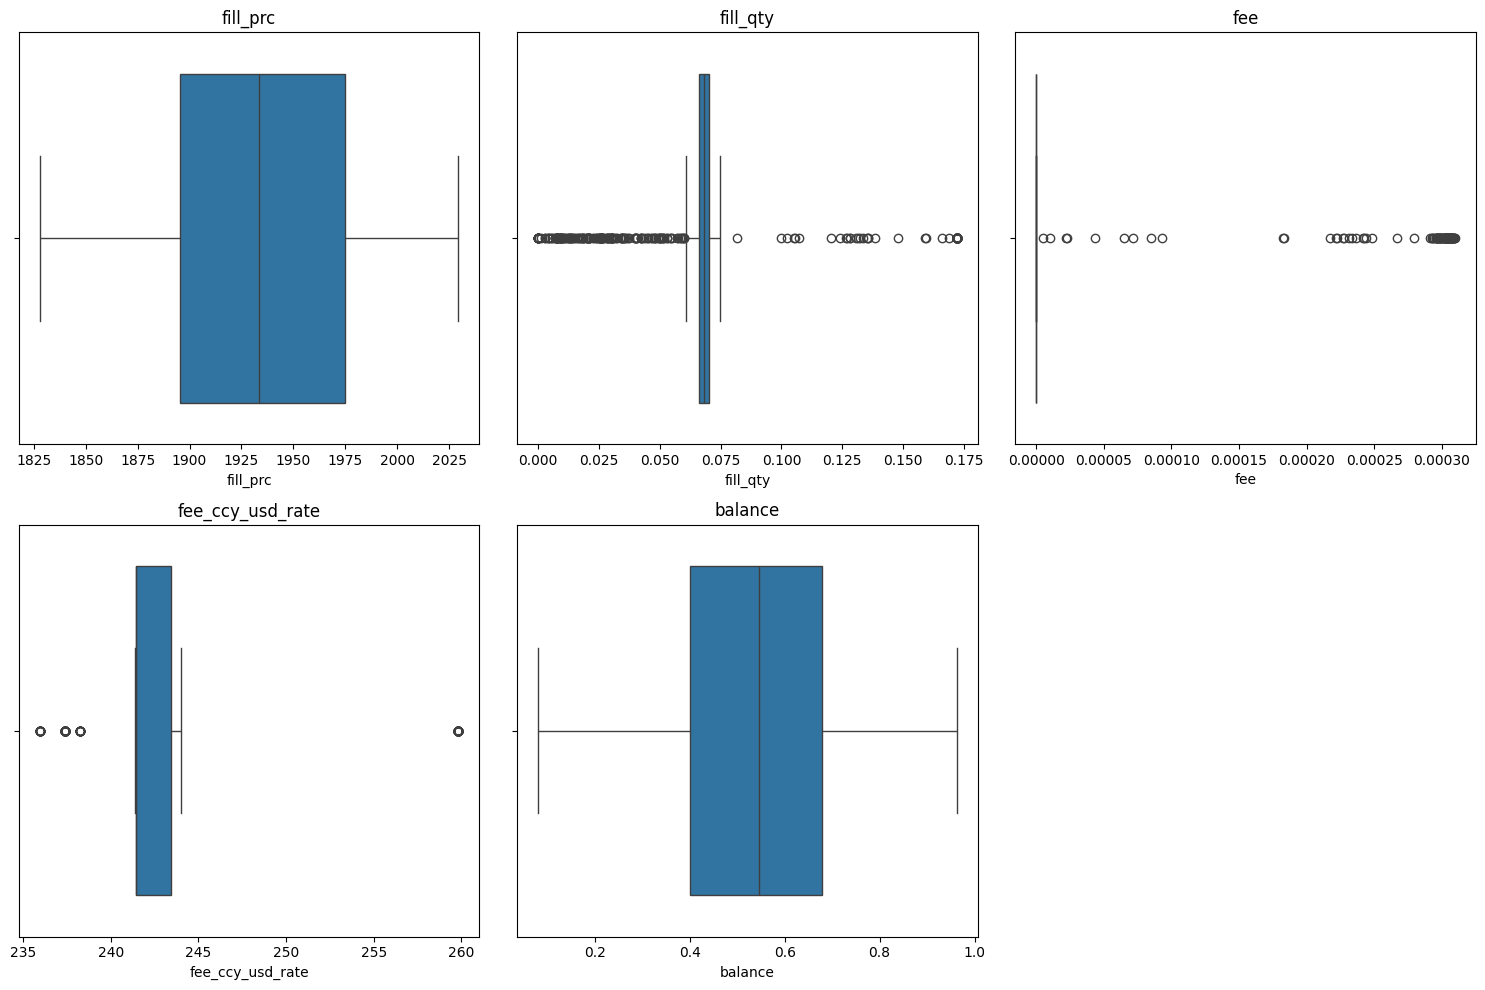

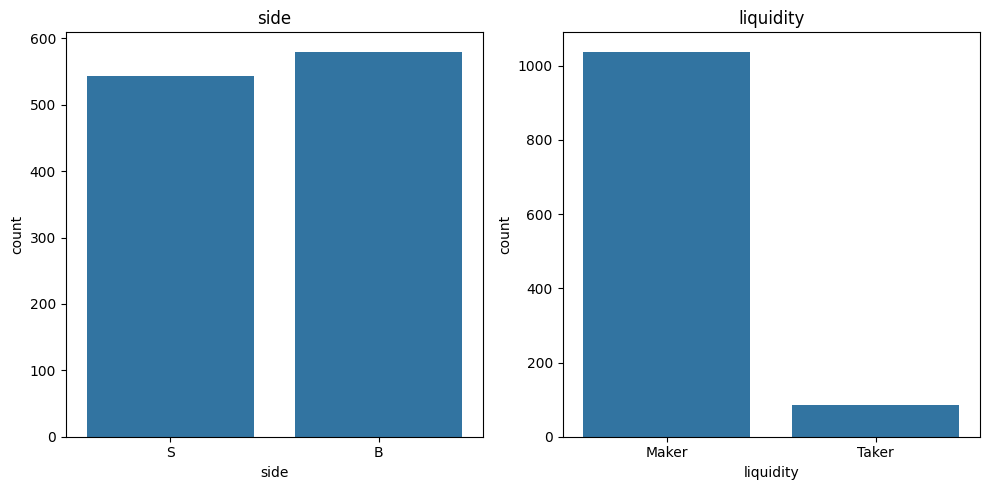

In [7]:
quantiative_features = ['fill_prc', 'fill_qty', 'fee', 'fee_ccy_usd_rate', 'balance']
categorical_features = ['side', 'liquidity']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(quantiative_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=fills_data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=fills_data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

In [8]:
def detect_outliers(data, features):
    outliers_dict = {}
    for feature in features:
        Q1 = np.percentile(data[feature], 25)
        Q3 = np.percentile(data[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outliers_feature = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step)][feature]
        outliers_dict[feature] = outliers_feature.values
        
    return outliers_dict

quantitative_outliers = detect_outliers(fills_data, quantiative_features)

for feature, values in quantitative_outliers.items():
    print(f"Outliers for {feature}: {values}\n")

Outliers for fill_prc: []

Outliers for fill_qty: [2.640e-02 1.719e-01 1.719e-01 1.268e-01 5.840e-02 1.719e-01 1.719e-01
 1.719e-01 2.140e-02 4.760e-02 1.051e-01 1.719e-01 1.700e-02 1.210e-02
 1.290e-02 5.310e-02 1.719e-01 1.719e-01 1.719e-01 2.910e-02 5.740e-02
 4.800e-02 2.040e-02 1.000e-04 1.719e-01 1.719e-01 1.400e-02 1.000e-04
 7.000e-03 2.100e-02 2.100e-02 4.780e-02 1.241e-01 1.719e-01 1.304e-01
 4.400e-03 1.719e-01 1.719e-01 1.719e-01 1.719e-01 1.719e-01 4.660e-02
 2.060e-02 1.719e-01 1.000e-04 2.300e-02 3.690e-02 1.021e-01 4.300e-03
 1.719e-01 1.719e-01 3.460e-02 9.700e-03 1.719e-01 1.719e-01 1.719e-01
 8.000e-03 8.000e-03 5.060e-02 1.780e-02 1.719e-01 1.719e-01 8.170e-02
 2.420e-02 1.477e-01 2.900e-03 2.550e-02 2.060e-02 1.719e-01 5.150e-02
 1.204e-01 3.730e-02 4.000e-03 5.190e-02 1.480e-02 1.000e-04 2.610e-02
 1.000e-04 5.900e-02 3.490e-02 1.719e-01 1.719e-01 1.719e-01 1.719e-01
 1.321e-01 3.980e-02 1.719e-01 1.267e-01 4.520e-02 1.000e-01 1.283e-01
 4.360e-02 1.056e-01 1.719e

Inspecting the results of our exploration on `fills_data`: 

1. Looking at the summary statistics of each feature, none of them raise any red flags.
2. No NaN values are present in the data.
3. While initially I thought that duplicates in `order_id` was concerning, I realised that is perfectly normal and indicate of an Iceberg. The only feature that mattered in this regard was `fill_id`, which does not have duplicates.
4. Observing our quantitative features, `fill_qty` and `fee_ccy_usd_rate` have outliers. However, thinking about the nature of the data, it seems reasonable that `fill_qty` to have outliers as they represent demand for larger or smaller orders. The same goes for `fee_ccy_usd_rate` as it represents the fee for potentially said larger/smaller transactions.

In [9]:
# Same same for market data
print(f"The fills data has {market_data.shape[0]} rows and {market_data.shape[1]} columns\n")
market_data.head()

The fills data has 1208954 rows and 3 columns



bid_prc  ask_prc            symbol
timestamp                                                           
2023-06-30 23:45:00.958000+00:00  1934.84  1934.85  binance_eth_usdt
2023-06-30 23:45:01.958000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:02.958000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:03.959000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:04.960000+00:00  1933.77  1933.78  binance_eth_usdt

In [10]:
market_data.describe()
# Looks good to me. Particularly, I see no negative values (though there have been cases of negative prices in the past, i.e oil prices during Covid pandemic or some cryptocurrency coins)
# Let's dive a bit deeper into the distribution of the data.

bid_prc       ask_prc
count  1.208954e+06  1.208954e+06
mean   1.906000e+03  1.906010e+03
std    4.195117e+01  4.195121e+01
min    1.826810e+03  1.826820e+03
25%    1.869000e+03  1.869010e+03
50%    1.895710e+03  1.895720e+03
75%    1.936760e+03  1.936770e+03
max    2.028190e+03  2.028200e+03

In [11]:
unique_values = market_data.nunique()
nan_values = market_data.isna().sum()
non_nan_counts = market_data.count()
duplicate_values = non_nan_counts - unique_values

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'NaN Values': nan_values,
    'Duplicate Values': duplicate_values
})

summary

Unique Values  NaN Values  Duplicate Values
bid_prc          17908           0           1191046
ask_prc          17913           0           1191041
symbol               1           0           1208953

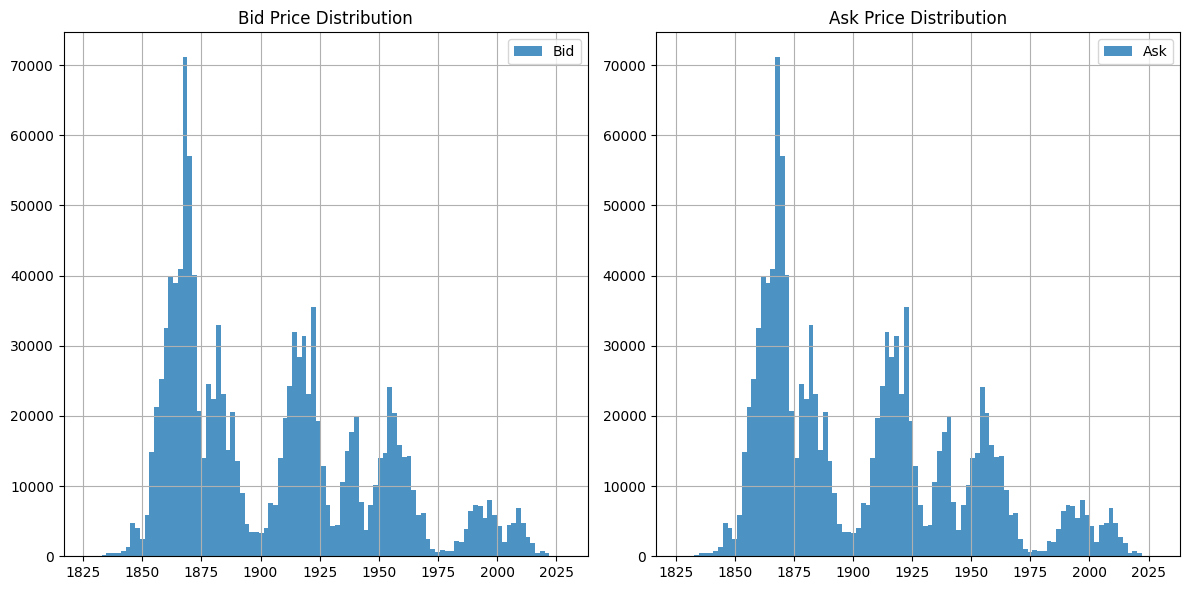

KS Statistic: 0.0009231120456196229, P-value: 0.6812398553507952


In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

market_data['bid_prc'].hist(bins=100, alpha=0.8, ax=axes[0], label='Bid')
axes[0].set_title('Bid Price Distribution')
axes[0].legend()

market_data['ask_prc'].hist(bins=100, alpha=0.8, ax=axes[1], label='Ask')
axes[1].set_title('Ask Price Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# using the Kolmogorov-Smirnov test sichecking the cumulative distribution of `bid_prc` and `ask_prc` to see if they are from the same distribution
ks_stat, ks_p_value = stats.ks_2samp(market_data['bid_prc'], market_data['ask_prc'])

print(f"KS Statistic: {ks_stat}, P-value: {ks_p_value}")


In [13]:
# Tests for normal distribution since entires > 5000
stat, p = normaltest(market_data['bid_prc'])
print('D’Agostino’s K^2 Test for bid_prc:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = normaltest(market_data['ask_prc'])
print('\nD’Agostino’s K^2 Test for ask_prc:')
print('Statistics=%.3f, p=%.3f' % (stat, p))


D’Agostino’s K^2 Test for bid_prc:
Statistics=98023.187, p=0.000

D’Agostino’s K^2 Test for ask_prc:
Statistics=98023.606, p=0.000


By plotting the distribution and using the Kolmogorov-Smirnov test, we confirm that `bid_price` and `ask_price` share the same distribution. However, the distribution is not normal. This is expected, as there can be a lot of fluctuations in the market. Furthermore, this means that I will investigate the market volatility and periods of market stress later on.

Moving forward, I will merge the `fills_data` and `market_data` datasets on the `timestamp` index. This will simplify my analysis later on.

In [14]:
# create copies so we do not modify the original data
fills_data_copy = fills_data.copy() 
market_data_copy = market_data.copy()

fills_data_copy.index = fills_data_copy.index.tz_localize(None)
market_data_copy.index = market_data_copy.index.tz_localize(None)

merged_data = pd.merge_asof(fills_data_copy.sort_index(), market_data_copy.sort_index(), left_index=True, right_index=True, direction='nearest')

assert merged_data.shape[0] == fills_data.shape[0] # assert same rows
assert merged_data.shape[1] == fills_data.shape[1] + market_data.shape[1] # assert same columns

merged_data


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x     exch  balance  \
timestamp                                                                     
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726   
...                                         ...       ...      ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  binance   0.4808   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  binance   0.6527   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  binance   0.5857   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  binance   0.5183   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  binance   0.5849   

                            bid_prc  ask_prc          symbol_y  
timestamp                                                       
2023-07-01 00:46:05.617580  1937.94  1937.95  binance_eth_usdt  
2023-07-01 06:52:59.387733  1921.73  1921.74  binance_eth_usdt  
2023-07-01 09:19:52.809436  1915.36  1915.37  binance_eth_usdt  
2023-07-01 10:16:21.048157  1917.32  1917.33  binance_eth_usdt  
2023-07-01 14:37:25.452850  1921.86  1921.87  binance_eth_usdt  
...                             ...      ...               ...  
2023-07-15 16:18:25.726018  1932.34  1932.35  binance_eth_usdt  
2023-07-15 16:19:06.461829  1932.34  1932.35  binance_eth_usdt  
2023-07-15 18:39:02.613882  1932.34  1932.35  binance_eth_usdt  
2023-07-15 18:39:02.614281  1932.34  1932.35  binance_eth_usdt  
2023-07-15 19:04:52.935896  1932.34  1932.35  binance_eth_usdt  

[1123 rows x 15 columns]

## Investigating the PnL: Calculating the PnL, segmenting the PnL, and using multi-linear regression on PnL to determine the factors significant to the PnL

In this section, I will
1. Provide a calculation for the PnL of the strategy and my reasoning behind it.
2. Segment the PnL into different buckets to better understand the performance of the strategy under different conditions.
3. Construct a multi-linear regression model to identify the features that are significant to the PnL of the strategy.

In [15]:
# Function to calculate the pnl of a trade given a row in the fills data
# We work with the assumption that `fill_prc` is in USD. 
def calculate_trade_pnl(row) -> float:
    fee_in_usd = row['fee'] * row['fee_ccy_usd_rate']
    fill_value_usd = row['fill_prc'] * row['fill_qty']
    if row['side'] == 'B':
        pnl = -fill_value_usd - fee_in_usd # buy is an expenditure
    elif row['side'] == 'S': 
        pnl = fill_value_usd - fee_in_usd # sell is an income
    return pnl

merged_data['trade_pnl'] = merged_data.apply(calculate_trade_pnl, axis=1)
merged_data.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance      bid_prc      ask_prc    trade_pnl  
count  1.123000e+03  1123.000000  1123.000000  1123.000000  1123.000000  
mean   1.688934e+18     0.537670  1934.183001  1934.244078    -0.229504  
std    3.829630e+14     0.181855    48.309006    48.299740   150.536345  
min    1.688172e+18     0.080200  1827.500000  1827.510000  -348.172338  
25%    1.688554e+18     0.400750  1895.155000  1895.190000  -132.044110  
50%    1.689163e+18     0.545900  1932.340000  1932.350000   -14.639200  
75%    1.689270e+18     0.679150  1974.270000  1974.280000   131.984646  
max    1.689448e+18     0.962300  2027.970000  2027.980000   348.024299

In [16]:
total_trade_pnl = merged_data['trade_pnl'].sum()
print(f"The total pnl for the strategy is {total_trade_pnl:.2f} USD")

# Sanity check our pnl calculation
sells = merged_data[merged_data['side'] == 'S']
buys = merged_data[merged_data['side'] == 'B']

total_sell_value = (sells['trade_pnl']).sum()
total_buy_value = (buys['trade_pnl']).sum()

average_sell_value = total_sell_value / sells.shape[0]
average_buy_value = total_buy_value / buys.shape[0]

toal_sell_count = sells.shape[0]
total_buy_count = buys.shape[0]
win_rate = (sells[sells['trade_pnl'] > 0].shape[0] / toal_sell_count) * 100
average_pnl = total_trade_pnl / merged_data.shape[0]

print(f"""
The total sell value is {total_sell_value:.2f} USD
The total buy value is {total_buy_value:.2f} USD
The average sell value is {average_sell_value:.2f} USD
The average buy value is {average_buy_value:.2f} USD
The total sell count is {toal_sell_count}
The total buy count is {total_buy_count}
Win rate: {win_rate:.2f}%
Average pnl: {average_pnl:.2f} USD
""")

# Verifying by inspecting the mean buy and sell value and number of buy and sell trades, the pnl number seem to check out.

The total pnl for the strategy is -257.73 USD

The total sell value is 75989.35 USD
The total buy value is -76247.09 USD
The average sell value is 139.94 USD
The average buy value is -131.46 USD
The total sell count is 543
The total buy count is 580
Win rate: 100.00%
Average pnl: -0.23 USD



<Axes: title={'center': 'Cumulative Trade PnL Over Time'}, xlabel='timestamp'>

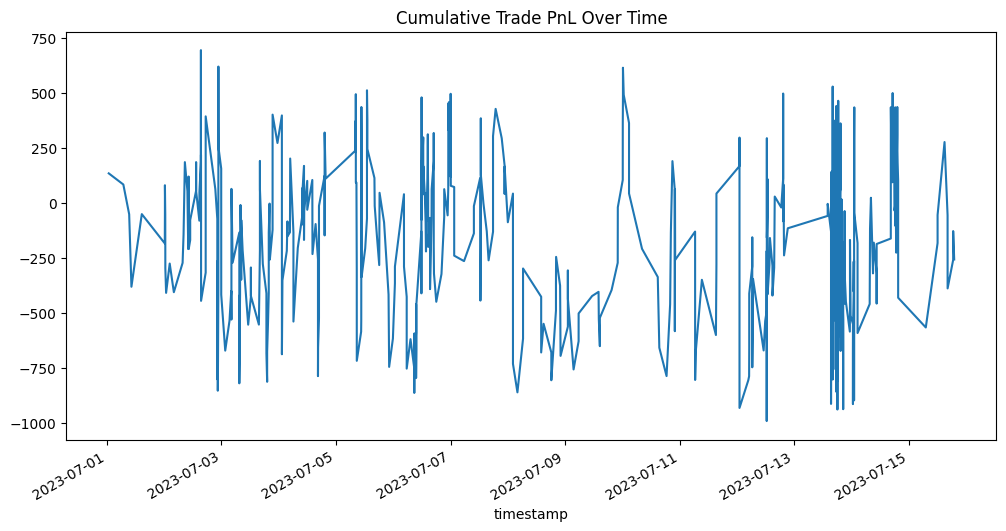

In [17]:
# We might also be interested in the cumulative pnl of the stratefy to see if there are any patterns over time
merged_data['cumulative_trade_pnl'] = merged_data['trade_pnl'].cumsum()
merged_data['cumulative_trade_pnl'].plot(figsize=(12, 6), title='Cumulative Trade PnL Over Time')

Observing this graph, there is a lot of fluctuation in the PnL. Furthermore, the cumulative PnL at the end of the trading period is negative. We need to investigate this.

Furthermore, while the PnL from trading is negative, I noticed that the strategy ended at a higher balance than it started with. With that, I will investigate the net worth of the strategy by marking to market the assets we have.

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x     exch  balance  \
timestamp                                                                     
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726   
...                                         ...       ...      ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  binance   0.4808   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  binance   0.6527   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  binance   0.5857   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  binance   0.5183   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  binance   0.5849   

                            bid_prc  ask_prc          symbol_y   trade_pnl  \
timestamp                                                                    
2023-07-01 00:46:05.617580  1937.94  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.73  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.36  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.32  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.86  1921.87  binance_eth_usdt  330.293817   
...                             ...      ...               ...         ...   
2023-07-15 16:18:25.726018  1932.34  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.34  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.34  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.34  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.34  1932.35  binance_eth_usdt -128.935602   

                            cumulative_trade_pnl  balance_value  \

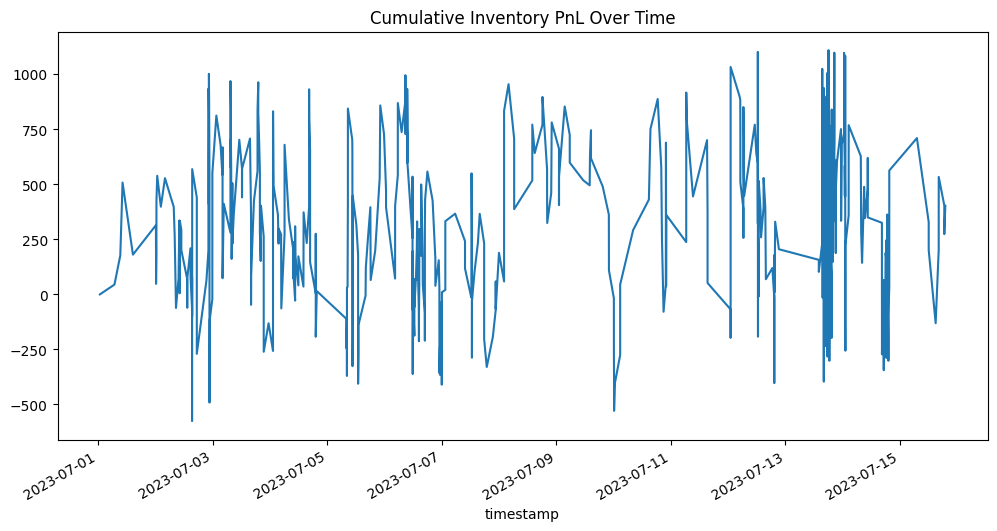

In [18]:
# I argue that we should use the bid price to calculate the market value of the balance because it represents the highest price a buyer is willing to pay for the security.
# In constract, if we were to use the ask price,the lowest price a seller is willing to accept for the security, there is no guarantee that the security will be sold at that price.
# Furthermore, if we were to use `qty_prc`, we would be using the price at which the security was bought or sold, which may not be representative of the current market sentiment.
# Ideally we would have access to closing price data, but since that is not available, I will use the bid price as what I believe is the next best alternative.
merged_data['balance_value'] = merged_data['bid_prc'] * merged_data['balance']
merged_data['inventory_pnl'] = merged_data['balance_value'].diff()
## Assume that the first row is the first day of trading and so did not own any inventory to make a profit or loss from previous days
merged_data.loc[merged_data.index[0], 'inventory_pnl'] = 0
merged_data['cumulative_inventory_pnl'] = merged_data['inventory_pnl'].cumsum()
merged_data['cumulative_inventory_pnl'].plot(figsize=(12, 6), title='Cumulative Inventory PnL Over Time')
merged_data

The inventory PnL has a lot of fluctuations, but it ends the trading period with a positive PnL. With this feature, I can calculate the net PnL of the strategy by adding the profits gained from trade and inventory PnL.

In [19]:
total_inventory_pnl = merged_data['inventory_pnl'].sum()
net_pnl = total_trade_pnl + total_inventory_pnl
print(f"The net pnl for the strategy is {net_pnl:.2f} USD")
# With this, we can also create a new feature that represents the total pnl of the strategy at any given time
merged_data['net_pnl'] = merged_data['trade_pnl'] + merged_data['inventory_pnl']
merged_data['cumulative_net_pnl'] = merged_data['cumulative_inventory_pnl'] + merged_data['cumulative_trade_pnl']
merged_data

The net pnl for the strategy is 144.80 USD


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

We calculated that the net PnL of the strategy is 144.80 USD. This is a good sign as it means that the strategy is profitable. However, I want to investigate what factors influence the PnL of the strategy. This will give me further insight into the behaviour of the strategy and the ideas behind it.

Before we continue, let me run some tests first to ensure that my calculation for the PnL is correct by asserting that it satisfies some relationships in the data that I believe make sense.

In [20]:
# Assert that the present balance value is the same as the previous balance value plus the inventory pnl
net_balance_value = merged_data['balance_value'].iloc[-1] - merged_data['balance_value'].iloc[0]
for i in range(1, len(merged_data)):
    expected_balance_value = merged_data['balance_value'].iloc[i-1] + merged_data['inventory_pnl'].iloc[i]
    expected_balance_value_rounded = round(expected_balance_value, 2)
    actual_balance_value_rounded = round(merged_data['balance_value'].iloc[i], 2)
    assert expected_balance_value_rounded == actual_balance_value_rounded, f"Mismatch at index {i}"

assert round(merged_data['cumulative_inventory_pnl'].iloc[-1], 2) == round(net_balance_value, 2), "Net PnL does not match net balance value."

In [21]:
# Assert cumulative pnl calculation is the same as cumulative sum of net pnl at any given time
calculated_cumulative_net_pnl = merged_data['net_pnl'].cumsum().round(2)
cumulative_net_pnl = merged_data['cumulative_net_pnl'].round(2)

assert (calculated_cumulative_net_pnl == cumulative_net_pnl).all(), "Mismatch in cumulative net pnl"

In [22]:
# The last assertion we can check is that the difference between the present balance value and the initial balance value plus the cumulative trade pnl is the same as the cumulative net pnl
# This is because the change in balance value already "captures" our inventory pnl as balance value is a measure of our net worth at the time
original_balance_value = merged_data['balance_value'].iloc[0]
balance_value_change = merged_data['balance_value'] - original_balance_value
assert all(round(balance_value_change + merged_data['cumulative_trade_pnl'], 2) == round(merged_data['cumulative_net_pnl'], 2)), "Assertion failed: The calculated PnL does not match the cumulative net PnL."

The trading session ends with a higher net worth than it started with. Again, this is a good sign since it indicates that the strategy is profitable. While our PnL from trading is negative, we still have unrealized gains from holding more inventory whose value outweighs the PnL from trading.

In my opinion, one key assumption behind the strategy is that the asset will continue to appreciate in value over time. It is a long-term trading strategy centered around maintaining a target inventory level. Based on this and some context provided in the problem statement, a predictions I want to call regarding the trading strategy is that it priotizes unrealized gains from holding more assets, and hedges its position by trading around a certain target inventory. A consequence of this is that the strategy is likely to make more money during a bull market than a bear market. This is something I will investigate later on.

### Segmenting the PnL 

In this section, I will bucket the PnL into different segments that may provide us with more insight into the strategy's performance.

#### Segmenting PnL by Trade PnL and Inventory PnL

Following the results from the previous cells, it seems natural that one of the first segments we should look at is the proportion of total PnL that comes from trades and inventory management. Since the PnL of a singular trade may not be so informative, I want to highlight the proportion of **cumulative PnL** that comes from trades and inventory management. To demonstrate what I mean, let me first plot the proportion of PnL coming from trading and inventory from a single trade, and then show the cumulative proportion of PnL coming from trading and inventory management.

In [23]:
# Verify that net pnl does not contain zeros
assert not (merged_data['net_pnl'] == 0).any()
df = merged_data.copy()
df['proportion_trade_pnl'] = df['trade_pnl'] / df['net_pnl']
df['proportion_inventory_pnl'] = df['inventory_pnl'] / df['net_pnl']

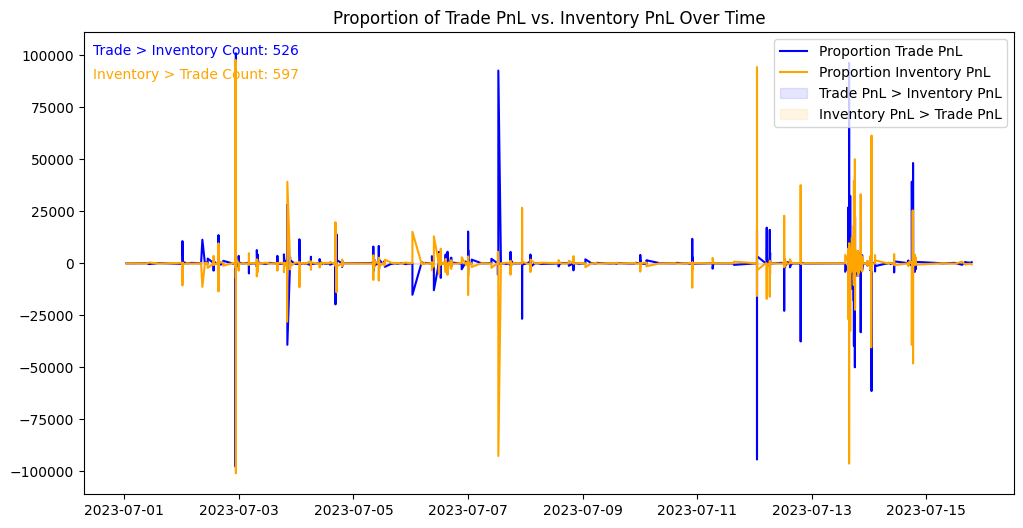

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['proportion_trade_pnl'], label='Proportion Trade PnL', color='blue')
plt.plot(df.index, df['proportion_inventory_pnl'], label='Proportion Inventory PnL', color='orange')

# Highlight periods where trade pnl is larger than inventory pnl
trade_higher = df['proportion_trade_pnl'] > df['proportion_inventory_pnl']
plt.fill_between(df.index, 0, trade_higher, color='blue', alpha=0.1, label='Trade PnL > Inventory PnL')

# Highlight periods where inventory pnl is larger than trade pnl
inventory_higher = df['proportion_trade_pnl'] < df['proportion_inventory_pnl']
plt.fill_between(df.index, 0, inventory_higher, color='orange', alpha=0.1, label='Inventory PnL > Trade PnL')

trade_higher_count = trade_higher.sum()
inventory_higher_count = inventory_higher.sum()

plt.text(0.01, 0.95, f'Trade > Inventory Count: {trade_higher_count}', transform=plt.gca().transAxes, color='blue')
plt.text(0.01, 0.90, f'Inventory > Trade Count: {inventory_higher_count}', transform=plt.gca().transAxes, color='orange')

plt.title('Proportion of Trade PnL vs. Inventory PnL Over Time')
plt.xlabel = 'Time'
plt.ylabel = 'Proportion'
plt.legend(loc='upper right',)
plt.show()

As we can see, simply plotting the proportion of `net_pnl` over `trade_pnl` and `inventory_pnl` for each transaction is not very informative. There is a lot of noise. Let's refine our analysis by looking at the proportion of cumulative PnL over time.

In [25]:
assert not (merged_data['cumulative_net_pnl'] == 0).any()
df['proportion_cumulative_trade_pnl'] = df['cumulative_trade_pnl'] / df['cumulative_net_pnl']
df['proportion_cumulative_inventory_pnl'] = df['cumulative_inventory_pnl'] / df['cumulative_net_pnl']
df.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance      bid_prc      ask_prc    trade_pnl  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000  1123.000000   
mean   1.688934e+18     0.537670  1934.183001  1934.244078    -0.229504   
std    3.829630e+14     0.181855    48.309006    48.299740   150.536345   
min    1.688172e+18     0.080200  1827.500000  1827.510000  -348.172338   
25%    1.688554e+18     0.400750  1895.155000  1895.190000  -132.044110   
50%    1.689163e+18     0.545900  1932.340000  1932.350000   -14.639200   
75%    1.689270e+18     0.679150  1974.270000  1974.280000   131.984646   
max    1.689448e+18     0.962300  2027.970000  2027.980000   348.024299   

       cumulative_trade_pnl  balance_value  inventory_pnl  \
count           1123.000000    1123.000000    1123.000000   
mean            -183.293630    1042.039456       0.358441   
std              351.663327     357.325240     150.857925   
min             -992.703029     152.459398    -352.146492   
25%             -455.292608     766.094432    -131.842933   
50%             -194.069366    1056.635700      14.634960   
75%               84.295896    1309.237288     132.358610   
max              694.057345    1837.057266     349.460637   

       cumulative_inventory_pnl      net_pnl  cumulative_net_pnl  \
count               1123.000000  1123.000000         1123.000000   
mean                 314.342986     0.128937          131.049356   
std                  357.325240     4.575246           25.942323   
min                 -575.237072   -12.966081           76.735116   
25%                   38.397962    -0.464986          106.936711   
50%                  328.939230     0.025080          131.225344   
75%                  581.540818     0.462003          153.031198   
max                 1109.360796   133.710270          185.402966   

       proportion_trade_pnl  proportion_inventory_pnl  \
count           1123.000000               1123.000000   
mean              81.223476                -80.223476   
std             8407.701774               8407.701774   
min           -97701.500029            -100912.635012   
25%             -228.229837               -462.850856   
50%              -21.325938                 22.325938   
75%              463.850856                229.229837   
max           100913.635012              97702.500029   

       proportion_cumulative_trade_pnl  proportion_cumulative_inventory_pnl  
count                      1123.000000                          1123.000000  
mean                         -1.356097                             2.356097  
std                           2.892579                             2.892579  
min                          -9.354586                            -6.200503  
25%                          -3.472661                             0.315097  
50%                          -1.427146                             2.427146  
75%                           0.684903                             4.472661  
max                           7.200503                            10.354586

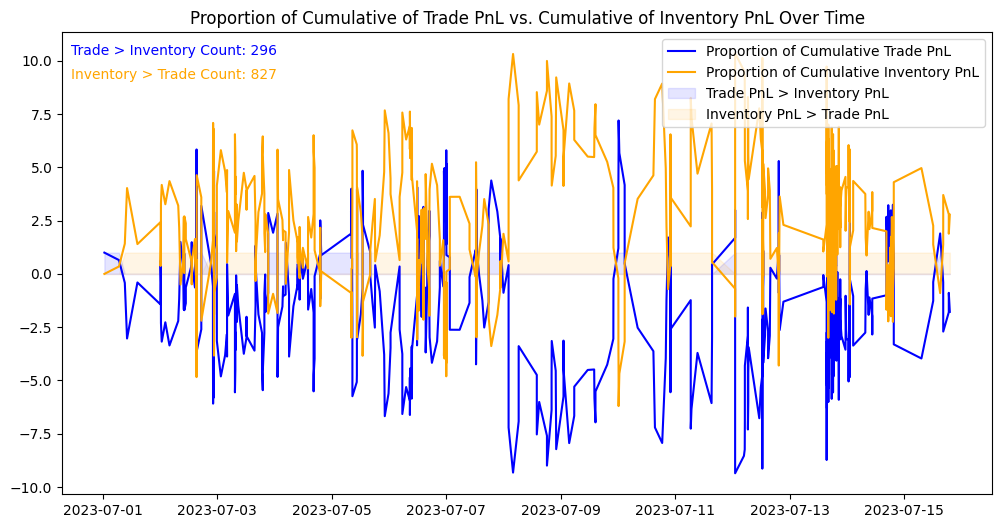

In [26]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['proportion_cumulative_trade_pnl'], label='Proportion of Cumulative Trade PnL', color='blue')
plt.plot(df.index, df['proportion_cumulative_inventory_pnl'], label='Proportion of Cumulative Inventory PnL', color='orange')

# Highlight periods where trade pnl is larger than inventory pnl
trade_higher = df['proportion_cumulative_trade_pnl'] > df['proportion_cumulative_inventory_pnl']
plt.fill_between(df.index, 0, trade_higher, color='blue', alpha=0.1, label='Trade PnL > Inventory PnL')

# Highlight periods where inventory pnl is larger than trade pnl
inventory_higher = df['proportion_cumulative_trade_pnl'] < df['proportion_cumulative_inventory_pnl']
plt.fill_between(df.index, 0, inventory_higher, color='orange', alpha=0.1, label='Inventory PnL > Trade PnL')

trade_higher_count = trade_higher.sum()
inventory_higher_count = inventory_higher.sum()

plt.text(0.01, 0.95, f'Trade > Inventory Count: {trade_higher_count}', transform=plt.gca().transAxes, color='blue')
plt.text(0.01, 0.90, f'Inventory > Trade Count: {inventory_higher_count}', transform=plt.gca().transAxes, color='orange')

plt.title('Proportion of Cumulative of Trade PnL vs. Cumulative of Inventory PnL Over Time')
plt.xlabel = 'Time'
plt.ylabel = 'Proportion'
plt.legend(loc='upper right',)
plt.show()

In [27]:
# Finding when the trade pnl is larger than the inventory pnl
trade_higher_periods = df[trade_higher]
# There seems to be a pattern where trade pnl is larger than inventory pnl for a short period of time, and then followed by a much longer period of inventory pnl being larger than trade pnl.
# The ratio seems to be that inventory pnl is larger than trade pnl for about 73.64% of the time.
# What is interesting to explore later on is if this ratio converges to a certain value over time, and if so, what is that proportion?

print(f"The proportion of time where trade pnl is larger than inventory pnl is {trade_higher_count / df.shape[0]:.2%}")
print(f"The proportion of time where inventory pnl is larger than trade pnl is {inventory_higher_count / df.shape[0]:.2%}")
trade_higher_periods

The proportion of time where trade pnl is larger than inventory pnl is 26.36%
The proportion of time where inventory pnl is larger than trade pnl is 73.64%


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-02 00:18:38.297309  670003026944574    S   1919.58    0.0679   
2023-07-02 08:40:07.007292  670003026946968    S   1913.56    0.1719   
2023-07-02 10:13:45.795938  670003026947317    S   1917.62    0.1719   
...                                     ...  ...       ...       ...   
2023-07-14 19:13:42.475528  670008617124529    S   1918.36    0.0656   
2023-07-14 19:13:46.010801  670008617124591    B   1921.50    0.0699   
2023-07-14 19:13:59.996069  670008617124626    B   1923.39    0.0341   
2023-07-14 19:35:34.092633  670008617124966    B   1919.23    0.0708   
2023-07-15 15:01:52.361156  670008617129403    S   1930.18    0.1719   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-02 00:18:38.297309     Maker  0.000000     bnb        237.395823   
2023-07-02 08:40:07.007292     Taker  0.000301     bnb        237.395823   
2023-07-02 10:13:45.795938     Taker  0.000302     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-14 19:13:42.475528     Maker  0.000000     bnb        259.829225   
2023-07-14 19:13:46.010801     Maker  0.000000     bnb        259.829225   
2023-07-14 19:13:59.996069     Maker  0.000000     bnb        259.829225   
2023-07-14 19:35:34.092633     Maker  0.000000     bnb        259.829225   
2023-07-15 15:01:52.361156     Taker  0.000298     bnb        259.829225   

                                        fill_id  symbol_x  ...  \
timestamp                                                  ...   
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...   
2023-07-02 00:18:38.297309  1688257118287000000  eth_usdc  ...   
2023-07-02 08:40:07.007292  1688287207003000000  eth_usdc  ...   
2023-07-02 10:13:45.795938  1688292825737000000  eth_usdc  ...   
...                                         ...       ...  ...   
2023-07-14 19:13:42.475528  1689362022386000001  eth_usdc  ...   
2023-07-14 19:13:46.010801  1689362026008000000  eth_usdc  ...   
2023-07-14 19:13:59.996069  1689362039993000000  eth_usdc  ...   
2023-07-14 19:35:34.092633  1689363334015000000  eth_usdc  ...   
2023-07-15 15:01:52.361156  1689433312356000000  eth_usdc  ...   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.000000   
2023-07-01 06:52:59.387733            83.008278     772.343287      44.646817   
2023-07-02 00:18:38.297309            79.660017     775.629540    -130.327260   
2023-07-02 08:40:07.007292           184.776967     666.117198    -328.840402   
2023-07-02 10:13:45.795938           119.285148     732.910542    -330.357489   
...                                         ...            ...            ...   
2023-07-14 19:13:42.475528           435.424700     426.361804    -125.874592   
2023-07-14 19:13:46.010801           301.111850     561.065680     134.703876   
2023-07-14 19:13:59.996069           235.524251     627.152120      66.086440   
2023-07-14 19:35:34.092633            99.642767     761.835060     134.682940   
2023-07-15 15:01:52.361156           276.136560     596.899826    -332.169246   

                            cumulative_inventory_pnl     net_pnl  \
timestamp                                                          
2023-07-01 00:46:05.617580                  0.000000  133.71

Looking at the graph, I noticed that the direction of `trade_pnl` and `inventory_pnl` are often times inverse to each other, This suggest that the strtagy does indeed hedge its risk by balancing the PnL from trades with the PnL from inventory management. 

#### Segmenting PnL by Market Conditions

Since I made the assumption that the strategy is long-term and may not be too concerned with short-term fluctuations in the market, I will investigate the impact of market conditions on the PnL. To accomplish this, I will need to engineer a new categorical that capture the market condition on whether the asset is bull, bear, or neutral. 

In [28]:
df = merged_data.copy()
df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

In [29]:
# The feature `mid_prc` is a new feature which is the average between `bid_prc` and `ask_prc`.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

bull_threshold = 0.0005
bear_threshold = -0.0005

def categorize_market_condition(row):
  if row['mid_prc_pct_change'] > bull_threshold:
    return 'Bull'
  elif row['mid_prc_pct_change'] < bear_threshold:
    return 'Bear'
  else:
    return 'Neutral'
  
df['market_condition'] = df.apply(categorize_market_condition, axis=1)
df['market_condition'].value_counts()

market_condition
Neutral    582
Bear       276
Bull       265
Name: count, dtype: int64

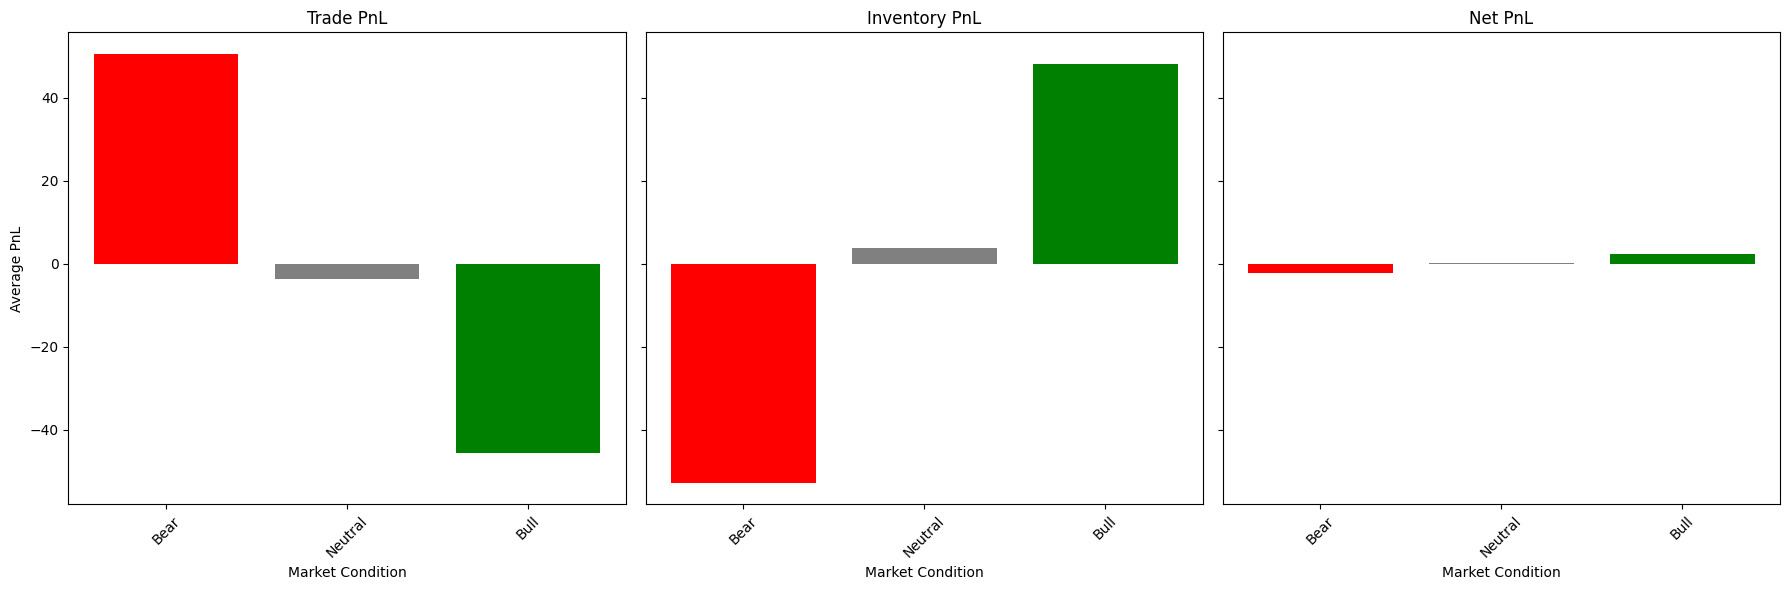

In [30]:
df['market_condition'] = pd.Categorical(df['market_condition'], categories=['Bear', 'Neutral', 'Bull'], ordered=True)
avg_pnls_by_condition = df.groupby('market_condition', observed=True)[['trade_pnl', 'inventory_pnl', 'net_pnl']].mean().reindex(['Bear', 'Neutral', 'Bull'])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
titles = ['Trade PnL', 'Inventory PnL', 'Net PnL']
market_conditions = avg_pnls_by_condition.index
x = range(len(market_conditions))

for i, pnl_type in enumerate(['trade_pnl', 'inventory_pnl', 'net_pnl']):
    axs[i].bar(x, avg_pnls_by_condition[pnl_type], color=['red', 'gray', 'green'])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Market Condition')
    axs[i].set_ylabel('Average PnL' if i == 0 else '')
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(market_conditions, rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# A helper function because I will be using this a lot
def interpret_p_value(p_value, message, alpha=0.05):
    if p_value < alpha:
        print(f"There is a statistical significance in {message} (p-value: {p_value:.3f})")
    else:
        print(f"There is no statistical significance in {message} (p-value: {p_value:.3f})")

In [32]:
# I will use the Kruskal-Wallis test to check if there is a statistically significant difference in the average trade pnl, inventory pnl, and net pnl across market conditions.
# I am using this test because pnl does not have a normal distribution and the Kruskal-Wallis test is a non-parametric test that does not assume normality.
for pnl_type in ['trade_pnl', 'inventory_pnl', 'net_pnl']:
    groups = [group[pnl_type].dropna() for name, group in df.groupby('market_condition')]
    stat, p_value = stats.kruskal(*groups)
    print(f"{pnl_type} Kruskal-Wallis test: H={stat:.3f}, p={p_value:.5f}")
    interpret_p_value(p_value, f"average {pnl_type} across market conditions")

trade_pnl Kruskal-Wallis test: H=35.633, p=0.00000
There is a statistical significance in average trade_pnl across market conditions (p-value: 0.000)
inventory_pnl Kruskal-Wallis test: H=75.011, p=0.00000
There is a statistical significance in average inventory_pnl across market conditions (p-value: 0.000)
net_pnl Kruskal-Wallis test: H=918.543, p=0.00000
There is a statistical significance in average net_pnl across market conditions (p-value: 0.000)


In [33]:
# Values from net pnl
print("Average Net PnL by Market Condition")
print(avg_pnls_by_condition['net_pnl'])

Average Net PnL by Market Condition
market_condition
Bear      -2.265329
Neutral    0.266084
Bull       2.321384
Name: net_pnl, dtype: float64


From the plots above, we identified that `trade_pnl` is more profitable during a bear market, while `inventory_pnl` is more profitable during a bull market. This tells me that the strategy emphasizes `trade_pnl` during bear markets, quickly turning over inventory to avoid holding declining assets.. Furthermore, during a bull market, the profitability of `inventory_pnl` outweighs the losses from `trade_pnl`. However, during a bear market, the losses from `inventory_pnl` outweigh the gains from `trade_pnl`. 

The effect of the inverse direction of `trade_pnl` and `inventory_pnl` is to hedge against risk in all market directions. Note that the `net_pnl` is positive and has a small magnitude during neutral and bull markets, but negative and small in magnitude during bear markets. In evaluating this strategy, I believe that it is good that the strategy hedges against risk during a bear market, losing much less than it could have. My concern is that the gains during a neutral market may be too little when inflation is put into consideration. One other limitation I want to mention is that the majority of our profits is concentrated in unrealized gains from holding more assets and not cash. In a more broader context, it increases our exposure to the market and we run the risk of not being able to sell our assets during a market crash, which is a real concern for crypto assets.

In summary, for the trader with a lower risk appetite and wishes to make incremental gains over time, this is a good strategy. However, the trader should be weary of the potential risk of holding too much assets during a market crash especially since we are trading crypto assets, and the risk of inflation eroding the value of our assets during a neutral market.

#### Segmenting PnL by Volatility

Like I mentioned before, I want to investigate the impact of market volatility on the PnL of the strategy. I will calculate the volatility of the market and then plot the PnL against the volatility.

In [34]:
# Check how many transactions happen per day 
df = merged_data.copy()
df['date'] = df.index.date

transactions_per_day = df.groupby('date').size()
transactions_per_day

date
2023-07-01      5
2023-07-02    119
2023-07-03     61
2023-07-04     56
2023-07-05     61
2023-07-06     82
2023-07-07     66
2023-07-08     19
2023-07-09     16
2023-07-10     33
2023-07-11     12
2023-07-12     96
2023-07-13    383
2023-07-14    104
2023-07-15     10
dtype: int64

Since the trading strategy makes several transactions in a day, we can take advantage of this and aggregate same transactions in a day to calculate the daily volatility.

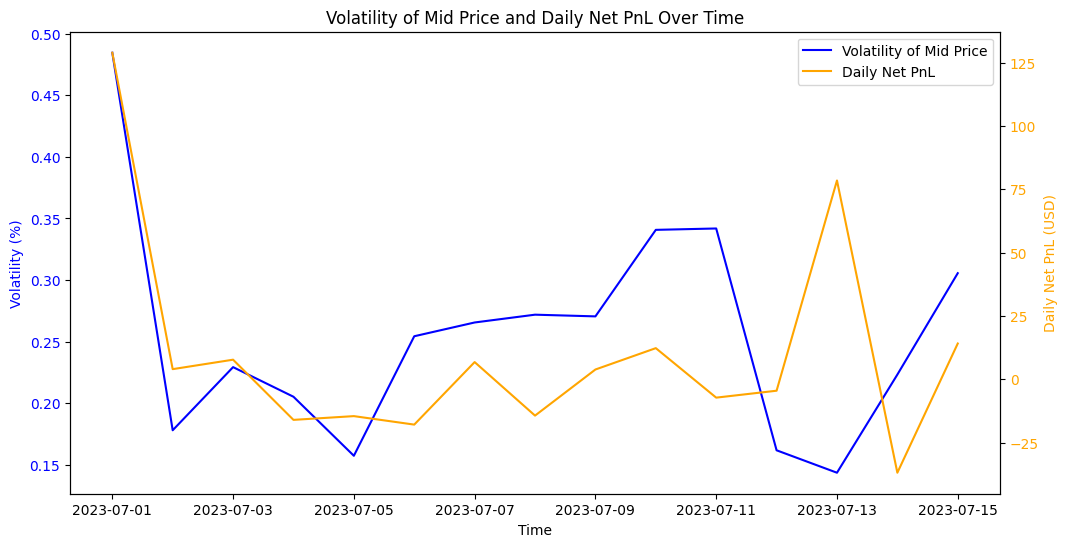

In [35]:
df.sort_index(inplace=True)

# Using `mid_prc` to calculate the volatility of the Mid Price.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
# The reason I am using `mid_prc` instead of the `mid_prc` is because `fill_pcr` data reflects the prices of buys and sells, so it is difficult to obtain a gauge the average trading volatility from this data.
mid_prc_daily_volatility = df.groupby('date')['mid_prc_pct_change'].std() * 100
daily_net_pnl = df.groupby('date')['net_pnl'].sum()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(mid_prc_daily_volatility.index, mid_prc_daily_volatility, label="Volatility of Mid Price", color='blue')
ax1.set_ylabel('Volatility (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel("Time")
plt.title("Volatility of Mid Price and Daily Net PnL Over Time")

ax2 = ax1.twinx()
ax2.plot(daily_net_pnl.index, daily_net_pnl, label="Daily Net PnL", color='orange')
ax2.set_ylabel('Daily Net PnL (USD)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

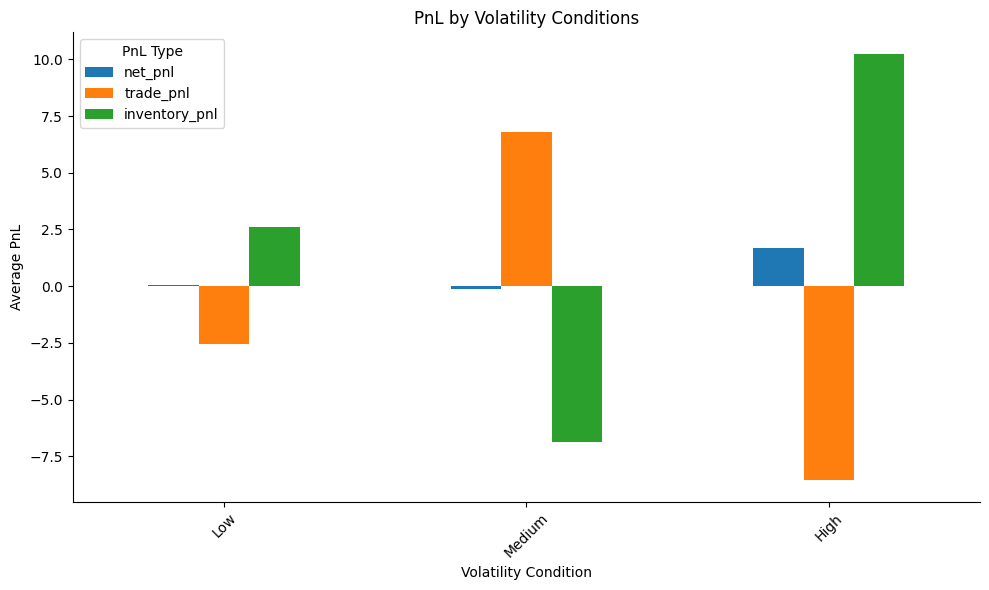

                      net_pnl  trade_pnl  inventory_pnl
volatility_category                                    
Low                  0.066319  -2.533121       2.599440
Medium              -0.110621   6.776228      -6.886849
High                 1.693333  -8.556075      10.249408


In [36]:
volatility_bins = pd.qcut(mid_prc_daily_volatility, q=3, labels=['Low', 'Medium', 'High'])
df['volatility_category'] = df['date'].map(volatility_bins)

pnl_by_volatility = df.groupby('volatility_category')[['net_pnl', 'trade_pnl', 'inventory_pnl']].mean()

fig, ax = plt.subplots(figsize=(10, 6))
pnl_by_volatility.plot(kind='bar', ax=ax)

ax.set_title('PnL by Volatility Conditions')
ax.set_xlabel('Volatility Condition')
ax.set_ylabel('Average PnL')
ax.set_xticklabels(pnl_by_volatility.index, rotation=45)

ax.legend(title='PnL Type')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(pnl_by_volatility)

Inspecting the figure, we can observe that the `daily_net_pnl` generally follows the same trend as `mid_prc` volatility except in the periods between 2023-07-12 - 2023-07-14. During this time period, volatility falls very low but the `daily_net_pnl` increases. This is something I will investigate later on. But first, let us plot a scatterplot of volatility against `net_pnl`, `daily_trade_pnl` and `daily_inventory_pnl` to see the full picture.

Furthermore, the second plot shows the behaviour of `net_pnl`, `trade_pnl`, and `inventory_pnl` against `mid_prc` daily volatility in three categories: low, medium, high. With this, we can observe two patterns: The first is that `net_pnl` is positive and increasing as we transition from low, medium, to high volatility. This suggests that the strategy is profitable during any market volatility since. The more interesting pattern is the second pattern, which shows that the PnL for `trade_pnl` and `inventory_pnl` are in the inverse direction to each other in all three categories. This suggests that the strategy hedges against risk in all volatility conditions. This aligns with the finding in the previous section where we observed that the strategy hedges against risk in bear, bull, and neutral markets.

In calculating volatility, I have the choice of either using `fill_prc` or `mid_prc`. Here, I believe using `mid_prc` is more representative in investigating trading volatility because the data in `fill_prc` flips between buys and sells, making it more difficult to gain an good gauge of the market volatility.

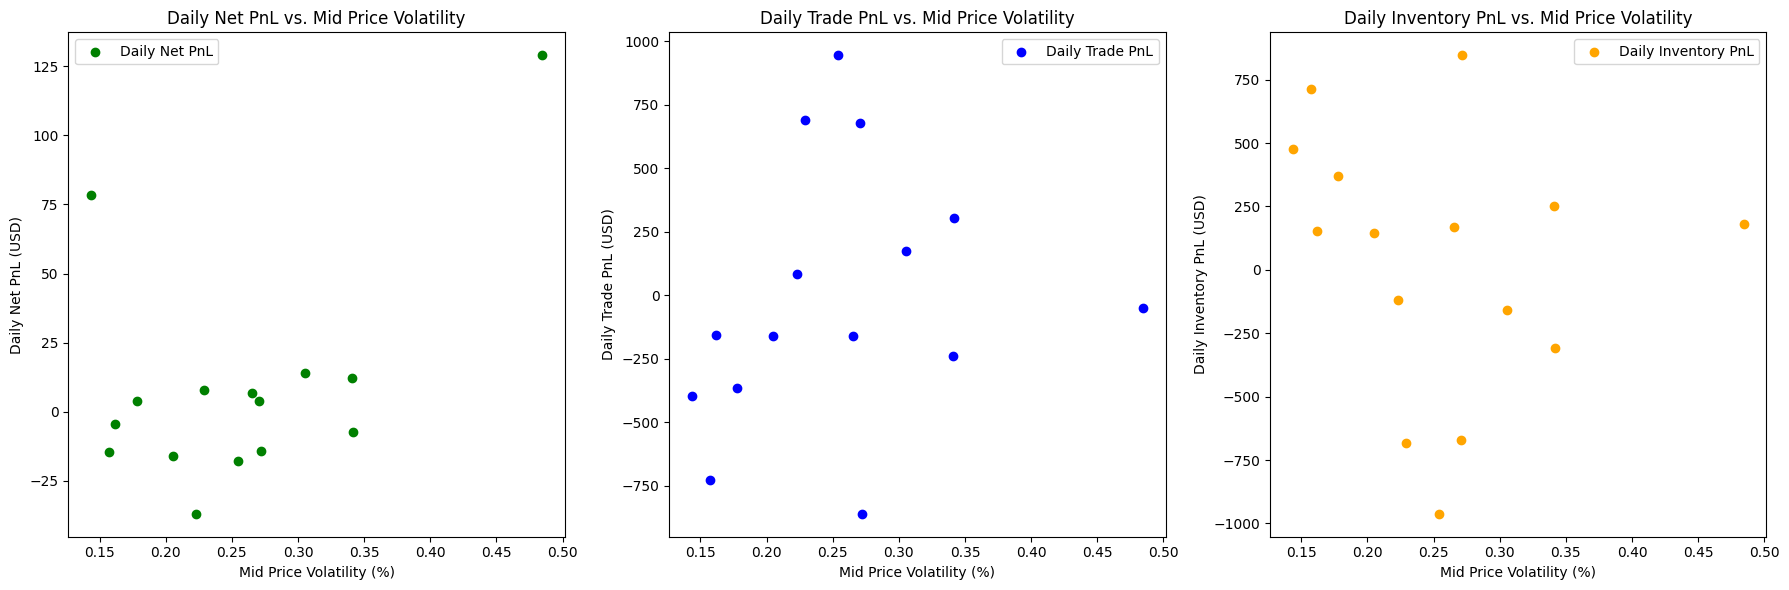

In [37]:
# Aggregate pnl data by date so we can plot the pnl against volatility
daily_trade_pnl = df.groupby('date')['trade_pnl'].sum()
daily_inventory_pnl = df.groupby('date')['inventory_pnl'].sum()
plot_data = pd.DataFrame({
    'Mid Price Volatility': mid_prc_daily_volatility,
    'Daily Net PnL': daily_net_pnl,
    'Daily Trade PnL': daily_trade_pnl,
    'Daily Inventory PnL': daily_inventory_pnl
}).dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Mid Price Volatility
axs[0].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Net PnL'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Mid Price Volatility')
axs[0].set_xlabel('Mid Price Volatility (%)')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Mid Price Volatility
axs[1].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Trade PnL'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Mid Price Volatility')
axs[1].set_xlabel('Mid Price Volatility (%)')
axs[1].set_ylabel('Daily Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Mid Price Volatility
axs[2].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Inventory PnL'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Mid Price Volatility')
axs[2].set_xlabel('Mid Price Volatility (%)')
axs[2].set_ylabel('Daily Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

In [38]:
corr_volatility_net_pnl, p_value_net_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Net PnL'])
print(f"Correlation between Volatility and Net PnL: {corr_volatility_net_pnl}, P-value: {p_value_net_pnl}")
interpret_p_value(p_value_net_pnl, "correlation between volatility and net pnl")

corr_volatility_trade_pnl, p_value_trade_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Trade PnL'])
print(f"Correlation between Volatility and Trade PnL: {corr_volatility_trade_pnl}, P-value: {p_value_trade_pnl}")
interpret_p_value(p_value_trade_pnl, "correlation between volatility and trade pnl")

corr_volatility_inventory_pnl, p_value_inventory_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Inventory PnL'])
print(f"Correlation between Volatility and Inventory PnL: {corr_volatility_inventory_pnl}, P-value: {p_value_inventory_pnl}")
interpret_p_value(p_value_inventory_pnl, "correlation between volatility and inventory pnl")

Correlation between Volatility and Net PnL: 0.4823970501428044, P-value: 0.06858227450991461
There is no statistical significance in correlation between volatility and net pnl (p-value: 0.069)
Correlation between Volatility and Trade PnL: 0.2232965414989115, P-value: 0.4237251947813019
There is no statistical significance in correlation between volatility and trade pnl (p-value: 0.424)
Correlation between Volatility and Inventory PnL: -0.1820071416866053, P-value: 0.5161998590433359
There is no statistical significance in correlation between volatility and inventory pnl (p-value: 0.516)


Observing the scatterplots, we can see that the volatility of `mid_prc` is not correlated with `net_pnl`, `daily_trade_pnl` and `daily_inventory_pnl`. We verified this using a Spearman correlation. This is an important result as it tells us that the PnL of our strategy is not affected by volatility. This is good because it means that the PnL of the strategy shows characteristics of genuine alpha.

#### Segmenting PnL by Market Stress Periods (Trading Volume)

Next, I want to identify if market stress, or trading volume, has an impact on the PnL of the strategy. I will aggregate the volume of trades transacted in a day by aggregating `fill_qty` and then plotting the PnL against the volume.

In [39]:
# Calculate daily volume
df = merged_data.copy()
df['date'] = df.index.date
trading_volume = df.groupby('date')['fill_qty'].sum()
trading_volume

date
2023-07-01     0.5099
2023-07-02     8.6067
2023-07-03     4.5653
2023-07-04     4.1824
2023-07-05     4.3114
2023-07-06     6.2745
2023-07-07     3.7855
2023-07-08     1.9526
2023-07-09     1.1085
2023-07-10     2.6732
2023-07-11     1.1461
2023-07-12     6.9174
2023-07-13    24.4383
2023-07-14     7.2115
2023-07-15     1.0497
Name: fill_qty, dtype: float64

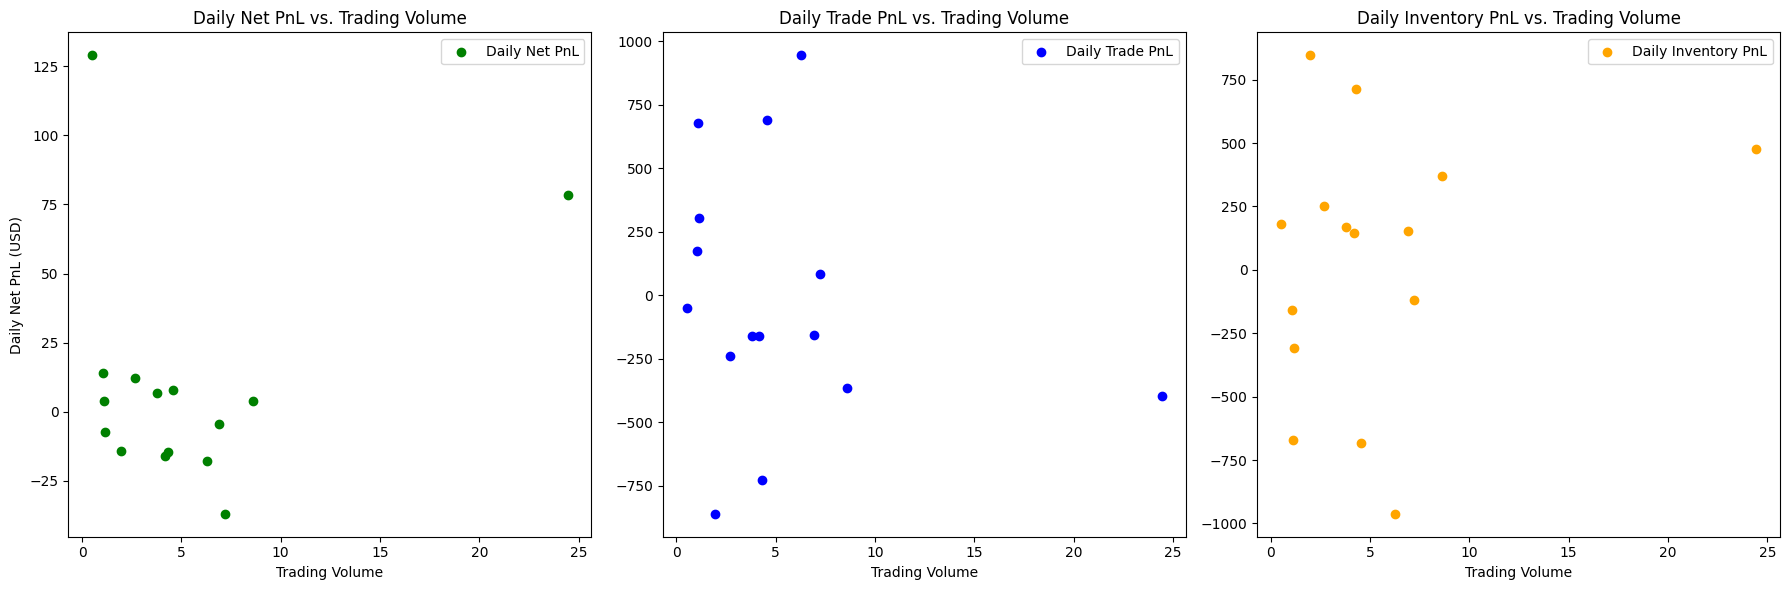

In [40]:
plot_data = pd.DataFrame({
    'Trading Volume': trading_volume,
    'Daily Net PnL': daily_net_pnl,
    'Daily Trade PnL': daily_trade_pnl,
    'Daily Inventory PnL': daily_inventory_pnl
}).dropna() # Ensuring clean plotting data


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Trading Volume
axs[0].scatter(plot_data['Trading Volume'], plot_data['Daily Net PnL'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Trading Volume')
axs[0].set_xlabel('Trading Volume')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Trading Volume
axs[1].scatter(plot_data['Trading Volume'], plot_data['Daily Trade PnL'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Trading Volume')
axs[1].set_xlabel('Trading Volume')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Trading Volume
axs[2].scatter(plot_data['Trading Volume'], plot_data['Daily Inventory PnL'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Trading Volume')
axs[2].set_xlabel('Trading Volume')
axs[2].legend()

fig.tight_layout()
plt.show()


In [41]:
corr_volume_net_pnl, p_value_volume_net_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Net PnL'])
print(f"Correlation between Trading Volume and Net PnL: {corr_volume_net_pnl}, P-value: {p_value_volume_net_pnl}")
interpret_p_value(p_value_volume_net_pnl, "correlation between trading volume and net pnl")

corr_volume_trade_pnl, p_value_volume_trade_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Trade PnL'])
print(f"Correlation between Trading Volume and Trade PnL: {corr_volume_trade_pnl}, P-value: {p_value_volume_trade_pnl}")
interpret_p_value(p_value_volume_trade_pnl, "correlation between trading volume and trade pnl")

corr_volume_inventory_pnl, p_value_volume_inventory_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Inventory PnL'])
print(f"Correlation between Trading Volume and Inventory PnL: {corr_volume_inventory_pnl}, P-value: {p_value_volume_inventory_pnl}")
interpret_p_value(p_value_volume_inventory_pnl, "correlation between trading volume and inventory pnl")

Correlation between Trading Volume and Net PnL: 0.23221069228018756, P-value: 0.4049575970726101
There is no statistical significance in correlation between trading volume and net pnl (p-value: 0.405)
Correlation between Trading Volume and Trade PnL: -0.20094110793006886, P-value: 0.47269447984944774
There is no statistical significance in correlation between trading volume and trade pnl (p-value: 0.473)
Correlation between Trading Volume and Inventory PnL: 0.2176161935432314, P-value: 0.43591324305288714
There is no statistical significance in correlation between trading volume and inventory pnl (p-value: 0.436)


Likewise, there is no correlation between trading volume and `net_pnl`, `daily_trade_pnl` and `daily_inventory_pnl`. This is a good sign as it means that the strategy is robust and can handle market stress

#### Segmenting PnL by Liquidity (Spread)

Another interesting point to consider is the impact of liquidity on the PnL of the strategy. Formulating the question more formally, does the spread between the bid and ask price have an impact on the PnL of the strategy? I will calculate the spread and then plot the PnL against the spread. I want to consider the behavior of the strategy in different liquidity conditions.

In [42]:
df = merged_data.copy()
df['spread'] = df['ask_prc'] - df['bid_prc']
df.describe() # Checking the spread column, we do not have negative values, which verifies that my calculation is correct.

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance      bid_prc      ask_prc    trade_pnl  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000  1123.000000   
mean   1.688934e+18     0.537670  1934.183001  1934.244078    -0.229504   
std    3.829630e+14     0.181855    48.309006    48.299740   150.536345   
min    1.688172e+18     0.080200  1827.500000  1827.510000  -348.172338   
25%    1.688554e+18     0.400750  1895.155000  1895.190000  -132.044110   
50%    1.689163e+18     0.545900  1932.340000  1932.350000   -14.639200   
75%    1.689270e+18     0.679150  1974.270000  1974.280000   131.984646   
max    1.689448e+18     0.962300  2027.970000  2027.980000   348.024299   

       cumulative_trade_pnl  balance_value  inventory_pnl  \
count           1123.000000    1123.000000    1123.000000   
mean            -183.293630    1042.039456       0.358441   
std              351.663327     357.325240     150.857925   
min             -992.703029     152.459398    -352.146492   
25%             -455.292608     766.094432    -131.842933   
50%             -194.069366    1056.635700      14.634960   
75%               84.295896    1309.237288     132.358610   
max              694.057345    1837.057266     349.460637   

       cumulative_inventory_pnl      net_pnl  cumulative_net_pnl       spread  
count               1123.000000  1123.000000         1123.000000  1123.000000  
mean                 314.342986     0.128937          131.049356     0.061077  
std                  357.325240     4.575246           25.942323     0.221057  
min                 -575.237072   -12.966081           76.735116     0.010000  
25%                   38.397962    -0.464986          106.936711     0.010000  
50%                  328.939230     0.025080          131.225344     0.010000  
75%                  581.540818     0.462003          153.031198     0.010000  
max                 1109.360796   133.710270          185.402966     2.840000

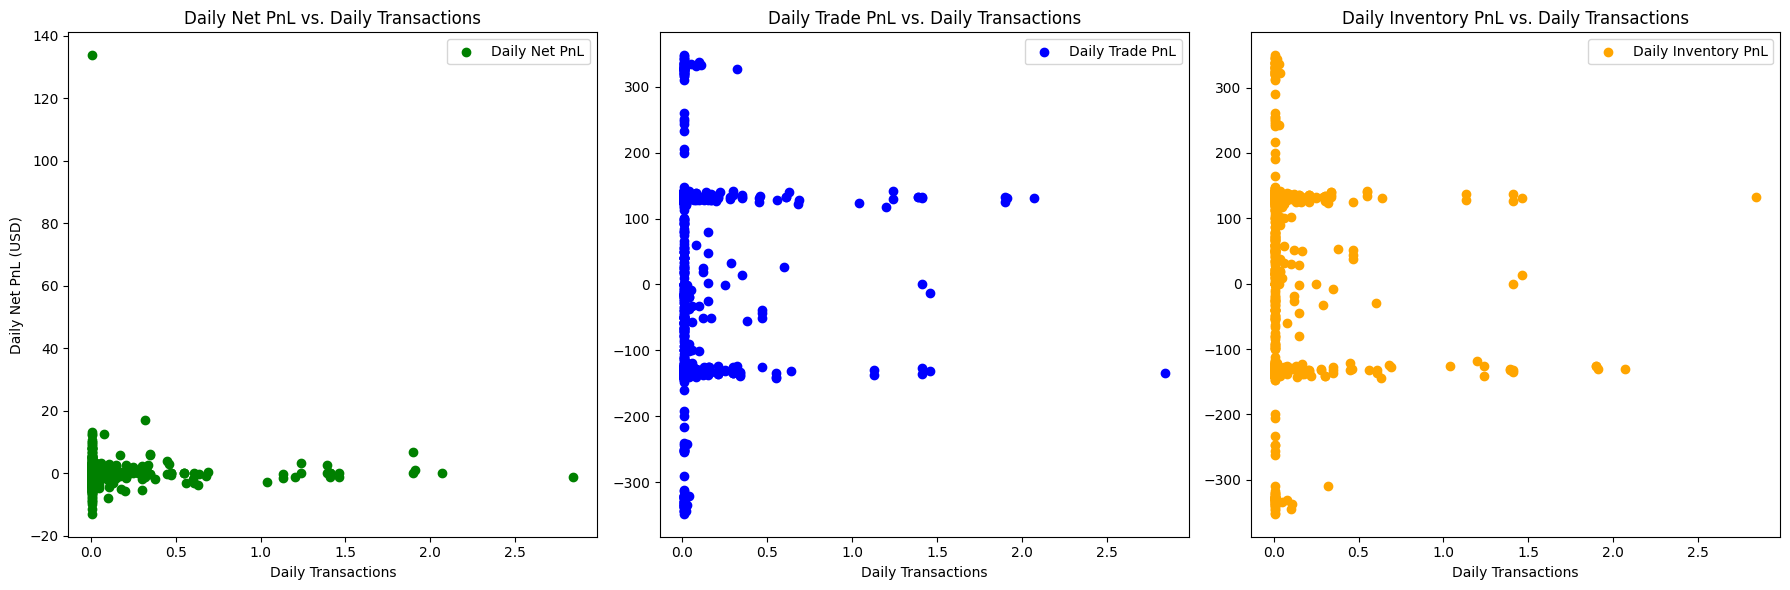

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Daily Transactions
axs[0].scatter(df['spread'], df['net_pnl'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Daily Transactions')
axs[0].set_xlabel('Daily Transactions')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Daily Transactions
axs[1].scatter(df['spread'], df['trade_pnl'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Daily Transactions')
axs[1].set_xlabel('Daily Transactions')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Daily Transactions
axs[2].scatter(df['spread'], df['inventory_pnl'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Daily Transactions')
axs[2].set_xlabel('Daily Transactions')
axs[2].legend()

fig.tight_layout()
plt.show()

In [44]:
corr_spread_net_pnl, p_value_spread_net_pnl = pearsonr(df['spread'], df['net_pnl'])
print(f"Correlation between Spread and Net PnL: {corr_spread_net_pnl}, P-value: {p_value_spread_net_pnl}")
interpret_p_value(p_value_spread_net_pnl, "correlation between spread and net pnl")

corr_spread_trade_pnl, p_value_spread_trade_pnl = pearsonr(df['spread'], df['trade_pnl'])
print(f"Correlation between Spread and Trade PnL: {corr_spread_trade_pnl}, P-value: {p_value_spread_trade_pnl}")
interpret_p_value(p_value_spread_trade_pnl, "correlation between spread and trade pnl")

corr_spread_inventory_pnl, p_value_spread_inventory_pnl = pearsonr(df['spread'], df['inventory_pnl'])
print(f"Correlation between Spread and Inventory PnL: {corr_spread_inventory_pnl}, P-value: {p_value_spread_inventory_pnl}")
interpret_p_value(p_value_spread_inventory_pnl, "correlation between spread and inventory pnl")

Correlation between Spread and Net PnL: 0.005224927137521384, P-value: 0.8611584174235888
There is no statistical significance in correlation between spread and net pnl (p-value: 0.861)
Correlation between Spread and Trade PnL: 0.03144792496162126, P-value: 0.29236654638174125
There is no statistical significance in correlation between spread and trade pnl (p-value: 0.292)
Correlation between Spread and Inventory PnL: -0.03122242555886627, P-value: 0.2958425983905244
There is no statistical significance in correlation between spread and inventory pnl (p-value: 0.296)


Similarly, the PnL of the strategy is not correlated with the spread. This is a good sign as it means that the strategy is robust and can handle different liquidity conditions.

#### Segmenting PnL by Deviation from Target Inventory

As stated in the problem statement, the strategy is market making around a target inventory. I want to investigate the `balance` of our trading strategy and what this target inventory might be. Furthermore, I want to see if there are any trends in the PnL when the inventory deviates from my estimated target inventory.

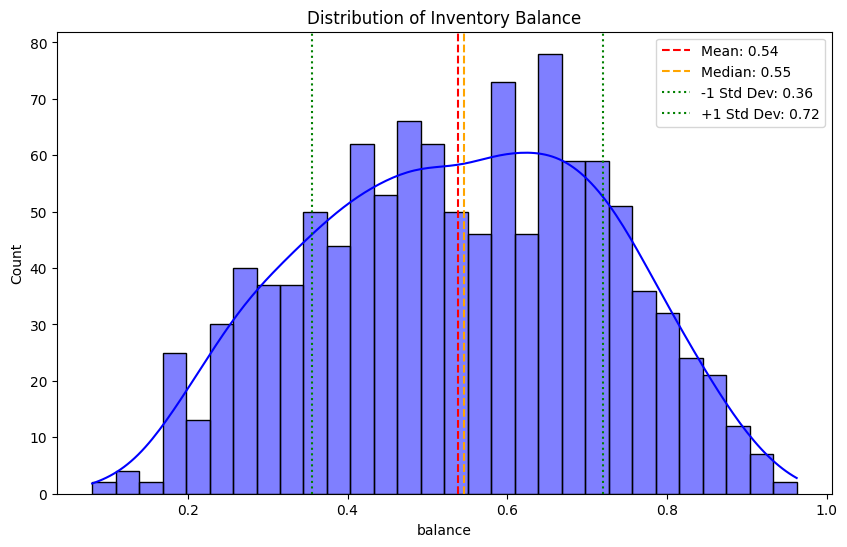

In [45]:
# Firstly, let us investigate the distribution of our inventory balance 
df = merged_data.copy()

plt.figure(figsize=(10, 6))
sns.histplot(df['balance'], bins = 30, kde = True, color = 'blue')

mean_balance = df['balance'].mean()
median_balance = df['balance'].median()
std_balance = df['balance'].std()

plt.axvline(mean_balance, color ='red', linestyle='--', label = f'Mean: {mean_balance:.2f}')
plt.axvline(median_balance, color ='orange', linestyle='--', label = f'Median: {median_balance:.2f}')
plt.axvline(mean_balance - std_balance, color='green', linestyle=':', label=f'-1 Std Dev: {mean_balance - std_balance:.2f}')
plt.axvline(mean_balance + std_balance, color='green', linestyle=':', label=f'+1 Std Dev: {mean_balance + std_balance:.2f}')

plt.legend()
plt.title('Distribution of Inventory Balance')
plt.xlabel='Balance'
plt.ylabel='Frequency'


In [46]:
stat, p = shapiro(df['balance'])

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# The distribution of balance is not normal. Let's see if we can apply the Central Limit Theorem to construct a confidence interval for the mean of the balance.

Shapiro-Wilk Test for balance:
Statistics=0.986, p=0.000


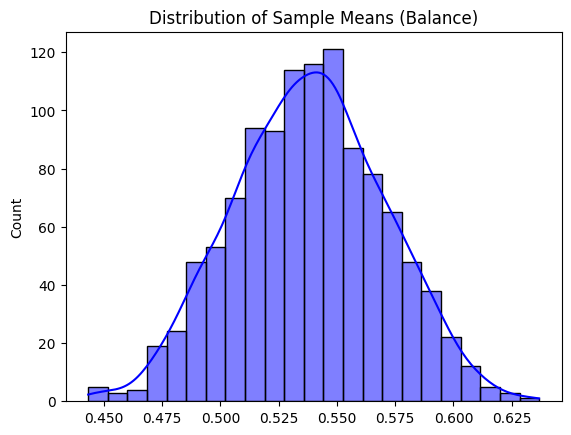

In [47]:
n_samples = 1123  # Number of samples to take
sample_size = 30  # Size of each sample

sample_means = [df['balance'].sample(sample_size).mean() for _ in range(n_samples)]

sns.histplot(sample_means, kde=True, color='blue')
plt.title('Distribution of Sample Means (Balance)')
plt.xlabel = 'Sample Means of Balance'
plt.ylabel = 'Frequency'
plt.show()

In [48]:
stat, p = shapiro(sample_means)

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# Indeed our sample means is normal as our p-value is greater than 0.05 for the Shapiro-Wilk test.

Shapiro-Wilk Test for balance:
Statistics=0.999, p=0.493


In [49]:
mean_of_sample_means = np.mean(sample_means)
std_of_sample_means = np.std(sample_means)

# Calculate the 95% confidence interval for the mean balance
z_score = 1.96  # Z-score for 95% confidence
margin_of_error = z_score * (std_of_sample_means / np.sqrt(n_samples))

lower_bound_balance = mean_of_sample_means - margin_of_error
upper_bound_balance = mean_of_sample_means + margin_of_error

print(f"95% confidence interval for the target inventory: {lower_bound_balance:.2f} to {upper_bound_balance:.2f}")

95% confidence interval for the target inventory: 0.54 to 0.54


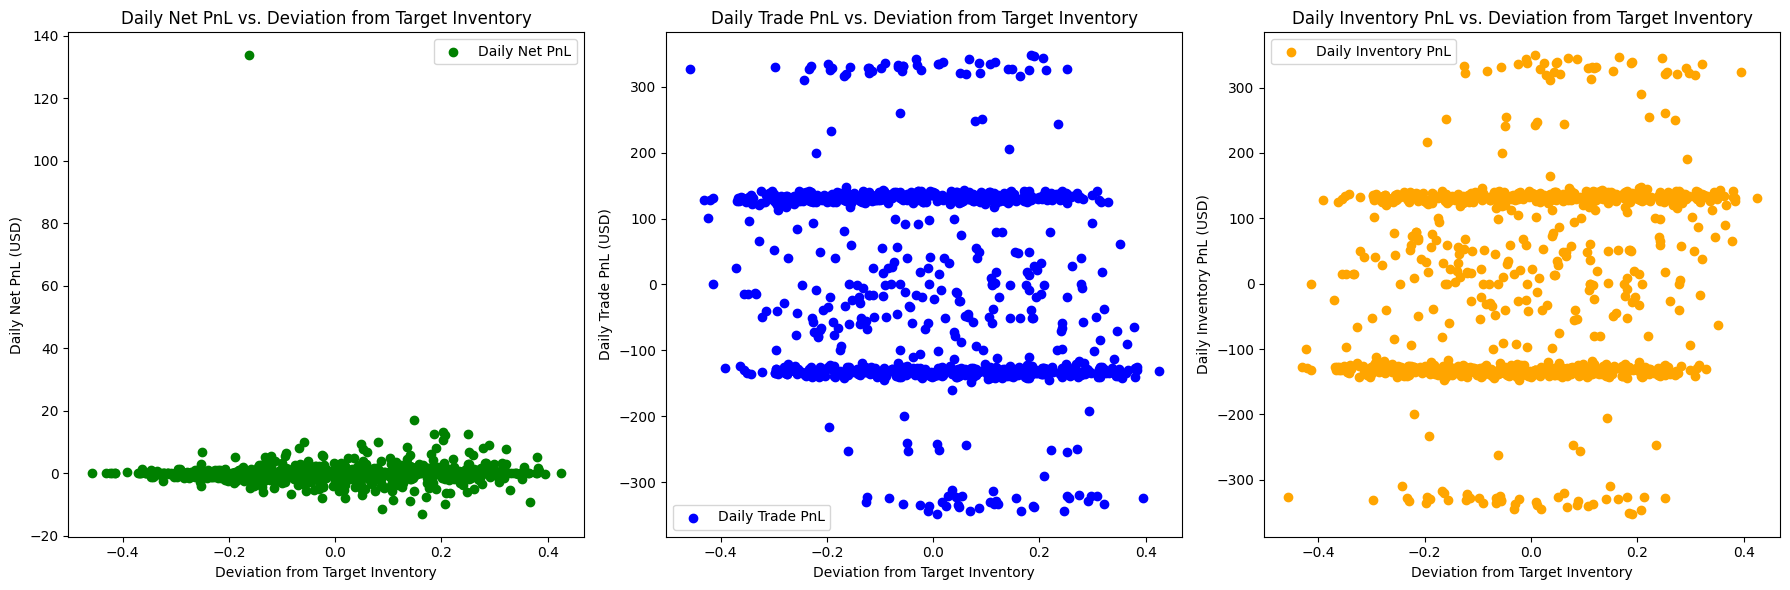

Spearman Correlation - Net PnL: Correlation=0.06907218276817076, P-value=0.020619581243518786
Spearman Correlation - Trade PnL: Correlation=-0.1866928699001399, P-value=2.884840462763195e-10
Spearman Correlation - Inventory PnL: Correlation=0.1925225276128721, P-value=7.747419089121426e-11


In [50]:
target_inventory = (lower_bound_balance + upper_bound_balance) / 2
df['deviation_from_target'] = df['balance'] - target_inventory # I do not calculate the absolute value because perhaps the direction of the deviation might be influential

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Deviation from Target Inventory
axs[0].scatter(df['deviation_from_target'], df['net_pnl'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Deviation from Target Inventory')
axs[0].set_xlabel('Deviation from Target Inventory')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Deviation from Target Inventory
axs[1].scatter(df['deviation_from_target'], df['trade_pnl'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Deviation from Target Inventory')
axs[1].set_xlabel('Deviation from Target Inventory')
axs[1].set_ylabel('Daily Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Deviation from Target Inventory
axs[2].scatter(df['deviation_from_target'], df['inventory_pnl'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Deviation from Target Inventory')
axs[2].set_xlabel('Deviation from Target Inventory')
axs[2].set_ylabel('Daily Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

correlation_net_pnl, p_value_net_pnl = stats.spearmanr(df['deviation_from_target'], df['net_pnl'])
correlation_trade_pnl, p_value_trade_pnl = stats.spearmanr(df['deviation_from_target'], df['trade_pnl'])
correlation_inventory_pnl, p_value_inventory_pnl = stats.spearmanr(df['deviation_from_target'], df['inventory_pnl'])

print(f"Spearman Correlation - Net PnL: Correlation={correlation_net_pnl}, P-value={p_value_net_pnl}")
print(f"Spearman Correlation - Trade PnL: Correlation={correlation_trade_pnl}, P-value={p_value_trade_pnl}")
print(f"Spearman Correlation - Inventory PnL: Correlation={correlation_inventory_pnl}, P-value={p_value_inventory_pnl}")

From the plot, we can see that the net PnL is statistically significant from the deviation from the target inventory, while the trade PnL and inventory PnL are not. With regards to the net PnL, even if the correlation is statistically significant, it is very weak. This result makes sense since we ideally want a trading strategy that is neutral to the inventory and can handle deviations from the target inventory. However, since it is a market making strategy trading around a target inventory, it is expected that the net PnL has a statistically significant relationship with the deviation from the target inventory, even if the correlation is weak.

Furthermore, we can see one outlier in the graph. Let us identify this point.

In [51]:
outlier = df[df['net_pnl'] > 120]
outlier 

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83     0.069   

                           liquidity  fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                             
2023-07-01 00:46:05.617580     Maker  0.0     bnb        237.395823   

                                        fill_id  symbol_x  ...  ask_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.95   

                                    symbol_y  trade_pnl  cumulative_trade_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580  binance_eth_usdt  133.71027             133.71027   

                           balance_value  inventory_pnl  \
timestamp                                                 
2023-07-01 00:46:05.617580     727.69647            0.0   

                            cumulative_inventory_pnl    net_pnl  \
timestamp                                                         
2023-07-01 00:46:05.617580                       0.0  133.71027   

                            cumulative_net_pnl  deviation_from_target  
timestamp                                                              
2023-07-01 00:46:05.617580           133.71027              -0.162517  

[1 rows x 23 columns]

This entry is the first entry in the dataset. It is an outlier because it is the first trade, and it is a sell. Therefore, the pnl during the first trading day is a large, strictly positive value, resulting in the outlier.

#### Segmenting PnL by Deviation from Mean Market Price

In this section, I will investigate if the PnL of the strategy is affected by the deviation from the mean market price. I will estimate the mean market price and then plot the PnL against the deviation from the mean market price.

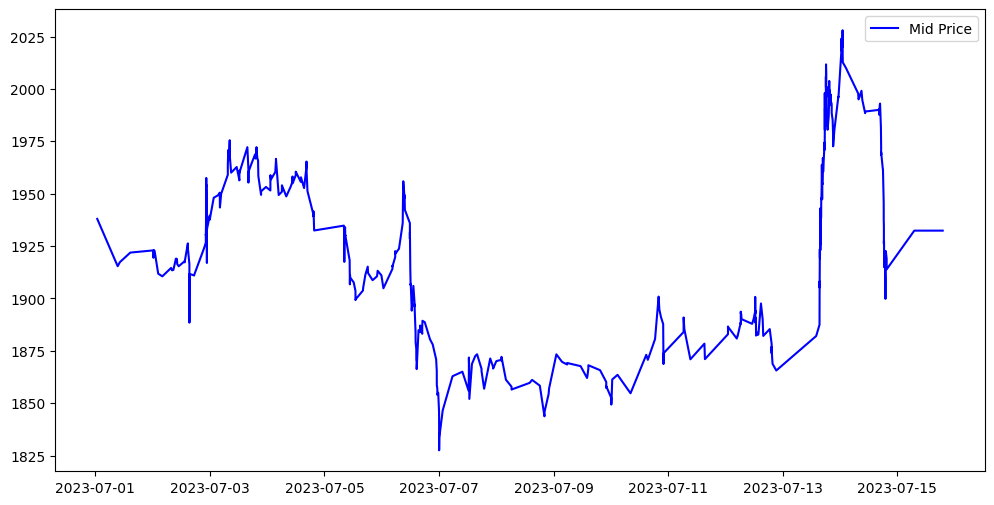

In [52]:
df = merged_data.copy()

df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_prc'], label='Mid Price', color='blue')
plt.xlabel = 'Time'
plt.ylabel = 'Mid Price'
plt.title = 'Mid Price Over Time'
plt.legend()
plt.show()

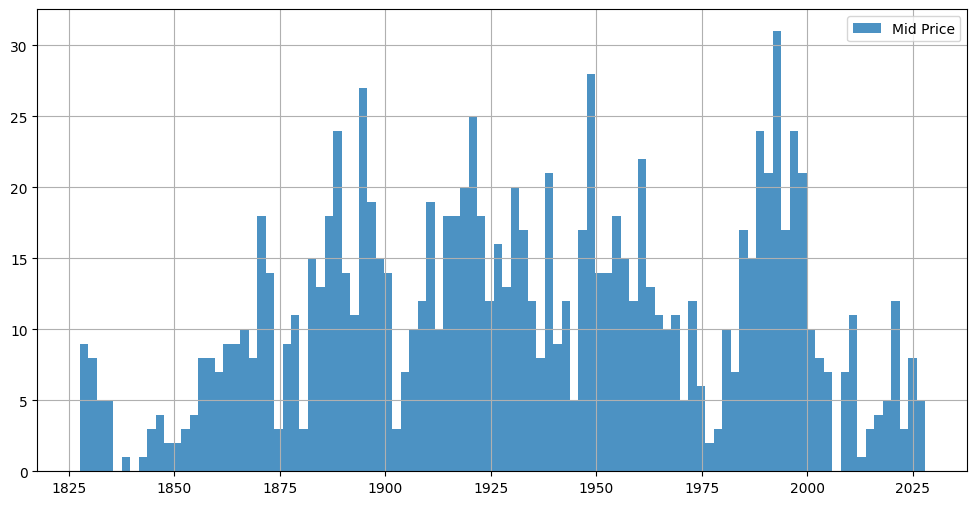

Shapiro-Wilk Test for mid_prc:
Statistics=0.977, p=0.000


In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
df['mid_prc'].hist(bins=100, alpha=0.8, ax=ax, label='Mid Price')
ax.set_xlabel = 'Mid Price'
ax.set_ylabel = 'Frequency'
plt.title = 'Distribution of Mid Price'
ax.legend()
plt.show()

stat, p = shapiro(df['mid_prc'])
print("Shapiro-Wilk Test for mid_prc:")
print(f"Statistics={stat:.3f}, p={p:.3f}")

Note that the distribution is not normal. I will use CLT to estimate the mean market price.

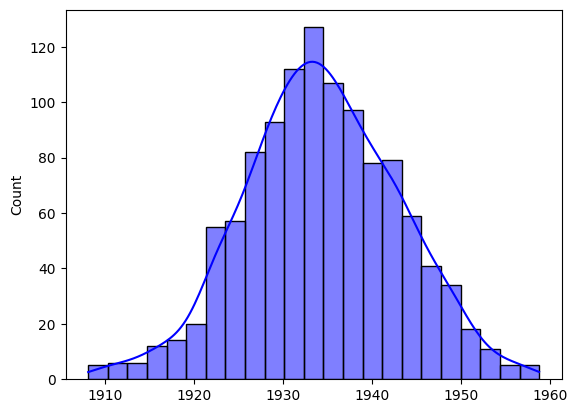

Shapiro-Wilk Test for balance:
Statistics=0.998, p=0.257


In [54]:
n_samples = 1123  # Number of samples to take
sample_size = 30  # Size of each sample

sample_means = [df['mid_prc'].sample(sample_size).mean() for _ in range(n_samples)]

sns.histplot(sample_means, kde=True, color='blue')
plt.title = 'Distribution of Sample Means (Fill Price)'
plt.xlabel = 'Sample Means of Fill Price'
plt.ylabel = 'Frequency'
plt.show()

stat, p = shapiro(sample_means)

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# Indeed our sample means is normal as our p-value is greater than 0.05 for the Shapiro-Wilk test.

In [55]:
mean_of_sample_means = np.mean(sample_means)
std_of_sample_means = np.std(sample_means)

# Calculate the 95% confidence interval for the mean balance
z_score = 1.96  # Z-score for 95% confidence
margin_of_error = z_score * (std_of_sample_means / np.sqrt(n_samples))

lower_bound_mid_prc = mean_of_sample_means - margin_of_error
upper_bound_mid_prc = mean_of_sample_means + margin_of_error

print(f"95% confidence interval for the fill price: {lower_bound_mid_prc:.2f} to {upper_bound_mid_prc:.2f}")

95% confidence interval for the fill price: 1933.80 to 1934.82


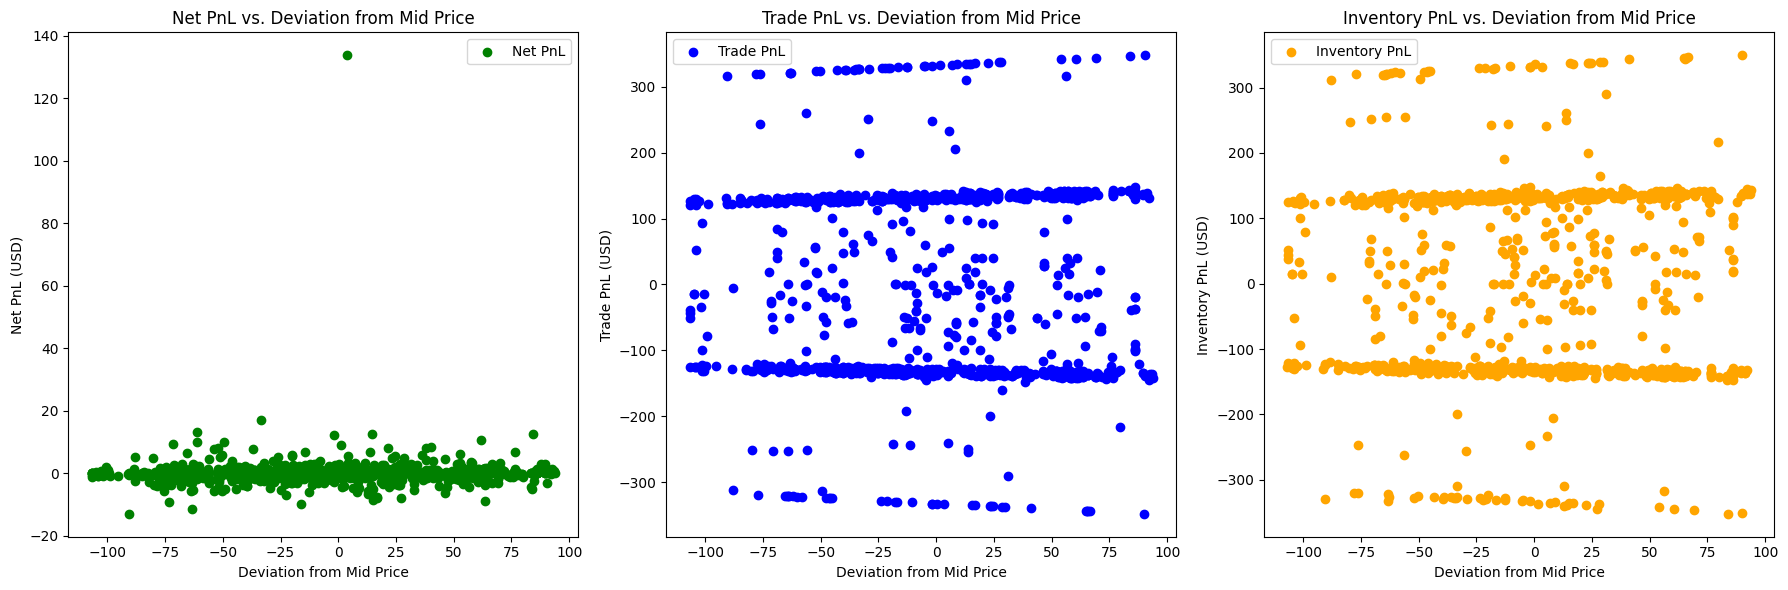

Spearman Correlation - Net PnL: Correlation=0.07145633920378337, P-value=0.01662116533175156
Spearman Correlation - Trade PnL: Correlation=0.028075195167534164, P-value=0.3472325526673893
Spearman Correlation - Inventory PnL: Correlation=-0.0232100567916356, P-value=0.4371380357803356


In [56]:
mean_mid_prc = (lower_bound_mid_prc + upper_bound_mid_prc) / 2
df['deviation_from_mid_price'] = df['mid_prc'] - mean_mid_prc

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Net PnL vs. Deviation from Mid Price
axs[0].scatter(df['deviation_from_mid_price'], df['net_pnl'], color='green', label='Net PnL')
axs[0].set_title('Net PnL vs. Deviation from Mid Price')
axs[0].set_xlabel('Deviation from Mid Price')
axs[0].set_ylabel('Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Trade PnL vs. Deviation from Mid Price
axs[1].scatter(df['deviation_from_mid_price'], df['trade_pnl'], color='blue', label='Trade PnL')
axs[1].set_title('Trade PnL vs. Deviation from Mid Price')
axs[1].set_xlabel('Deviation from Mid Price')
axs[1].set_ylabel('Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Inventory PnL vs. Deviation from Mid Price
axs[2].scatter(df['deviation_from_mid_price'], df['inventory_pnl'], color='orange', label='Inventory PnL')
axs[2].set_title('Inventory PnL vs. Deviation from Mid Price')
axs[2].set_xlabel('Deviation from Mid Price')
axs[2].set_ylabel('Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

correlation_net_pnl, p_value_net_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['net_pnl'])
correlation_trade_pnl, p_value_trade_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['trade_pnl'])
correlation_inventory_pnl, p_value_inventory_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['inventory_pnl'])

print(f"Spearman Correlation - Net PnL: Correlation={correlation_net_pnl}, P-value={p_value_net_pnl}")
print(f"Spearman Correlation - Trade PnL: Correlation={correlation_trade_pnl}, P-value={p_value_trade_pnl}")
print(f"Spearman Correlation - Inventory PnL: Correlation={correlation_inventory_pnl}, P-value={p_value_inventory_pnl}")

Similar to the deviation from the target inventory, the net PnL is statistically significant from the deviation from the mean market price, while the trade PnL and inventory PnL are not. However, the correlation is very weak. A possible explanation for this statistically significant relationship is that, as we found from our previous analysis, net PnL is statistically significant to deviation from the target inventory, and since the value of the inventory is marked from the market price, there is a transitive relationship between the deviation from the mean market price and the net PnL, even if the correlation is weak. This may be a factor to consider when improving the strategy.

### Multi-Linear Regression

In this section, I aim to construct a multi-linear regression model to indentify the factors that are significant to the PnL of the strategy. The goal of this multi-linear regression is not to formulate an accurate predictive model for PnL, but to identify the factors that are statistically significant to the PnL. The results from this analysis will serve to provide further insight into the PnL of our strategy on top of the insights we have already gained from segmenting the PnL.

To accomplish my goal, I will:
1. Perform some feature engineering on my dataset to ensure it is compatible with multi-linear regression.
2. Comapre the results of multi-linear regression using OLS, Lassso (L1 Regularization), and Ridge (L2 Regularization) to check for consistency in the results.

Note that since my goal is to identify and investigate the factors that are significant to the PnL, I will formulate my multi-linear regression model to predict for `net_pnl`. If I wanted a more accurate predictive model, I would construct two multi-linear regression models, one for `trade_pnl` and oen for `inventory_pnl`, and then sum the predictions to get my predicted `net_pnl`.

In [57]:
df = merged_data.copy()

# Necessary for categorizing market condition
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

# From the previous analysis, we found that market condition, deviation from target inventory, deviation from mid price has a statistical significant impact on net pnl
df['market_condition'] = df.apply(categorize_market_condition, axis=1)
df['deviation_from_target'] = df['balance'] - target_inventory
df['deviation_from_mid_price'] = df['mid_prc'] - mean_mid_prc

# Some other features we may want to explore 
df['fill_qty_pct_change'] = df['fill_qty'].pct_change()
df['fill_prc_pct_change'] = df['fill_prc'].pct_change()
df['day'] = df.index.day # Add day, which is days since inception of trading, to see if time has an impact on pnl

df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...     net_pnl  \
timestamp                                                  ...               
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  133.710270   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...   -6.055175   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...   -2.480212   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...    0.914108   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...    2.852113   
...                                         ...       ...  ...         ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...   -0.571013   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...   -0.713690   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...    0.475700   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...    0.507522   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...   -0.241758   

                            cumulative_net_pnl   mid_prc  mid_prc_pct_change  \
timestamp                                                                      
2023-07-01 00:46:05.617580          133.710270  1937.945                 NaN   
2023-07-01 06:52:59.387733          127.655095  1921.735           -0.008365   
2023-07-01 09:19:52.809436          125.174883  1915.365           -0.003315   
2023-07-01 10:16:21.048157          126.088991  1917.325            0.001023   
2023-07-01 14:37:25.452850          128.941104  1921.865            0.002368   
...                                        ...       ...                 ...   
2023-07-15 16:18:25.726018          144.768903  1932.345            0.000000   
2023-07-15 16:19:06.461829          144.055212  1932.345            0.000000   
2023-07-15 18:39:02.613882          144.530912  1932.345            0.000000   
2023-07-15 18:39:02.614281          145.038434  1932.345            0.000000   
2023-07-15 19:04:52.935896          144.796676  1932.345            0.000000   

                           market_condition  deviatio

In [58]:
# Like we saw earlier, the first row is an outlier. We will remove it from the dataset
df = df.iloc[1:]

In [59]:
# Let's remove the features that are not meaningful to our analysis
df.drop(['order_id', 'fill_id', 'fee_ccy', 'symbol_x', 'exch', 'symbol_y'], axis=1, inplace=True)

In [60]:
# On a further note, since we are modelling net pnl, we do not need cumulative pnl features. This is because including them in the model would lead to data leakage.
df.drop(['cumulative_trade_pnl', 'cumulative_inventory_pnl', 'cumulative_net_pnl'], axis=1, inplace=True)

First, I want to check for multi-colinearity in my dataset.

In [61]:
# Let me identify the quantitative and categorical features in the training data
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

assert len(numerical_features) + len(categorical_features) == df.shape[1]

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

for feature in categorical_features:
    print(f"Unique values for {feature}: {df[feature].unique()}")

Numerical Features: ['fill_prc', 'fill_qty', 'fee', 'fee_ccy_usd_rate', 'balance', 'bid_prc', 'ask_prc', 'trade_pnl', 'balance_value', 'inventory_pnl', 'net_pnl', 'mid_prc', 'mid_prc_pct_change', 'deviation_from_target', 'deviation_from_mid_price', 'fill_qty_pct_change', 'fill_prc_pct_change', 'day']
Categorical Features: ['side', 'liquidity', 'market_condition']
Unique values for side: ['B' 'S']
Unique values for liquidity: ['Maker' 'Taker']
Unique values for market_condition: ['Bear' 'Bull' 'Neutral']


In [62]:
# I need this to investigate whether I should use a dummy variable or ordinal relationship for my market conditoon feature
states = ['Bull', 'Bear', 'Neutral']
market_condition_transition_matrix = pd.DataFrame(0, index=states, columns=states, dtype=float)

for (current_state, next_state) in zip(df['market_condition'][:-1], df['market_condition'][1:]):
    market_condition_transition_matrix.at[current_state, next_state] += 1

market_condition_transition_matrix = market_condition_transition_matrix.div(market_condition_transition_matrix.sum(axis=1), axis=0)
# I will use this transition matrix later on in my final section so I don't get too sidetracked here 
market_condition_transition_matrix

Bull      Bear   Neutral
Bull     0.283019  0.226415  0.490566
Bear     0.242754  0.336957  0.420290
Neutral  0.212069  0.210345  0.577586

In [63]:
# Encode the categorical features
df_encoded = pd.get_dummies(df, columns=['side', 'liquidity', 'market_condition'])
# Use one hot encoding for market conditions since transition matrix shows that there is no ordinal relationship between the states
df_encoded

fill_prc  fill_qty       fee  fee_ccy_usd_rate  \
timestamp                                                                    
2023-07-01 06:52:59.387733   1920.53    0.0264  0.000000        237.395823   
2023-07-01 09:19:52.809436   1914.23    0.0707  0.000000        237.395823   
2023-07-01 10:16:21.048157   1916.97    0.1719  0.000305        237.395823   
2023-07-01 14:37:25.452850   1921.43    0.1719  0.000000        237.395823   
2023-07-02 00:15:18.613260   1922.02    0.0693  0.000000        237.395823   
...                              ...       ...       ...               ...   
2023-07-15 16:18:25.726018   1935.21    0.1719  0.000299        259.829225   
2023-07-15 16:19:06.461829   1936.04    0.1719  0.000299        259.829225   
2023-07-15 18:39:02.613882   1939.44    0.0670  0.000000        259.829225   
2023-07-15 18:39:02.614281   1939.87    0.0674  0.000000        259.829225   
2023-07-15 19:04:52.935896   1935.97    0.0666  0.000000        259.829225   

                            balance  bid_prc  ask_prc   trade_pnl  \
timestamp                                                           
2023-07-01 06:52:59.387733   0.4019  1921.73  1921.74  -50.701992   
2023-07-01 09:19:52.809436   0.4726  1915.36  1915.37 -135.336061   
2023-07-01 10:16:21.048157   0.6445  1917.32  1917.33 -329.599496   
2023-07-01 14:37:25.452850   0.4726  1921.86  1921.87  330.293817   
2023-07-02 00:15:18.613260   0.5419  1922.91  1922.92 -133.195986   
...                             ...      ...      ...         ...   
2023-07-15 16:18:25.726018   0.4808  1932.34  1932.35 -332.740259   
2023-07-15 16:19:06.461829   0.6527  1932.34  1932.35 -332.882936   
2023-07-15 18:39:02.613882   0.5857  1932.34  1932.35  129.942480   
2023-07-15 18:39:02.614281   0.5183  1932.34  1932.35  130.747238   
2023-07-15 19:04:52.935896   0.5849  1932.34  1932.35 -128.935602   

                            balance_value  inventory_pnl  ...  \
timestamp                                                 ...   
2023-07-01 06:52:59.387733     772.343287      44.646817  ...   
2023-07-01 09:19:52.809436     905.199136     132.855849  ...   
2023-07-01 10:16:21.048157    1235.712740     330.513604  ...   
2023-07-01 14:37:25.452850     908.271036    -327.441704  ...   
2023-07-02 00:15:18.613260    1042.024929     133.753893  ...   
...                                   ...            ...  ...   
2023-07-15 16:18:25.726018     929.069072     332.169246  ...   
2023-07-15 16:19:06.461829    1261.238318     332.169246  ...   
2023-07-15 18:39:02.613882    1131.771538    -129.466780  ...   
2023-07-15 18:39:02.614281    1001.531822    -130.239716  ...   
2023-07-15 19:04:52.935896    1130.225666     128.693844  ...   

                            fill_qty_pct_change  fill_prc_pct_change  day  \
timestamp                                                                   
2023-07-01 06:52:59.387733            -0.617391            -0.008928    1   
2023-07-01 09:19:52.809436             1.678030            -0.003280    1   
2023-07-01 10:16:21.048157             1.431400             0.001431    1   
2023-07-01 14:37:25.452850             0.000000             0.002327    1   
2023-07-02 00:15:18.613260            -0.596859             0.000307    2   
...                                         ...                  ...  ...   
2023-07-15 16:18:25.726018             0.000000             0.002606   15   
2023-07-15 16:19:06.461829             0.000000             0.000429   15   
2023-07-15 18:39:02.613882            -0.610239             0.001756   15   
2023-07-15 18:39:02.614281             0.005970             0.000222   15   
2023-07-15 19:04:52.935896            -0.011869            -0.002010   15   

                            side_B  side_S  liquidity_Maker  liquidity_Taker  \
timestamp                                                                      
2023-07-01 06:52:59.387733    True   False             True            False   
2023-07-01 09:19:52.809436 

In [64]:
# Before I proceed, I want to filter out categorical features that do not have a statistically significant relationship with net pnl

categorical_columns = ['side_B', 'side_S', 'liquidity_Maker', 'liquidity_Taker', 'market_condition_Bear', 'market_condition_Bull', 'market_condition_Neutral']

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

ordinal_relationships = {}

for column in categorical_columns:
    try:
        rho, p_value = spearmanr(df_encoded['net_pnl'], df_encoded[column])
        significance = p_value < 0.05
        ordinal_relationships[column] = {'rho': rho, 'p_value': p_value, 'significant': significance}
    except Exception as e:
        print(f"Error processing column {column}: {e}")

for column, results in ordinal_relationships.items():
    significance_msg = "significant" if results['significant'] else "no significant"
    print(f"There is {significance_msg} ordinal relationship between 'net_pnl' and '{column}' (rho = {results['rho']:.3f}, p-value = {results['p_value']:.3f})")

There is significant ordinal relationship between 'net_pnl' and 'side_B' (rho = 0.137, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'side_S' (rho = -0.137, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'liquidity_Maker' (rho = 0.087, p-value = 0.004)
There is significant ordinal relationship between 'net_pnl' and 'liquidity_Taker' (rho = -0.087, p-value = 0.004)
There is significant ordinal relationship between 'net_pnl' and 'market_condition_Bear' (rho = -0.742, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'market_condition_Bull' (rho = 0.728, p-value = 0.000)
There is no significant ordinal relationship between 'net_pnl' and 'market_condition_Neutral' (rho = 0.021, p-value = 0.489)


In [65]:
# Remove `market_condition_Neutral` since they do not have a statistically significant relationship with net pnl
df_encoded.drop(['market_condition_Neutral'], axis=1, inplace=True)

<Axes: >

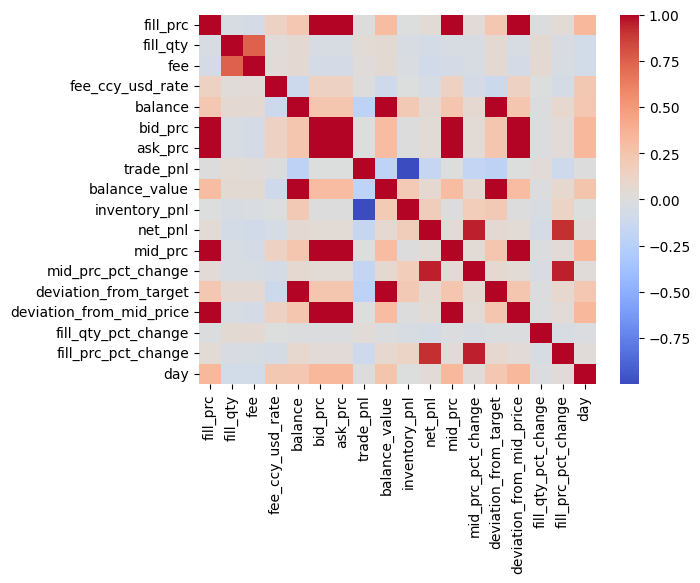

In [66]:
corr = df_encoded[numerical_features].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')

From the correlation matrix, we can see that there is multi-colinearity in our dataset. Let us investigate this further by calculating the VIF of our features.

In [67]:
features = df_encoded.drop(columns=['trade_pnl', 'inventory_pnl', 'net_pnl'])

X = features
X_with_constant = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                     Feature          VIF
10     deviation_from_target          inf
11  deviation_from_mid_price          inf
18           liquidity_Taker          inf
17           liquidity_Maker          inf
4                    balance          inf
5                    bid_prc          inf
6                    ask_prc          inf
16                    side_S          inf
8                    mid_prc          inf
15                    side_B          inf
0                   fill_prc  2393.366604
7              balance_value  1685.103857
9         mid_prc_pct_change    16.387007
2                        fee    14.450758
13       fill_prc_pct_change    14.403786
1                   fill_qty     2.405389
19     market_condition_Bear     1.716237
20     market_condition_Bull     1.699684
14                       day     1.268030
3           fee_ccy_usd_rate     1.191083
12       fill_qty_pct_change     1.015012


In [68]:
features_to_remove = ['bid_prc', 'ask_prc', 'mid_prc', 'side_B', 'fill_prc_pct_change', 'fill_qty_pct_change', 'balance_value', 'mid_prc_pct_change', 'liquidity_Taker', 'liquidity_Maker', 'deviation_from_target', 'deviation_from_mid_price']
features_reduced = features.drop(columns=features_to_remove)

X = features_reduced
X_with_constant = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                 Feature       VIF
1               fill_qty  2.263808
2                    fee  2.251413
5                    day  1.238253
4                balance  1.198317
0               fill_prc  1.190808
7  market_condition_Bear  1.183298
8  market_condition_Bull  1.138282
3       fee_ccy_usd_rate  1.114873
6                 side_S  1.093771


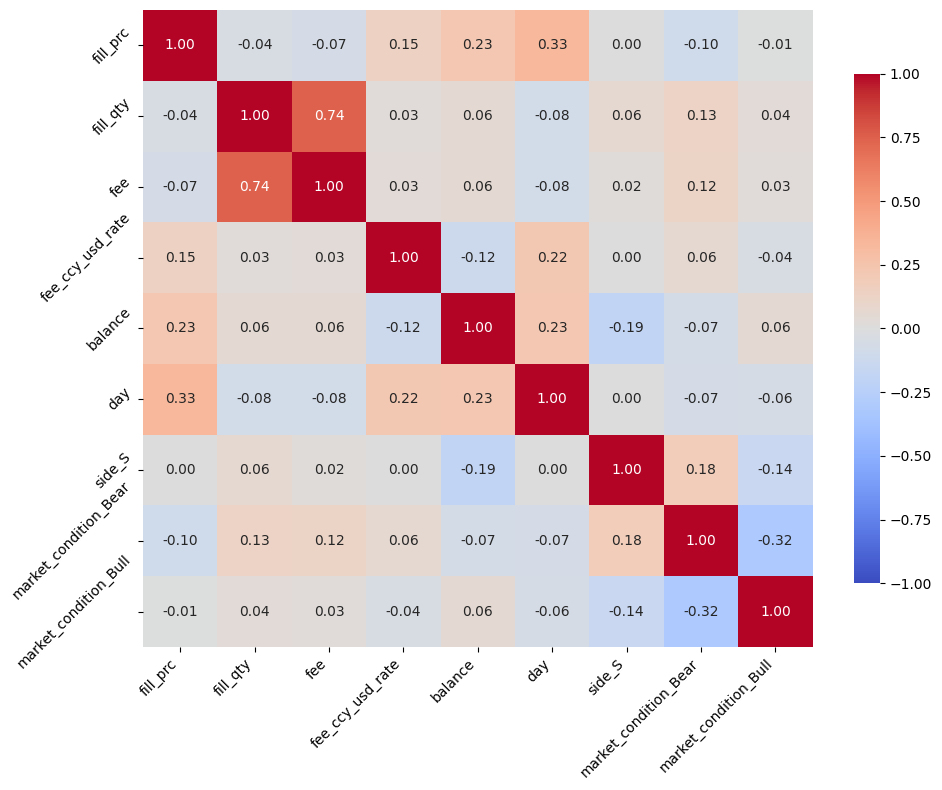

In [69]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title = 'Correlation Matrix of Numeric Features'
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Looking at our correlation matrix, our features look much better. Even though `fee` is somewhat correlated with `fill_qty`, which is expected, the VIF score is still less than 3. So we shall keep it still.

Let us proceed by constructing a preliminary multi-linear regression model using OLS. This serves as a further investigation to identify which features are statistically significant to the PnL of the strategy.

In [70]:
y_net_pnl = df_encoded['net_pnl']

In [71]:
# OLS for trade pnl

X_trade = sm.add_constant(features_reduced)

model_net_pnl = sm.OLS(y_net_pnl, X_trade).fit()

model_net_pnl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                net_pnl   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     128.1
Date:                Sun, 17 Mar 2024   Prob (F-statistic):          5.81e-165
Time:                        19:30:43   Log-Likelihood:                -2097.6
No. Observations:                1122   AIC:                             4215.
Df Residuals:                    1112   BIC:                             4265.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.2451      3.034      0.740      0.460      -3.709       8.199
fill_prc                 -0.0006      0.001     -0.535      0.593      -0.003       0.002
fill_qty                  0.5699      2.086      0.273      0.785      -3.523       4.663
fee                   -1700.5323    971.175     -1.751      0.080   -3606.075     205.011
fee_ccy_usd_rate         -0.0053      0.010     -0.507      0.612      -0.026       0.015
balance                   0.0287      0.283      0.101      0.919      -0.527       0.585
day                       0.0154      0.012      1.292      0.197      -0.008       0.039
side_S                   -0.0116      0.098     -0.118      0.906      -0.205       0.182
market_condition_Bear    -2.2536      0.119    -18.960      0.000      -2.487      -2.020
market_condition_Bull     2.3107      0.118     19.548      0.000       2.079       2.543
==============================================================================
Omnibus:                      569.461   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19917.175
Skew:                           1.691   Prob(JB):                         0.00
Kurtosis:                      23.362   Cond. No.                     4.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The OLS regression indicates an R-squared value of `0.5091` and an adjusted R-squared value of `0.505`. This means that our model explains 50.5% of the variance in the PnL. While this is not a high R-squared value, the F-statistic and the p-value of the regression model is statistically significant, with values of `128.1` and `5.81e-165` respectively. This means that some coefficients in our model are statistically significant. There is also a further note that the condition number if large, indicating multicolinearity. To address this, let us isolate the features that are statistically significant, namely `market_condition_Bear`, `market_condition_Bull`, `fee`, and `fee_ccy_usd_rate`.

Thinking about the collection of statistically significant features, the fact that `market_condition_Bear` and `market_condition_Bull` are significant here aligns with our initial analysis when we bucketed the PnL by market conditions. Furthermore, it makes sense that `fee` and `fee_ccy_usd_rate` are significant. This is because the `fee` and `fee_ccy_usd_rate` make up the variable costs of the strategy.

With regards to the strategy's performance, the finding that only few of our features are significant to the PnL is a good sign. It means that the strategy is robust and can handle different market stress and other variables. When designing an algorithmic trading strategy, this is a quality we want to see as that means we have `alpha` in our strategy, or that our strategy is not dependent on external factors.

Let us further investigate our isolated features using Lasso and Ridge regression to see if the results are consistent.

In [72]:
selected_features = ['market_condition_Bear', 'market_condition_Bull', 'fee', 'fee_ccy_usd_rate']

# Function to standardize the data since our analysis focuses on the importance of the features in relation to each other on the net pnl
def standardize_data(data):
    return (data - data.mean()) / data.std()

for feature in selected_features:
      df_encoded[feature] = standardize_data(df_encoded[feature])


In [73]:
# Now that we have the features we want, let's split our data into training and testing sets
selection = selected_features + ['net_pnl']
train_data, test_data = train_test_split(df_encoded[selection], test_size=0.3, random_state=42)

print(f"I have {train_data.shape[0]} entries in my training set")
print(f"I have {test_data.shape[0]} entries in my testing set")
# The number of entries seem like a reasonable amount for a simple linear regression model

I have 785 entries in my training set
I have 337 entries in my testing set


In [74]:
# Implement an RMSE loss function
def rmse_cv(model, X_train, y_train, cv=5):
    # Calculate the cross-validated RMSE for a given model.
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    # Calculate RMSE from the negated MSE scores
    rmse_scores = np.sqrt(-neg_mse_scores)
    # Return the average RMSE
    return np.mean(rmse_scores)

In [75]:
X_train = train_data[selected_features]
y_train = train_data['net_pnl']

X_test = test_data[selected_features]
y_test = test_data['net_pnl']

In [76]:
# Lasso Regression
alphas = np.logspace(-6, 6, 100)
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)

optimal_lambda = lasso_cv.alpha_
print(f"The best lambda is: {optimal_lambda}")

lasso_cv_rmse = rmse_cv(lasso_cv, X_train, y_train).mean()
print(f"Train Lasso RMSE: {lasso_cv_rmse}")

y_pred_lasso = lasso_cv.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Test Lasso RMSE: {lasso_rmse}")


coefficients = dict(zip(selected_features, lasso_cv.coef_))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)

The best lambda is: 1e-06
Train Lasso RMSE: 1.4201265479976746
Test Lasso RMSE: 1.8843968968689424

Regression equation:
net_pnl = (-0.9794)market_condition_Bear + (0.8709)market_condition_Bull + (-0.1177)fee + (-0.1016)fee_ccy_usd_rate


The Lasso regression shows that the RMSE from the training set and testing set are of resonable values. Furthermore, the multi-linear regression model using Lasso aligns with our previous findings that `market_condition_Bear` has a negative impact on the PnL, while `market_condition_Bull` has a positive impact on the PnL. Furthermore, while `fee` and `fee_ccy_usd_rate` are significant, their impact is minimal. This is a good sign as it means the strategy is not too sensitive to trading fees and the exchange rate. 

One interesting thing to note is that the magnitude of the coefficient  `market_condition_Bear` is larger than the magnitude of the coefficient `market_condition_Bull`. One interpretation of this result is that the PnL of the strategy is more sensitive to bear markets than bull markets, leading to a more substantial negative impact on the trading strategy's profit and loss (PnL) than the positive impact bull markets have on its profitability. This suggests that the strategy is more vulnerable to losing money during market downturns than it is capable of capitalizing on market upswings. This could imply that the strategy's mechanisms or positions are not as effective in exploiting opportunities in bull markets or are possibly structured in a way that incurs greater losses during bear markets. This is one potential area of improvement in the risk management of the strategy.

In [77]:
# Ridge Regression

ridge = Ridge()
cv_ridge_rmse = []

for alpha in alphas:
    model = Ridge(alpha=alpha)    
    # Use cross_val_score to calculate the negative mean squared error for each fold
    # Take the square root of the negative mean to get RMSE
    # np.mean is used to get the average RMSE across all folds
    rmse = rmse_cv(model, X_train, y_train).mean()
    cv_ridge_rmse.append(rmse)

# Convert the results into a numpy array for efficient operations
cv_ridge_rmse = np.array(cv_ridge_rmse)
min_rmse_alpha = alphas[np.argmin(cv_ridge_rmse)]
print(f"Optimal alpha: {min_rmse_alpha} with RMSE: {np.min(cv_ridge_rmse)}")

ridge_model = Ridge(alpha=min_rmse_alpha).fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge RMSE: {ridge_rmse}")

coefficients = dict(zip(selected_features, ridge_model.coef_))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)

Optimal alpha: 18.738174228603867 with RMSE: 1.4195619375283708
Ridge RMSE: 1.8879943221941269

Regression equation:
net_pnl = (-0.9617)market_condition_Bear + (0.8557)market_condition_Bull + (-0.1172)fee + (-0.1008)fee_ccy_usd_rate


Observing the Ridge regression, we find similar results to the Lasso regression. 

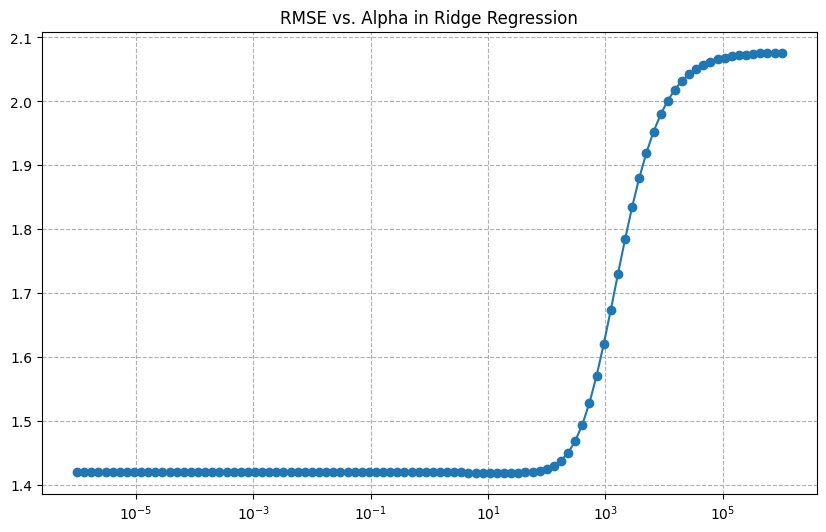

In [78]:
cv_ridge_series = pd.Series(cv_ridge_rmse, index=alphas)
plt.figure(figsize=(10, 6))
cv_ridge_series.plot(logx=True, marker='o', linestyle='-', title='RMSE vs. Alpha in Ridge Regression')
plt.xlabel = "Alpha (log scale)"
plt.ylabel = "Root Mean Squared Error (RMSE)"
plt.grid(True, which="both", ls="--")
plt.show()

By observing the regularization strength (alpha) in ridge regression against the RMSE of the model, we see that alpha increases from very small values, there's a decrease in RMSE, indicating that adding some degree of regularization improves the model's predictive accuracy by preventing overfitting. We select the minimum alpha that gives the minimum RMSE, which is `18.738`, for our ridge regression.

In [79]:
# OLS RMSE
X_train_const = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_const).fit()

X_test_const = sm.add_constant(X_test)
y_pred_ols = model_ols.predict(X_test_const)

ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"OLS RMSE: {ols_rmse}")

coefficients = dict(zip(selected_features, model_ols.params[1:]))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)

OLS RMSE: 1.8843968564913942

Regression equation:
net_pnl = (-0.9794)market_condition_Bear + (0.8709)market_condition_Bull + (-0.1177)fee + (-0.1016)fee_ccy_usd_rate


Likewise, the RMSE for OLS shows a reasonable value, and the coefficients of the features are consistent with our previous findings.

Comparison of RMSE Values Across Models
OLS: 1.8843968564913942
Lasso: 1.8843968968689424
Ridge: 1.4195619375283708


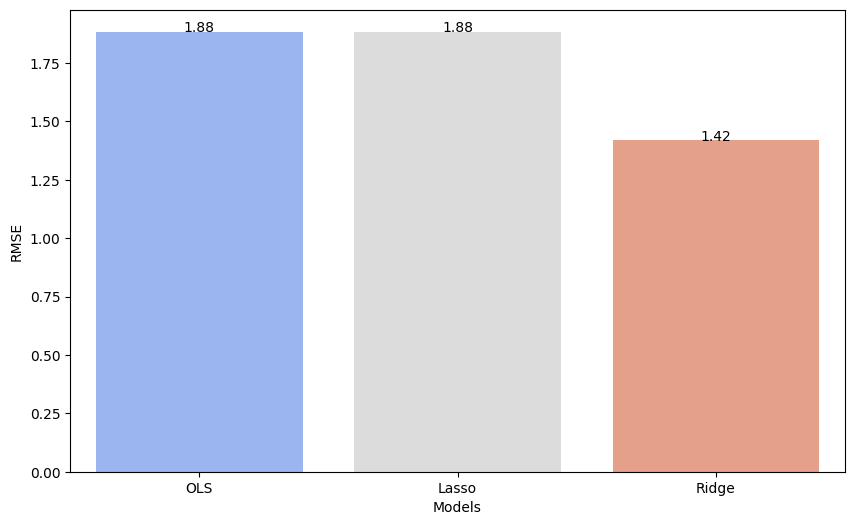

In [80]:
print("Comparison of RMSE Values Across Models")
print(f"OLS: {ols_rmse}")
print(f"Lasso: {lasso_rmse}")
print(f"Ridge: {np.min(cv_ridge_rmse)}")

rmse_values = [ols_rmse, lasso_rmse, np.min(cv_ridge_rmse)]
models = ['OLS', 'Lasso', 'Ridge']
data = {'Models': models, 'RMSE': rmse_values}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Models', y='RMSE', data=df, palette='coolwarm')

for index, row in df.iterrows():
    barplot.text(index, row.RMSE, round(row.RMSE, 2), color='black', ha="center")

plt.ylabel = 'RMSE'
plt.xlabel = 'Models'
plt.title = 'Comparison of RMSE Values Across Models'
plt.show()

Plotting the RSMEs of the three models, we can see that the Ridge regression has the lowest RMSE, followed by the Lasso and OLS which share similar RMSEs.

L2 regularization (Ridge) is more effective in preventing overfitting than L1 regularization (Lasso) or OLS. This suggests that the dataset may still have a high degree of multicollinearity among predictors, and the L2 regularization is helping to mitigate this by penalizing the size of the coefficients, thereby improving the model's predictive accuracy.

Next, let us calculate the R-squared of our models and plot the observed vs predicted PnL to see how well our models are performing.

In [81]:
r_squared_lasso = r2_score(y_test, y_pred_lasso)
r_squared_ridge = r2_score(y_test, y_pred_ridge)
r_squared_ols = r2_score(y_test, y_pred_ols)

print(f"R-squared for Lasso: {r_squared_lasso}")
print(f"R-squared for Ridge: {r_squared_ridge}")
print(f"R-squared for OLS: {r_squared_ols}")

R-squared for Lasso: 0.4490315256695966
R-squared for Ridge: 0.44692585473710833
R-squared for OLS: 0.4490315492811361


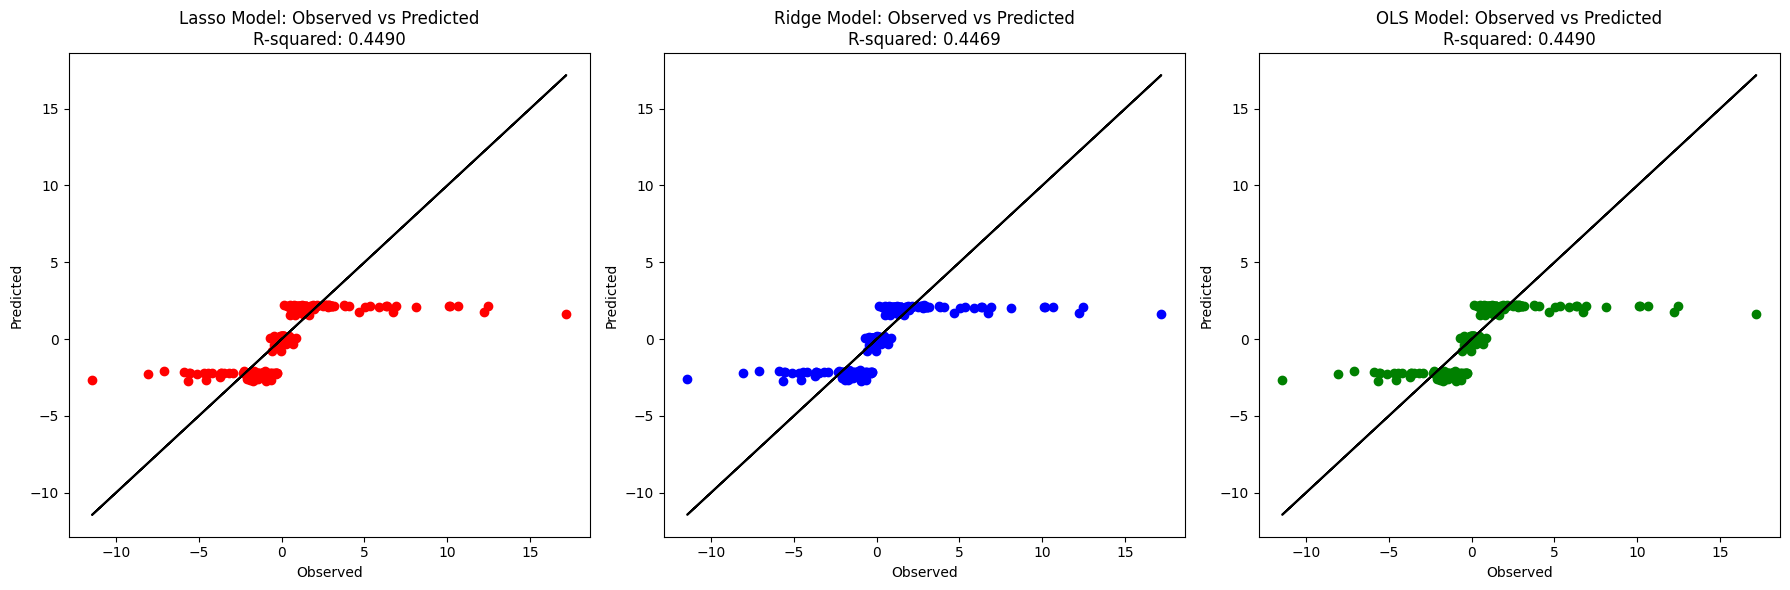

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(y_test, y_pred_lasso, color="red")
axs[0].plot(y_test, y_test, color="black") 
axs[0].set_title(f"Lasso Model: Observed vs Predicted\nR-squared: {r_squared_lasso:.4f}")
axs[0].set_xlabel("Observed")
axs[0].set_ylabel("Predicted")

axs[1].scatter(y_test, y_pred_ridge, color="blue")
axs[1].plot(y_test, y_test, color="black") 
axs[1].set_title(f"Ridge Model: Observed vs Predicted\nR-squared: {r_squared_ridge:.4f}")
axs[1].set_xlabel("Observed")
axs[1].set_ylabel("Predicted")

axs[2].scatter(y_test, y_pred_ols, color="green")
axs[2].plot(y_test, y_test, color="black") 
axs[2].set_title(f"OLS Model: Observed vs Predicted\nR-squared: {r_squared_ols:.4f}")
axs[2].set_xlabel("Observed")
axs[2].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

From the plots above, we can see that our model deviates from the observed values when the PnL deviates far from zero. Furthermore, note that the there seems to be three cluster of points, a cluster of points above zero, a cluster of points near zero, and a cluster of points below zro. This is a pattern worth investigating later on. 

Next, let us rank the impact of each feature on the PnL of the strategy.

In [83]:
# Extracting coefficients from the models
coefs_ols = model_ols.params[1:]  # Excluding the intercept
feature_importance_ols = pd.DataFrame({
    'Feature': coefs_ols.index,
    'Importance': abs(coefs_ols.values),
    'Model': 'OLS'
}).sort_values(by='Importance', ascending=False)

coefs_lasso = lasso_cv.coef_
feature_importance_lasso = pd.DataFrame({
    'Feature': selected_features,
    'Importance': abs(coefs_lasso)
}).sort_values(by='Importance', ascending=False)

coefs_ridge = ridge_model.coef_ 
feature_importance_ridge = pd.DataFrame({
    'Feature': selected_features, 
    'Importance': abs(coefs_ridge)
}).sort_values(by='Importance', ascending=False)

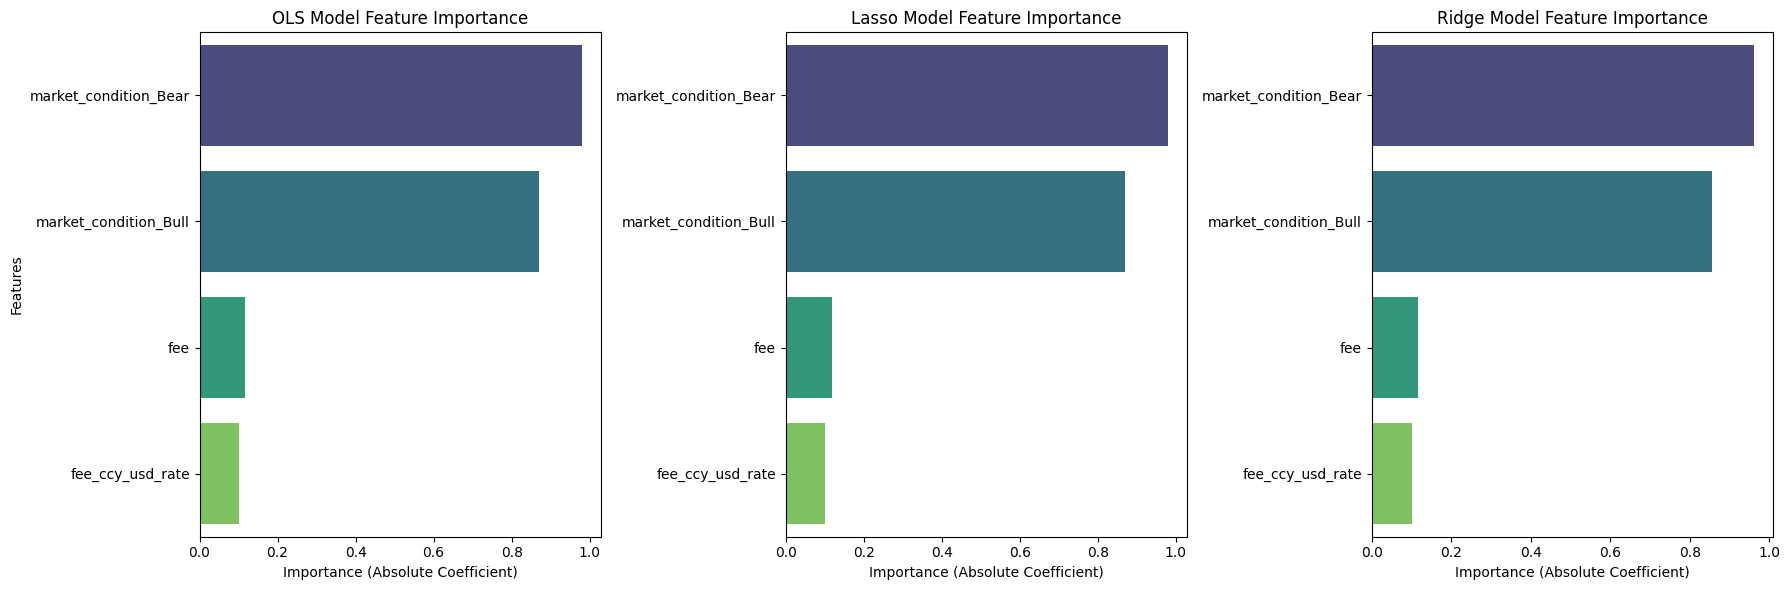

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ols.sort_values(by='Importance', ascending=False), ax=axs[0], palette='viridis')
axs[0].set_title('OLS Model Feature Importance')
axs[0].set_xlabel('Importance (Absolute Coefficient)')
axs[0].set_ylabel('Features')

# Lasso Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_lasso.sort_values(by='Importance', ascending=False), ax=axs[1], palette='viridis')
axs[1].set_title('Lasso Model Feature Importance')
axs[1].set_xlabel('Importance (Absolute Coefficient)')
axs[1].set_ylabel('')

# Ridge Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ridge.sort_values(by='Importance', ascending=False), ax=axs[2], palette='viridis')
axs[2].set_title('Ridge Model Feature Importance')
axs[2].set_xlabel('Importance (Absolute Coefficient)')
axs[2].set_ylabel('')

# Adjust the layout
fig.tight_layout()
plt.show()


In all three models, the `market_condition_Bear` has the largest impact on the PnL of the strategy. Furthermore, the `market_condition_Bull` has a positive impact on the PnL of the strategy, but the magnitude of the impact is smaller than the impact of `market_condition_Bear`. This is followed by `fee` and `fee_ccy_usd_rate`, which are substantially less impactful than the market conditions. 

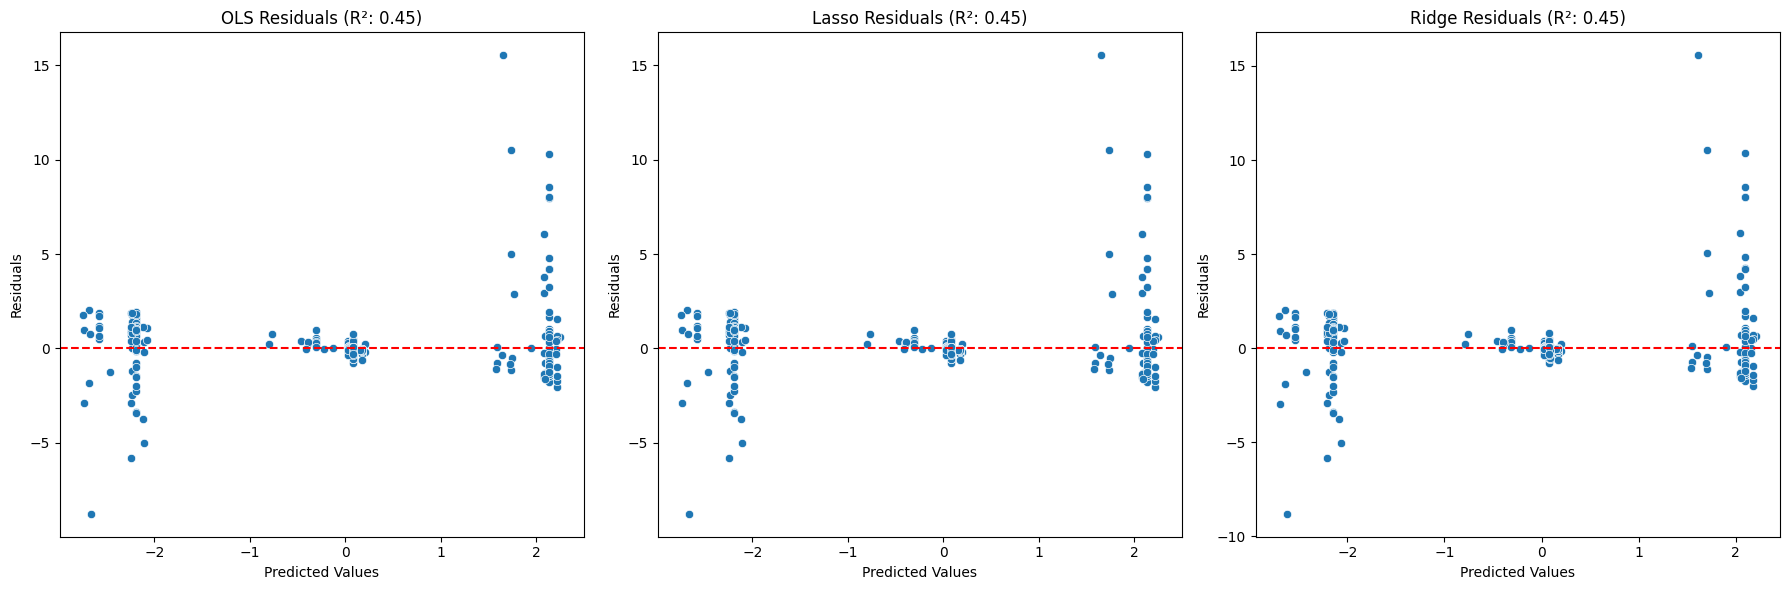

In [85]:
# Assuming y_pred_ols, y_pred_lasso, and y_pred_ridge are your predictions for each model
residuals_ols = y_test - y_pred_ols
residuals_lasso = y_test - y_pred_lasso
residuals_ridge = y_test - y_pred_ridge

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Residuals Plot
sns.scatterplot(ax=axs[0], x=y_pred_ols, y=residuals_ols)
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title(f'OLS Residuals (R²: {r_squared_ols:.2f})')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')

# Lasso Residuals Plot
sns.scatterplot(ax=axs[1], x=y_pred_lasso, y=residuals_lasso)
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title(f'Lasso Residuals (R²: {r_squared_lasso:.2f})')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# Ridge Residuals Plot
sns.scatterplot(ax=axs[2], x=y_pred_ridge, y=residuals_ridge)
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title(f'Ridge Residuals (R²: {r_squared_ridge:.2f})')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

From the results of our multi-linear regression, we can see that while the residuals are distributed around the zero line, there is some slight pattern of decreasing than increasing residuals as the PnL increases. This is a sign that our model is not capturing all the information in the data. Furthermore, the R-squared value of our model is not high, indicating that our model does not explain a lot of the variance in the PnL. This is a sign that our model is not capturing all the information in the data. For future work, I would ideally like to investigate other features not present in the current dataset that may be significant to the PnL of the strategy or experimenting with non-linear models to see if they can capture the information in the data better.

## Strategy Behaviour: Investigating potential trading patterns by investigation and classification models

In this section, I will explore the potential trading patterns of the strategy and the potential critical conditions which influence when the strategy buys and sells. I will finalise my findings by building a decision tree, random forest, and logistic regression model to classify when the strategy buys and sells and compare their results.

In [86]:
df = merged_data.copy()
df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

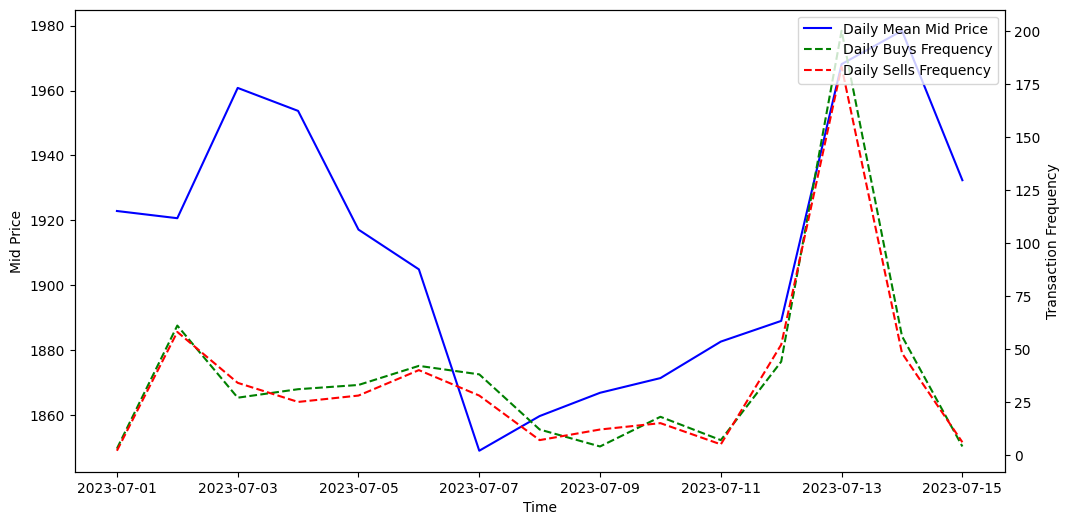

Spearman's Correlation Coefficient: 0.306 and P-value: 0.268


In [87]:
df['date'] = df.index.date
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2

daily_mid_price = df.groupby('date')['mid_prc'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(daily_mid_price.index, daily_mid_price.values, color='blue', label='Daily Mean Mid Price')
ax1.set_ylabel('Mid Price')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()
ax2.plot(daily_buys.index, daily_buys.values, color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_sells.index, daily_sells.values, color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Mid Price and Transaction Frequency Over Time'
plt.show()

daily_transaction_frequency = df.groupby('date').size()
spearman_corr, spearman_p_value = stats.spearmanr(daily_mid_price, daily_transaction_frequency)

print(f"Spearman's Correlation Coefficient: {spearman_corr:.3f} and P-value: {spearman_p_value:.3f}")

Initial inspection shows that while the frequency of buying and selling follows the same trend as `mid_prc` (mean of bid and ask price), the correlation is not statistically significant. To me, this makes sense since the strategy is a market making strategy which needs to continue trading and providing liquidity regardless of the mid price.

#### Mean Reverting Behaviour from Mid Price

In this section, I will investigate if the strategy exhibits mean reverting behaviour from the fill price.

The first pattern I want to explore is the frequency of buying and selling as the price of the asset fluctuations. The goal of this investigation is to explore if the strategy exhibits any mean reversion behaviour. To maximize profitability, I hypothesize the strategy will make more buys when the price of the asset falls below the mean and sell more when the price of the asset rises above the mean.

First, let us plot the distribution of the `mid_prc`. I am using `mid_prc` because it more reflects the general market sentiment of what the asset is worth.

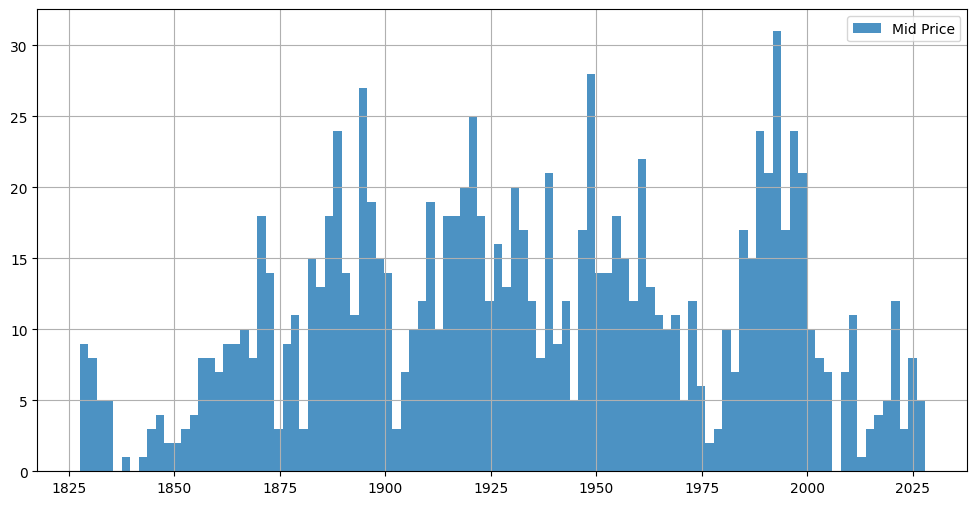

Shapiro-Wilk Test for mid_prc:
Statistics=0.977, p=0.000


In [88]:

fig, ax = plt.subplots(figsize=(12, 6))
df['mid_prc'].hist(bins=100, alpha=0.8, ax=ax, label='Mid Price')
ax.set_xlabel = 'Mid Price'
ax.set_ylabel = 'Frequency'
plt.title = 'Distribution of Mid Price'
ax.legend()
plt.show()

stat, p = shapiro(df['mid_prc'])
print("Shapiro-Wilk Test for mid_prc:")
print(f"Statistics={stat:.3f}, p={p:.3f}")

Note that `mid_prc` is not normally distributed. I want an estimate of the mean and standard deviation of the `mid_prc` to see if the strategy is buying and selling around the mean, and the behaviour of the strategy at the standard deviation. To accomplish this, I will use the CLT estimate I calculated earlier.

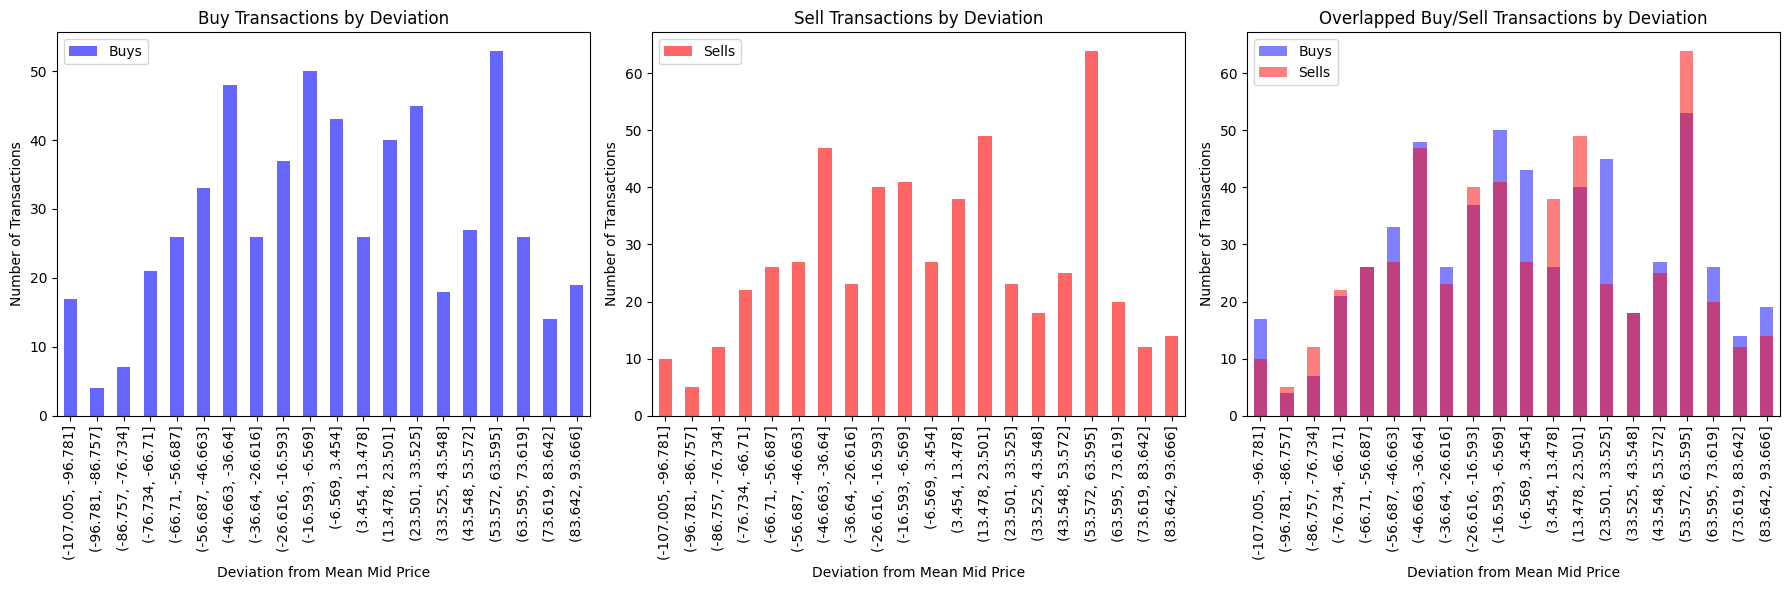

In [89]:
# I will take the estimate mean Mid price as the midpoint of the confidence interval
mean_mid_prc = (lower_bound_mid_prc + upper_bound_mid_prc) / 2
# Potentially a more accurate estimate from testing and iterating
# mean_mid_price = ((mean_mid_price - 26.168) - (mean_mid_price - 46.317)) / 2
std_mid_price = df['mid_prc'].std()

df['deviation_from_mean_mid_prc'] = df['mid_prc'] - mean_mid_prc
df['deviation_category'] = pd.cut(df['deviation_from_mean_mid_prc'], bins=20)

buy_counts = df[df['side'] == 'B'].groupby('deviation_category').size()
sell_counts = df[df['side'] == 'S'].groupby('deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot buy counts
buy_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Deviation')
axes[0].set_xlabel('Deviation from Mean Mid Price')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Plot sell counts
sell_counts.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Deviation')
axes[1].set_xlabel('Deviation from Mean Mid Price')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Plot overlapped buy and sell counts
buy_counts.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Buy/Sell Transactions by Deviation')
axes[2].set_xlabel('Deviation from Mean Mid Price')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()

In [90]:
# Transactions above and below deviation of 0
buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] > 0)].shape[0]
sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] > 0)].shape[0]

buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] < 0)].shape[0]
sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] < 0)].shape[0]

# How many times buys and sells exceed each other above and below deviation of 0
print(f"Buys above deviation: {buys_above_deviation}, Sells above deviation: {sells_above_deviation}")
print(f"Buys below deviation: {buys_below_deviation}, Sells below deviation: {sells_below_deviation}")

buys_exceed_sells_above = buys_above_deviation > sells_above_deviation
buys_exceed_sells_below = buys_below_deviation > sells_below_deviation

print(f"Do we buy more than we sell when the deviation is above 0?: {buys_exceed_sells_above}")
print(f"Do we buy more than we sell when the deviation is below 0?: {buys_exceed_sells_below}")

# Calculating, for each deviation category, when does buy exceed sell and vice versa above and below the mean
combined_counts = pd.DataFrame({'Buys': buy_counts, 'Sells': sell_counts}).fillna(0)

combined_counts['Buys_Exceed'] = combined_counts['Buys'] > combined_counts['Sells']
combined_counts['Sells_Exceed'] = combined_counts['Sells'] > combined_counts['Buys']

below_zero_categories = [i for i in combined_counts.index if i.left < 0]
buys_exceed_below_zero = combined_counts.loc[below_zero_categories]['Buys_Exceed'].sum()
sells_exceed_below_zero = combined_counts.loc[below_zero_categories]['Sells_Exceed'].sum()

above_zero_categories = [i for i in combined_counts.index if i.right > 0]
buys_exceed_above_zero = combined_counts.loc[above_zero_categories]['Buys_Exceed'].sum()
sells_exceed_above_zero = combined_counts.loc[above_zero_categories]['Sells_Exceed'].sum()

print(f"Times buys exceed sells for deviation < 0: {buys_exceed_below_zero}")
print(f"Times sells exceed buys for deviation < 0: {sells_exceed_below_zero}")
print(f"Times buys exceed sells for deviation > 0: {buys_exceed_above_zero}")
print(f"Times sells exceed buys for deviation > 0: {sells_exceed_above_zero}")

Buys above deviation: 278, Sells above deviation: 269
Buys below deviation: 302, Sells below deviation: 274
Do we buy more than we sell when the deviation is above 0?: True
Do we buy more than we sell when the deviation is below 0?: True
Times buys exceed sells for deviation < 0: 6
Times sells exceed buys for deviation < 0: 4
Times buys exceed sells for deviation > 0: 6
Times sells exceed buys for deviation > 0: 3


In [91]:
# Convert 'side' to a binary variable where 'B' is 1 and 'S' is 0
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})

# Logistic regression mean_from_mid_prc_model
X = sm.add_constant(df[['deviation_from_mean_mid_prc']])
y = df['side_binary']

mean_from_mid_prc_model = sm.Logit(y, X).fit()

print(mean_from_mid_prc_model.summary())

Optimization terminated successfully.
         Current function value: 0.692587
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:               2.470e-05
Time:                        19:30:46   Log-Likelihood:                -777.78
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                    0.8446
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0659      0.060      1.104      0.269   

Observing the plots and its results, we can see that even if the price of the asset is far above or below the mean, the strategy is still buying and selling in both directions. Initially, I hypothesized that the strategy would buy more when the price of the asset is below the mean and sell more when the price of the asset is above the mean. However, the logistic regression model shows that the deviation from the mean `mid_prc` is not statistically significant to the strategy's decision to buy or sell, leading me to conclude that the strategy does not exhibit a mean reversion behaviour. 

Thinking about this more, this result makes sense because a market making strategy must continue to trade regardless of the price of the asset to provide liquidity. From an evaluation standpoint, this is a good sign as it means that the strategy is serving its purpose as a market maker.

I want to dig a little deeper and investigate if `fill_qty` of the strategy's buying and selling is influenced by the deviation from the mean of `mid_prc`. I am choosing `fill_qty` because it represents the quantity of the asset the strategy is buying and selling.

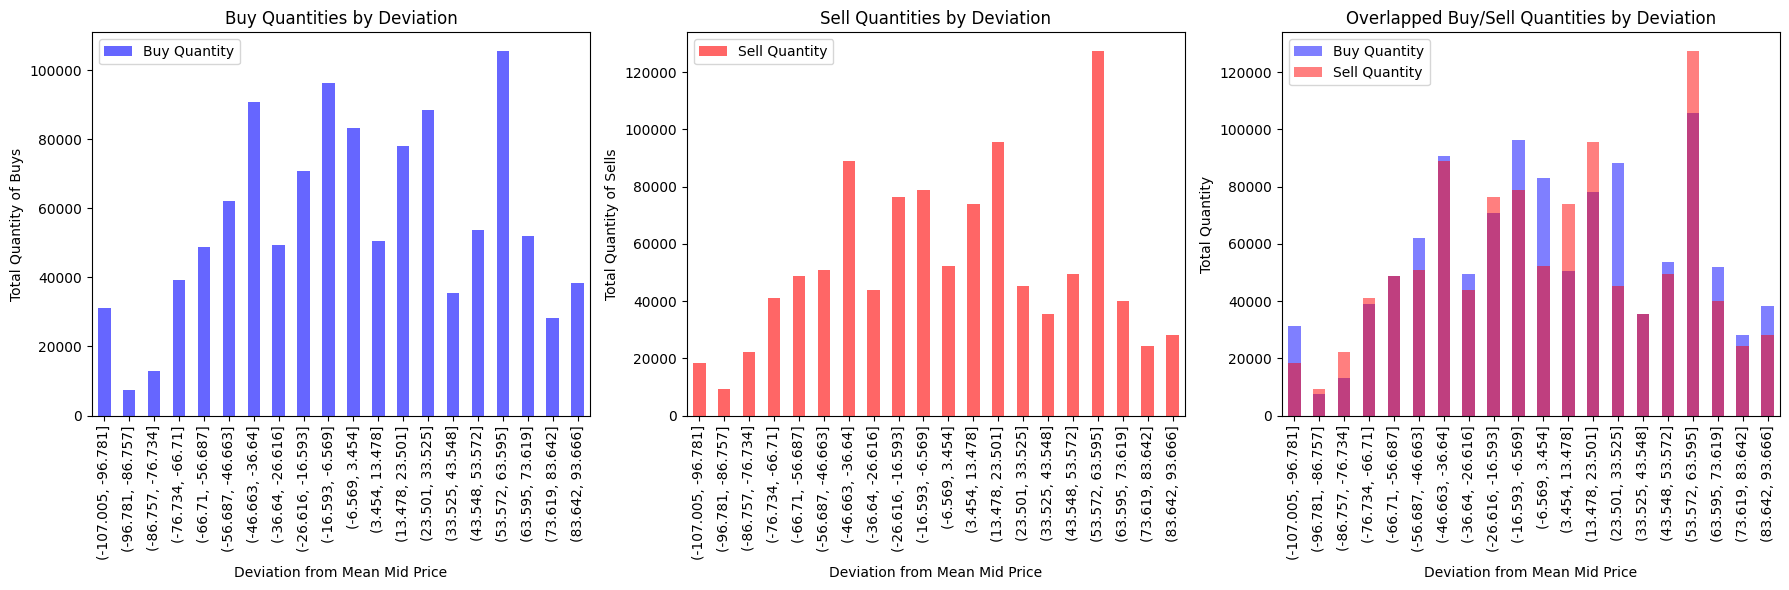

In [92]:
buy_qty_sum = df[df['side'] == 'B'].groupby('deviation_category')['mid_prc'].sum()
sell_qty_sum = df[df['side'] == 'S'].groupby('deviation_category')['mid_prc'].sum()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot buy quantities by deviation category
buy_qty_sum.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buy Quantity')
axes[0].set_title('Buy Quantities by Deviation')
axes[0].set_xlabel('Deviation from Mean Mid Price')
axes[0].set_ylabel('Total Quantity of Buys')
axes[0].legend()

# Plot sell quantities by deviation category
sell_qty_sum.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sell Quantity')
axes[1].set_title('Sell Quantities by Deviation')
axes[1].set_xlabel('Deviation from Mean Mid Price')
axes[1].set_ylabel('Total Quantity of Sells')
axes[1].legend()

# Plot overlapped buy and sell quantities by deviation category
buy_qty_sum.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buy Quantity')
sell_qty_sum.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sell Quantity')
axes[2].set_title('Overlapped Buy/Sell Quantities by Deviation')
axes[2].set_xlabel('Deviation from Mean Mid Price')
axes[2].set_ylabel('Total Quantity')
axes[2].legend()

plt.tight_layout()
plt.show()


In [93]:
# Calculate the total quantity of buys and sells above and below the mean deviation
total_qty_buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] > 0)]['fill_qty'].sum()
total_qty_sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] > 0)]['fill_qty'].sum()

total_qty_buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] < 0)]['fill_qty'].sum()
total_qty_sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] < 0)]['fill_qty'].sum()

print(f"Total quantity of buys above mean deviation: {total_qty_buys_above_deviation}")
print(f"Total quantity of sells above mean deviation: {total_qty_sells_above_deviation}")
print(f"Total quantity of buys below mean deviation: {total_qty_buys_below_deviation}")
print(f"Total quantity of sells below mean deviation: {total_qty_sells_below_deviation}")

qty_buys_exceed_sells_above = total_qty_buys_above_deviation > total_qty_sells_above_deviation
qty_buys_exceed_sells_below = total_qty_buys_below_deviation > total_qty_sells_below_deviation

print("\nDo we buy in greater quantity than we sell when the deviation is above 0?:", qty_buys_exceed_sells_above)
print("Do we buy in greater quantity than we sell when the deviation is below 0?:", qty_buys_exceed_sells_below)

buy_fill_qty = df[(df['side'] == 'B')]['fill_qty']
buy_deviation = df[(df['side'] == 'B')]['deviation_from_mean_mid_prc']
sell_fill_qty = df[(df['side'] == 'S')]['fill_qty']
sell_deviation = df[(df['side'] == 'S')]['deviation_from_mean_mid_prc']

spearman_buy, spearman_p_value_buy = stats.spearmanr(buy_fill_qty, buy_deviation)
spearman_sell, spearman_p_value_sell = stats.spearmanr(sell_fill_qty, sell_deviation)
print(f"Buy Quantity and Deviation Spearman Correlation: {spearman_buy}, P-value: {spearman_p_value_buy}")
print(f"Sell Quantity and Deviation Spearman Correlation: {spearman_sell}, P-value: {spearman_p_value_sell}")

Total quantity of buys above mean deviation: 18.2943
Total quantity of sells above mean deviation: 18.987000000000002
Total quantity of buys below mean deviation: 21.142400000000002
Total quantity of sells below mean deviation: 20.3093

Do we buy in greater quantity than we sell when the deviation is above 0?: False
Do we buy in greater quantity than we sell when the deviation is below 0?: True
Buy Quantity and Deviation Spearman Correlation: -0.09511175892391964, P-value: 0.02197218710945007
Sell Quantity and Deviation Spearman Correlation: 0.045581057840938376, P-value: 0.2890310268072977


The results here are more refined. The results of the Spearman correlation partially proves my initial hypothesis that the strategy makes more purchases when the price of the asset deviates below the mean, and by implication, makes less purchases when the price of the asset deviates above the mean. However, while the correlation is not strong, it is statistically significant. In terms of the behaviour of the strategy, it is aware of the price of the asset and makes buy decisions based on the price of the asset. A good explanation for this is that the market making strategy takes advantage of low prices and buys more assets during the time. This way, the strategy can increase its profitability if the price of the asset rise and maintain a healthy inventory level at a lower cost.

However, with regards to selling, the statistical result show that there is no statistically significant correlation between deviation of the price of the asset from its mean with the quantity of sell orders fulfilled. To me, this is a very interesting behaviour of the strategy. While this contradicts my initial hypothesis about the strategy's selling behaviour, the result makes sense considering this is a market making strategy and it must continue to provide liquidity and fulfill sell orders regardless of the price of the asset.

#### Mean Reverting Behaviour from Inventory Balance

Reading the problem statement closer, we are told that the market make around a target inventory. This leads me to hypothesize that the strategy should exhibit mean reverting behaviour on the inventory balance to maintain a target inventory.

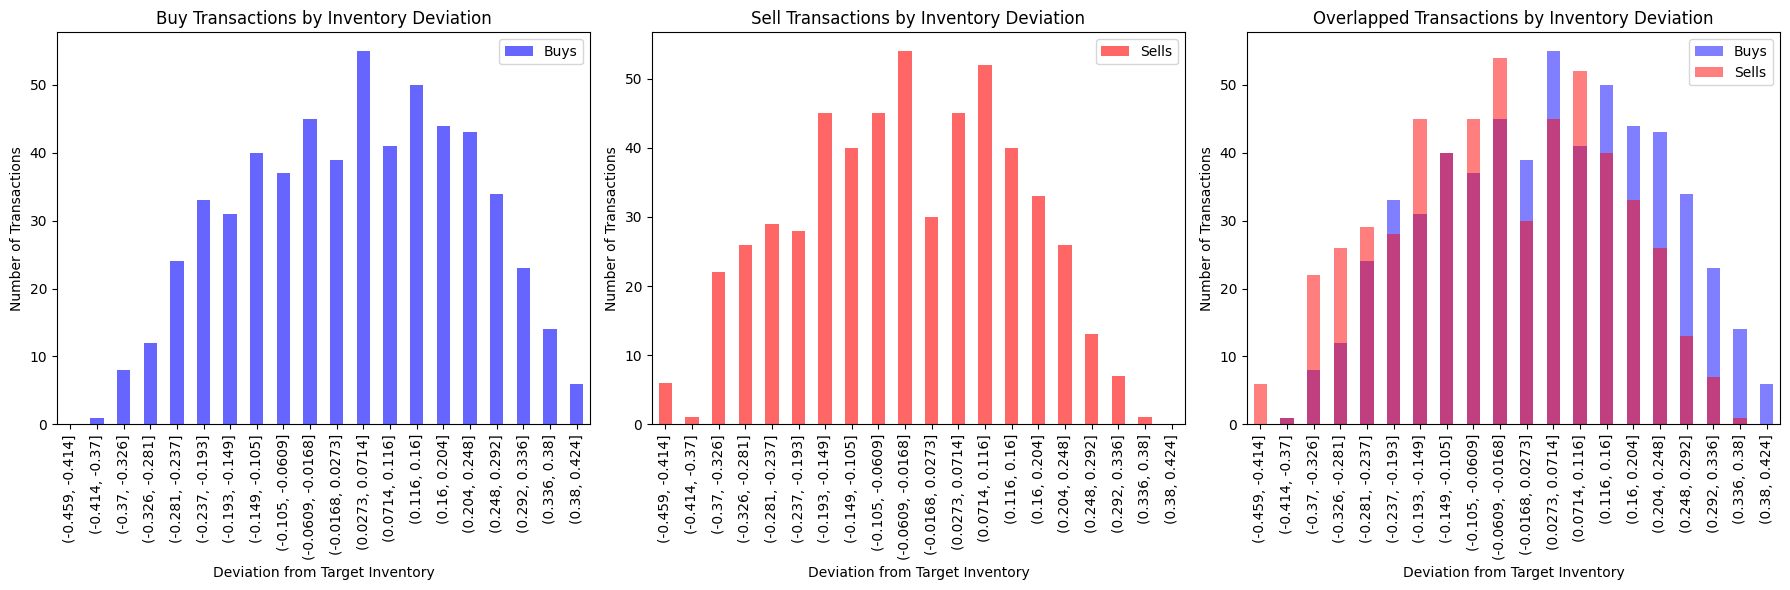

In [94]:
# Since I estimated the mean inventory balance before, I will use it again here.
df['deviation_from_target_inventory'] = df['balance'] - target_inventory
df['inventory_deviation_category'] = pd.cut(df['deviation_from_target_inventory'], bins=20)

buy_counts_inventory = df[df['side'] == 'B'].groupby('inventory_deviation_category').size()
sell_counts_inventory = df[df['side'] == 'S'].groupby('inventory_deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Buys based on deviation from target inventory
buy_counts_inventory.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Inventory Deviation')
axes[0].set_xlabel('Deviation from Target Inventory')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Sells based on deviation from target inventory
sell_counts_inventory.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Inventory Deviation')
axes[1].set_xlabel('Deviation from Target Inventory')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Overlapped Buys and Sells
buy_counts_inventory.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts_inventory.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Transactions by Inventory Deviation')
axes[2].set_xlabel('Deviation from Target Inventory')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()


In [95]:
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})
X_new = sm.add_constant(df[['deviation_from_target_inventory']])
y = df['side_binary']

mean_from_inventory_balance_model = sm.Logit(y, X_new).fit()

print(mean_from_inventory_balance_model.summary())

Optimization terminated successfully.
         Current function value: 0.673438
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                 0.02767
Time:                        19:30:47   Log-Likelihood:                -756.27
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                 5.342e-11
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0688      0.061      1.130  

Observing the plots and logistic regression model, while my intuition was correct that there is a correlation between deviance from mean inventory balance and buying and selling, the results show that it is in the opposite direction of what I predicted. This result is very interesting to me because one interpretation of this result is that as the inventory balance deviates higher from the mean, we make more buy orders, and as the inventory balance deviates lower from the mean, we make more sell orders. This implies that the inventory balance of the strategy will not revert to a mean, but will continue to grow or shrink, which is a result I did not expect. 

Let me investigate further and see if there is a pattern in the quantity of buy and sell orders with deviation from the mean inventory balance.

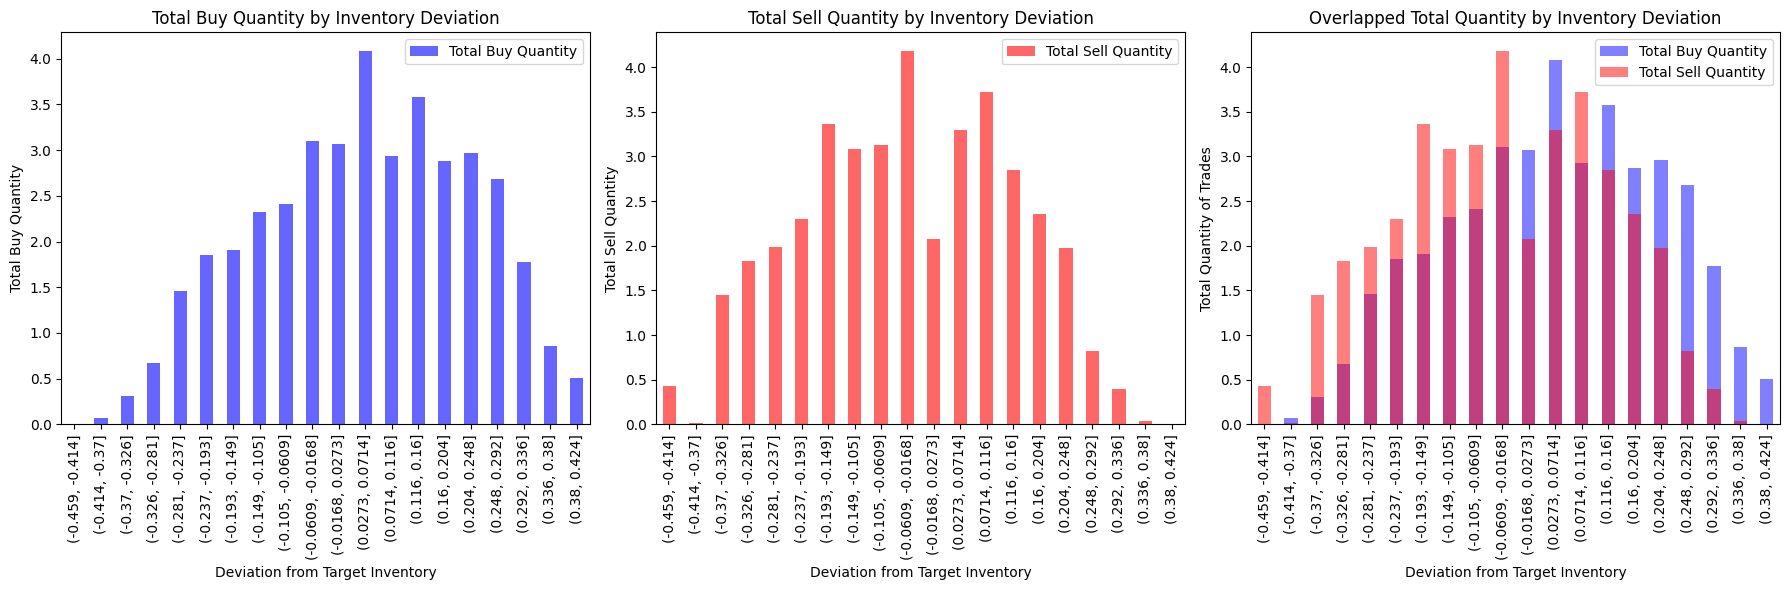

In [96]:
total_buy_qty_inventory = df[df['side'] == 'B'].groupby('inventory_deviation_category')['fill_qty'].sum()
total_sell_qty_inventory = df[df['side'] == 'S'].groupby('inventory_deviation_category')['fill_qty'].sum()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

total_buy_qty_inventory.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Total Buy Quantity')
axes[0].set_title('Total Buy Quantity by Inventory Deviation')
axes[0].set_xlabel('Deviation from Target Inventory')
axes[0].set_ylabel('Total Buy Quantity')
axes[0].legend()

total_sell_qty_inventory.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Total Sell Quantity')
axes[1].set_title('Total Sell Quantity by Inventory Deviation')
axes[1].set_xlabel('Deviation from Target Inventory')
axes[1].set_ylabel('Total Sell Quantity')
axes[1].legend()

total_buy_qty_inventory.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Total Buy Quantity')
total_sell_qty_inventory.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Total Sell Quantity')
axes[2].set_title('Overlapped Total Quantity by Inventory Deviation')
axes[2].set_xlabel('Deviation from Target Inventory')
axes[2].set_ylabel('Total Quantity of Trades')
axes[2].legend()

plt.tight_layout()
plt.show()

In [97]:
total_qty_buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_target_inventory'] > 0)]['fill_qty'].sum()
total_qty_sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_target_inventory'] > 0)]['fill_qty'].sum()

total_qty_buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_target_inventory'] < 0)]['fill_qty'].sum()
total_qty_sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_target_inventory'] < 0)]['fill_qty'].sum()

print(f"Total quantity of buys above mean deviation: {total_qty_buys_above_deviation}")
print(f"Total quantity of sells above mean deviation: {total_qty_sells_above_deviation}")
print(f"Total quantity of buys below mean deviation: {total_qty_buys_below_deviation}")
print(f"Total quantity of sells below mean deviation: {total_qty_sells_below_deviation}")

# Spearman Correlation tests
buy_fill_qty = df[df['side'] == 'B']['fill_qty']
buy_deviation = df[df['side'] == 'B']['deviation_from_target_inventory']
sell_fill_qty = df[df['side'] == 'S']['fill_qty']
sell_deviation = df[df['side'] == 'S']['deviation_from_target_inventory']

# Ensure that we only include rows where buy_deviation and sell_deviation are not null.
buy_fill_qty = buy_fill_qty[buy_deviation.notnull()]
buy_deviation = buy_deviation[buy_deviation.notnull()]
sell_fill_qty = sell_fill_qty[sell_deviation.notnull()]
sell_deviation = sell_deviation[sell_deviation.notnull()]

# Perform Spearman correlation tests
spearman_corr_buy = stats.spearmanr(buy_fill_qty, buy_deviation)
spearman_corr_sell = stats.spearmanr(sell_fill_qty, sell_deviation)

print(f"Spearman Correlation - Buy Quantity and Deviation: {spearman_corr_buy.correlation}, P-value: {spearman_corr_buy.pvalue}")
print(f"Spearman Correlation - Sell Quantity and Deviation: {spearman_corr_sell.correlation}, P-value: {spearman_corr_sell.pvalue}")

Total quantity of buys above mean deviation: 24.5049
Total quantity of sells above mean deviation: 16.817700000000002
Total quantity of buys below mean deviation: 14.931799999999999
Total quantity of sells below mean deviation: 22.4786
Spearman Correlation - Buy Quantity and Deviation: 0.07817226507512798, P-value: 0.05990992712066586
Spearman Correlation - Sell Quantity and Deviation: -0.01969708692681926, P-value: 0.6469701679212501


Here, the results of the Spearman tests are very surprising to me. The tests contradict my initial hypothesis that the behaviour of the strategy is influenced by the deviation from the mean inventory balance. Some reasons this might be the case might be:

1. I estimated the wrong mean inventory balance. This is a possibility as I estimated the mean inventory balance using the entire dataset. It is possible that the strategy has a target inventory balance that is not the mean of the entire dataset.
2. While the strategy does market make around a target inventory, as stated in the problem statement, deviation from the mean inventory balance may not be the variable the strategy uses to make decision on this matter.

To make further investigation on this, I will need more clarify on the target inventory balance of the strategy and if my estimate of the mean inventory balance is correct.

#### Trading Patterns by Deviation from Fill Quantity

In this section, I want to investigate if the strategy's trading patterns are influenced by the deviation from the fill quantity. With this investigation, I intend to find out if the strategy is more likely to buy or sell when the fill quantity is high or low. 

In [98]:
def estimate_sample_mean(df, feature, n_samples=1122, sample_size=30):
    sample_means = [df[feature].sample(sample_size, replace=True).mean() for _ in range(n_samples)]
    mean_of_sample_means = np.mean(sample_means)
    return mean_of_sample_means

In [99]:
df = merged_data.copy()

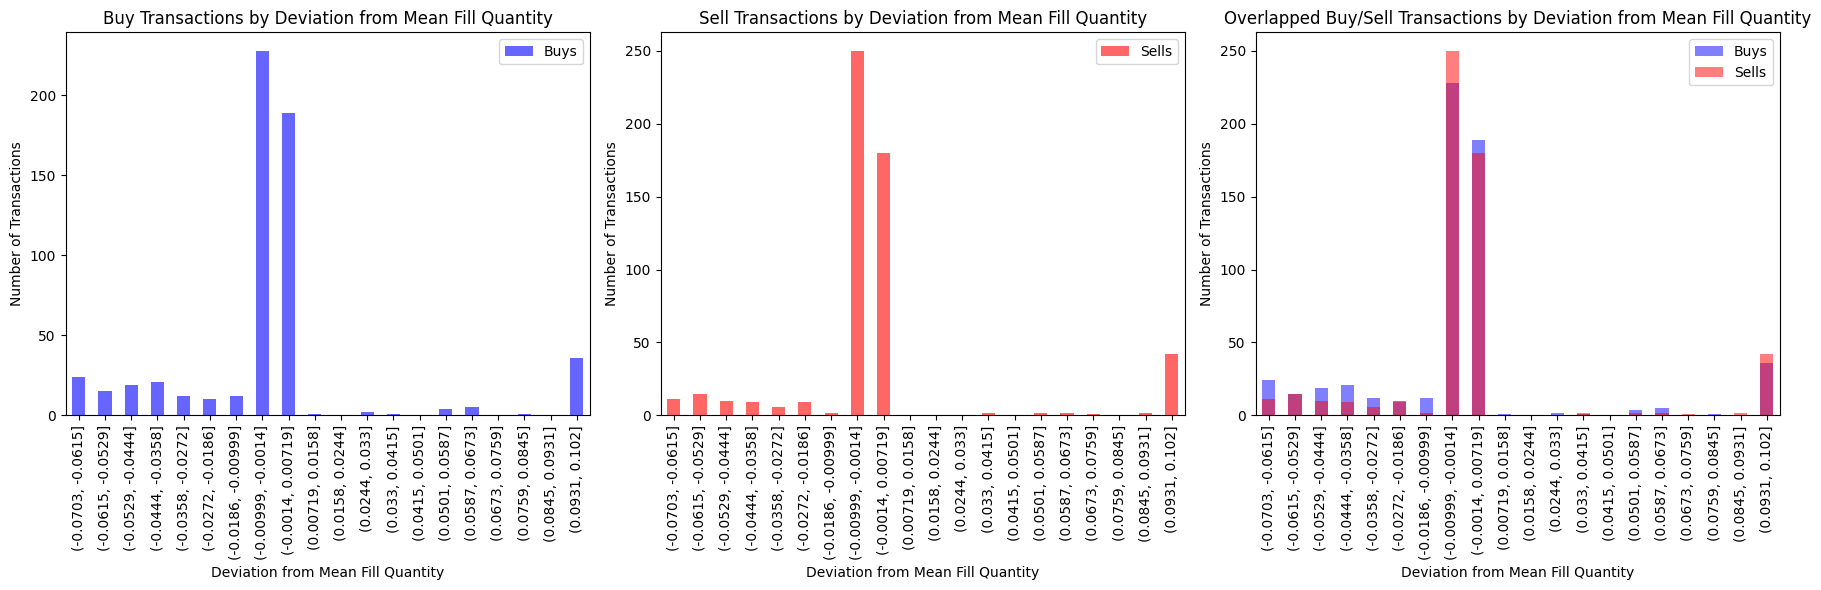

In [100]:
mean_fill_quantity = estimate_sample_mean(df, 'fill_qty')
df['deviation_from_mean_fill_qty'] = df['fill_qty'] - mean_fill_quantity
df['deviation_category'] = pd.cut(df['deviation_from_mean_fill_qty'], bins=20)

buy_counts = df[df['side'] == 'B'].groupby('deviation_category').size()
sell_counts = df[df['side'] == 'S'].groupby('deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot buy counts
buy_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Deviation from Mean Fill Quantity')
axes[0].set_xlabel('Deviation from Mean Fill Quantity')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Plot sell counts
sell_counts.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Deviation from Mean Fill Quantity')
axes[1].set_xlabel('Deviation from Mean Fill Quantity')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Plot overlapped buy and sell counts
buy_counts.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Buy/Sell Transactions by Deviation from Mean Fill Quantity')
axes[2].set_xlabel('Deviation from Mean Fill Quantity')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()


In [101]:
# Transactions above and below deviation of 0
buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_fill_qty'] > 0)].shape[0]
sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_fill_qty'] > 0)].shape[0]

buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_fill_qty'] < 0)].shape[0]
sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_fill_qty'] < 0)].shape[0]

# Display transactions above and below deviation
print(f"Buys above deviation: {buys_above_deviation}, Sells above deviation: {sells_above_deviation}")
print(f"Buys below deviation: {buys_below_deviation}, Sells below deviation: {sells_below_deviation}")

buys_exceed_sells_above = buys_above_deviation > sells_above_deviation
buys_exceed_sells_below = buys_below_deviation > sells_below_deviation

# Print whether buys exceed sells for deviations above and below 0
print(f"Do we buy more than we sell when the deviation is above 0?: {buys_exceed_sells_above}")
print(f"Do we buy more than we sell when the deviation is below 0?: {buys_exceed_sells_below}")

# Calculate when buys exceed sells for each deviation category
combined_counts = pd.DataFrame({'Buys': buy_counts, 'Sells': sell_counts}).fillna(0)
combined_counts['Buys_Exceed'] = combined_counts['Buys'] > combined_counts['Sells']
combined_counts['Sells_Exceed'] = combined_counts['Sells'] > combined_counts['Buys']

below_zero_categories = [i for i in combined_counts.index if i.left < 0]
buys_exceed_below_zero = combined_counts.loc[below_zero_categories]['Buys_Exceed'].sum()
sells_exceed_below_zero = combined_counts.loc[below_zero_categories]['Sells_Exceed'].sum()

above_zero_categories = [i for i in combined_counts.index if i.right > 0]
buys_exceed_above_zero = combined_counts.loc[above_zero_categories]['Buys_Exceed'].sum()
sells_exceed_above_zero = combined_counts.loc[above_zero_categories]['Sells_Exceed'].sum()

print(f"Times buys exceed sells for deviation < 0: {buys_exceed_below_zero}")
print(f"Times sells exceed buys for deviation < 0: {sells_exceed_below_zero}")
print(f"Times buys exceed sells for deviation > 0: {buys_exceed_above_zero}")
print(f"Times sells exceed buys for deviation > 0: {sells_exceed_above_zero}")

Buys above deviation: 145, Sells above deviation: 123
Buys below deviation: 435, Sells below deviation: 420
Do we buy more than we sell when the deviation is above 0?: True
Do we buy more than we sell when the deviation is below 0?: True
Times buys exceed sells for deviation < 0: 7
Times sells exceed buys for deviation < 0: 1
Times buys exceed sells for deviation > 0: 6
Times sells exceed buys for deviation > 0: 4


In [102]:
# Convert 'side' to binary variable
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})

X = sm.add_constant(df[['deviation_from_mean_fill_qty']])
y = df['side_binary']

mean_from_fill_qty_model = sm.Logit(y, X).fit()

mean_from_fill_qty_model.summary()

Optimization terminated successfully.
         Current function value: 0.690523
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                0.003005
Time:                        19:30:48   Log-Likelihood:                -775.46
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                   0.03062
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0655      0.060      1.095      0.274      -0.052       0.183
deviation_from_mean_fill_qty    -3.8238      1.779     -2.149      0.032      -7.311      -0.336
================================================================================================
"""

To me, this is a surprising result as I did not expect deviation of the fill quantity from its mean would have a statisitcally significant relationship to buying or selling. Observing the plots, we can see that as deviation from the mean fill quantity increases, buying occurs less. On the other hand, as deviation from the mean fill quantity decreases, buying increases. This is supported by the negative coefficient of the logistic regression model. In other words, trades with fill quantities that are lower than the mean are more likely to be buys, and those with fill quantities higher than the mean are more likely to be sells.

One possible reasons I can think of that might explain this behaviour could be that the strategy is more likely to break down larger buy orders into smaller orders than it is to break down larger sell orders into smaller orders. A reason for this behaviour might be the strategy might want to discretely build a position in the asset, but meanwhile prefer to sell in larger quantities during a bear market to liquidate its position faster and avoid further losses.

#### Trading Patterns in Different Market Conditions

In this section, I want to investigate if the strategy exhibits different trading patterns in different market conditions. I will investigate the trading patterns of the strategy in bull, bear, and neutral markets.

Since this is a market making strategy revolving around a target inventory, I hypothesize that the strategy will make more sell orders during a bear market to quickly turn over inventory to avoid holding declining assets, mitigating losses. On the other hand, I hypothesize that the strategy will make more buy orders during a bull market to capitalize on the appreciation of the asset. 

In [103]:
df = merged_data.copy()

# Necessary for categorizing market condition
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

# From the previous analysis, we found that market condition, deviation from target inventory, deviation from mid price has a statistical significant impact on net pnl
df['market_condition'] = df.apply(categorize_market_condition, axis=1)

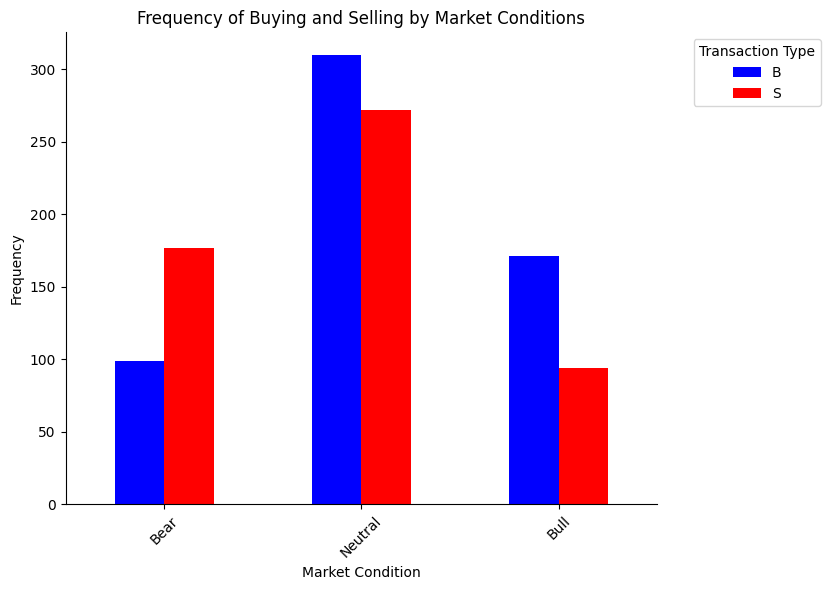

In [104]:
df['market_condition'] = pd.Categorical(df['market_condition'], categories=['Bear', 'Neutral', 'Bull'], ordered=True)

buy_sell_freq_by_market_cond = df.groupby('market_condition')['side'].value_counts().unstack()
buy_sell_freq_by_market_cond = buy_sell_freq_by_market_cond.reindex(['Bear', 'Neutral', 'Bull'])

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'red']
buy_sell_freq_by_market_cond.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Frequency of Buying and Selling by Market Conditions')
ax.set_xlabel('Market Condition')
ax.set_ylabel('Frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [105]:
buy_sell_freq_by_market_cond

side                B    S
market_condition          
Bear               99  177
Neutral           310  272
Bull              171   94

In [106]:
# Conduct a Chi-Squared test to see if the difference in frequencies is statistically significant
chi2, p, dof, expected = stats.chi2_contingency(buy_sell_freq_by_market_cond)

print(f"Chi2 statistic: {chi2}, P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies if no difference in market condition:\n{pd.DataFrame(expected, columns=buy_sell_freq_by_market_cond.columns, index=buy_sell_freq_by_market_cond.index)}")


Chi2 statistic: 45.728746890411735, P-value: 1.1752459968849416e-10
Degrees of freedom: 2
Expected frequencies if no difference in market condition:
side                       B           S
market_condition                        
Bear              142.546750  133.453250
Neutral           300.587711  281.412289
Bull              136.865539  128.134461


The Chi-squared test shows that the strategy indeed makes more buy orders during neutral and bull markets, and more sell orders during bear markets. This aligns with my initial hypothesis. This makes sense even with the result that the strategy fills more buy orders when the price falls below the mean price of the asset because I defined bear, neutral, and bull markets based on the percentage change of the asset price. An asset when the price is far below the mean can still have a high positive percentage change, and vice versa.

Note that my definition of bear, neutral, and bull market conditions stem from the definition of recession and growth in economics, which is when GDP growth is negative and positive respectively. 

I want to take it a step further an investigate if the quantity of buy and sell orders follows a similar pattern. This is because, just because we have more buy transactions, does not mean the total value of buy transactions is higher than the total value of sell transactions.

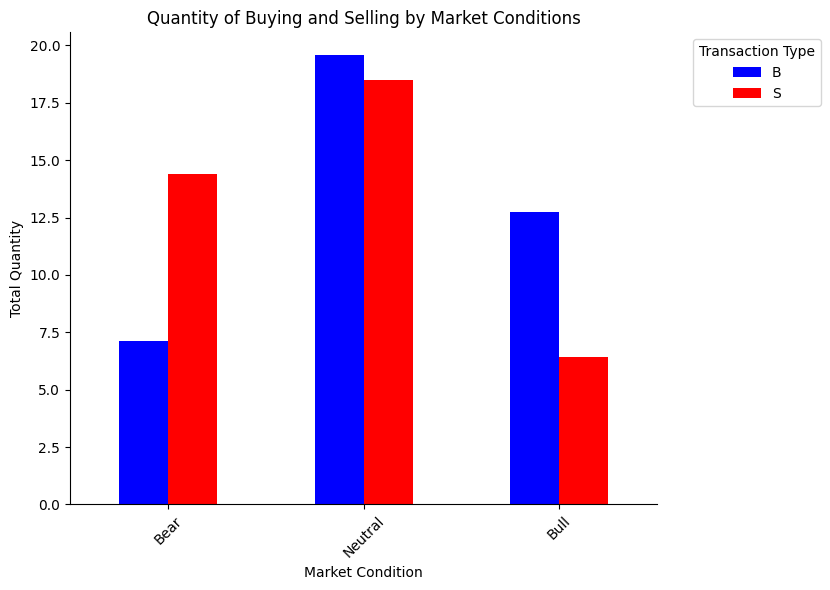

In [107]:
qty_by_market_cond_side = df.groupby(['market_condition', 'side'])['fill_qty'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
qty_by_market_cond_side.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Quantity of Buying and Selling by Market Conditions')
ax.set_xlabel('Market Condition')
ax.set_ylabel('Total Quantity')
ax.set_xticklabels(qty_by_market_cond_side.index.categories, rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [108]:
qty_by_market_cond_side

side                    B        S
market_condition                  
Bear               7.1154  14.3790
Neutral           19.5865  18.4913
Bull              12.7348   6.4260

In [109]:
buy_fill_qty_bear = df[(df['side'] == 'B') & (df['market_condition'] == 'Bear')]['fill_qty']
buy_fill_qty_neutral = df[(df['side'] == 'B') & (df['market_condition'] == 'Neutral')]['fill_qty']
buy_fill_qty_bull = df[(df['side'] == 'B') & (df['market_condition'] == 'Bull')]['fill_qty']

sell_fill_qty_bear = df[(df['side'] == 'S') & (df['market_condition'] == 'Bear')]['fill_qty']
sell_fill_qty_neutral = df[(df['side'] == 'S') & (df['market_condition'] == 'Neutral')]['fill_qty']
sell_fill_qty_bull = df[(df['side'] == 'S') & (df['market_condition'] == 'Bull')]['fill_qty']

# Use the Kruskal-Wallis H Test since we do not know the distribution of the data and it is continuous
kruskal_result_buys = kruskal(buy_fill_qty_bear, buy_fill_qty_neutral, buy_fill_qty_bull)
kruskal_result_sells = kruskal(sell_fill_qty_bear, sell_fill_qty_neutral, sell_fill_qty_bull)

print(f"Kruskal-Wallis H Test for Buys: Statistic = {kruskal_result_buys.statistic}, P-value = {kruskal_result_buys.pvalue}")
print(f"Kruskal-Wallis H Test for Sells: Statistic = {kruskal_result_sells.statistic}, P-value = {kruskal_result_sells.pvalue}")

Kruskal-Wallis H Test for Buys: Statistic = 7.653567870144326, P-value = 0.02177954755580384
Kruskal-Wallis H Test for Sells: Statistic = 12.610356866182848, P-value = 0.0018268201744904725


Similar to the results of the Chi-squared test, we find that market conditions do have a statistically significant impact on the quantity of buy and sell orders, indicating that it does effect the behaviour of the strategy. This aligns with the previous finding that market conditions have a statistically significant impact on the PnL of the trading strategy. This is an interesting result to me as it further consolidates my previous inferences about the strategy behaviour which is that to avoid further losses from holding declining assets, the strategy makes more sell orders during bear markets to quickly turn over inventory. On the other hand, during bull markets, the strategy makes more buy orders to capitalize on the appreciation of the asset.

#### Trading Patterns in Different Volatility Conditions

In this section, I will investigate the behaviour of the strategy in different volatility conditions. Here, I will use `mid_prc` to calculate volatility since it is more representative of the volatility of the general market.

In [110]:
df = merged_data.copy()
df['date'] = df.index.date
# Using `mid_prc` to calculate the volatility of the Mid Price.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
# The reason I am using `mid_prc` instead of the `mid_prc` is because `fill_pcr` data reflects the prices of buys and sells, so it is difficult to obtain a gauge the average trading volatility from this data.
mid_prc_daily_volatility = df.groupby('date')['mid_prc_pct_change'].std() * 100

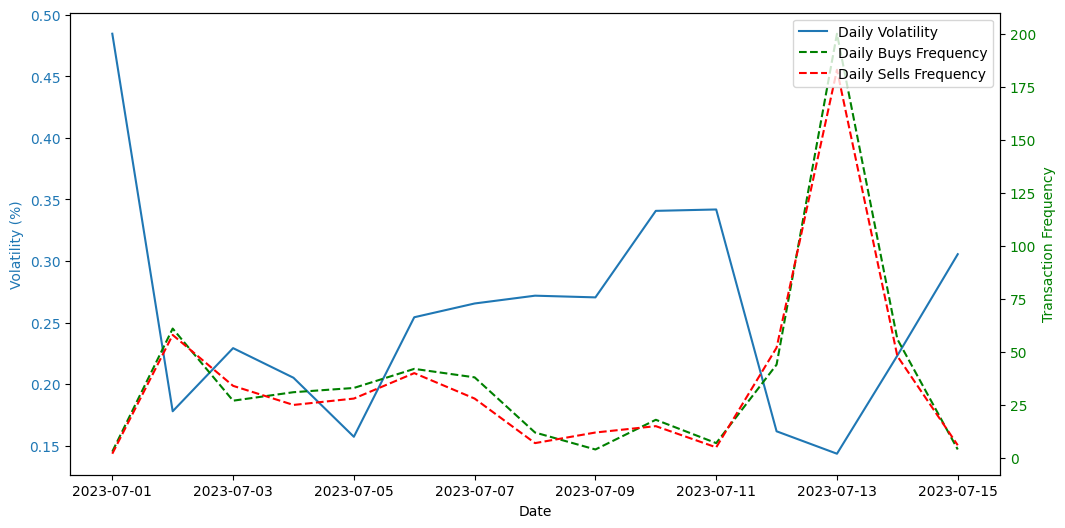

In [111]:
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data_volatility = pd.DataFrame({
    'volatility': mid_prc_daily_volatility,
    'buys': daily_buys,
    'sells': daily_sells
})

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data_volatility.index, daily_data_volatility['volatility'], color=color, label='Daily Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.plot(daily_data_volatility.index, daily_data_volatility['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data_volatility.index, daily_data_volatility['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Daily Volatility vs. Transaction Frequency Over Time'
plt.show()

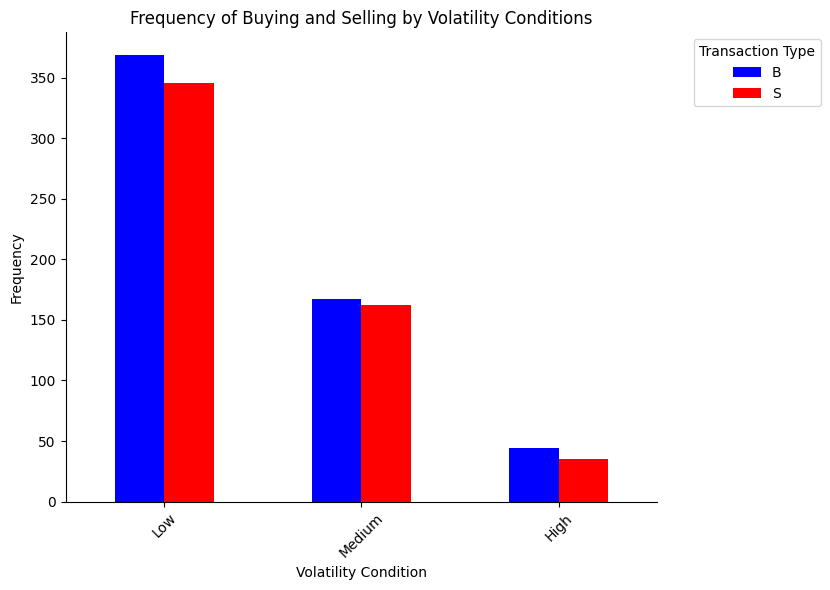

In [112]:
volatility_bins = pd.qcut(mid_prc_daily_volatility, q=3, labels=['Low', 'Medium', 'High'])
df['volatility_category'] = df['date'].map(volatility_bins)

buy_sell_freq_by_volatility = df.groupby('volatility_category')['side'].value_counts().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
buy_sell_freq_by_volatility.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Frequency of Buying and Selling by Volatility Conditions')
ax.set_xlabel('Volatility Condition')
ax.set_ylabel('Frequency')
ax.set_xticklabels(buy_sell_freq_by_volatility.index, rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [113]:
spearman_corr_buys, spearman_p_value_buys = spearmanr(daily_data_volatility['volatility'], daily_data_volatility['buys'])
spearman_corr_sells, spearman_p_value_sells = spearmanr(daily_data_volatility['volatility'], daily_data_volatility['sells'])

print(f"Spearman Correlation (Buys vs. Volatility): {spearman_corr_buys:.3f}, p-value: {spearman_p_value_buys:.3f}")
print(f"Spearman Correlation (Sells vs. Volatility): {spearman_corr_sells:.3f}, p-value: {spearman_p_value_sells:.3f}")

Spearman Correlation (Buys vs. Volatility): -0.826, p-value: 0.000
Spearman Correlation (Sells vs. Volatility): -0.860, p-value: 0.000


The plots and results of the Spearman tests show that volatility does have a statistically significant impact on the behaviour of the strategy. One interpretation of the results is that, while the strategy still trades in all volatility conditions (defined as market conditions in the previous section), it minimize positional risk, the strategy makes more trades during periods of low volatility and less trades during periods of high volatility. I believe a combination of asset price volatility and determination of the current market condition (bear, neutral, bull) serve as a key factor in the strategy's behaviour to buy or sell to maintain positional risk, which is a good way to ensure that the PnL of the strategy is not affected by short-term fluctuations in the market.

#### Trading Patterns in Different Liquidity (Spread)

In this section, I will investigate the effect of the bid-ask spread on the trading patterns of the strategy. Since this is a market making strategy which must continue to trade in all liquidity conditions, I suspect that there will be no statistically significant correlation between the bid-ask spread and the trading patterns of the strategy.

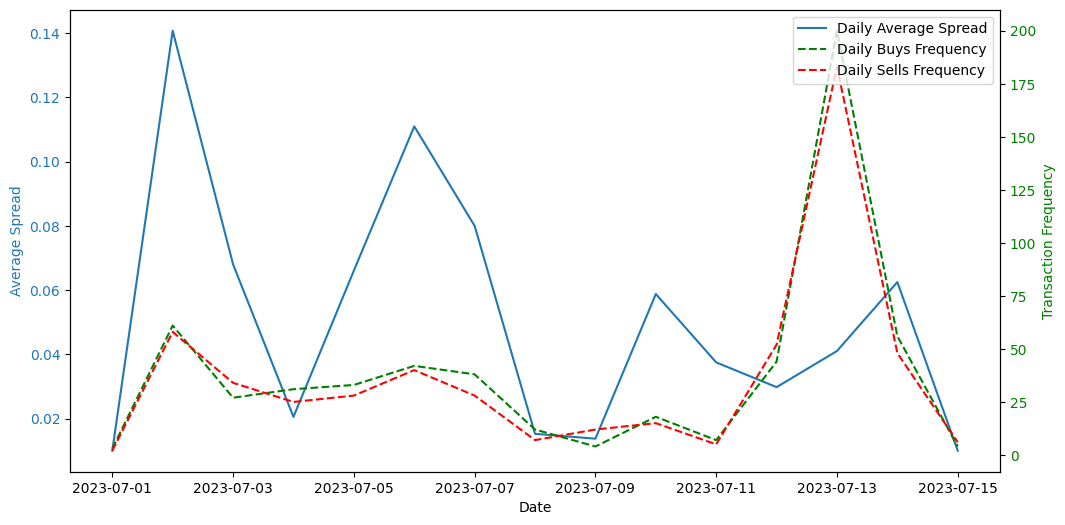

Spearman Correlation (Buys) and p-value: Correlation=0.693, p-value=0.004
Spearman Correlation (Sells) and p-value: Correlation=0.665, p-value=0.007


In [114]:
df = merged_data.copy()
df['date'] = df.index.date
df['spread'] = df['ask_prc'] - df['bid_prc']

daily_avg_spread = df.groupby('date')['spread'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data = pd.DataFrame({
    'avg_spread': daily_avg_spread,
    'buys': daily_buys,
    'sells': daily_sells
}).fillna(0)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data.index, daily_data['avg_spread'], color=color, label='Daily Average Spread')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Spread', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data.index, daily_data['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Spread vs. Transaction Frequency Over Time'
plt.show()

spearman_corr_buys, spearman_p_value_buys = stats.spearmanr(daily_data['avg_spread'], daily_data['buys'])
spearman_corr_sells, spearman_p_value_sells = stats.spearmanr(daily_data['avg_spread'], daily_data['sells'])

print(f"Spearman Correlation (Buys) and p-value: Correlation={spearman_corr_buys:.3f}, p-value={spearman_p_value_buys:.3f}")
print(f"Spearman Correlation (Sells) and p-value: Correlation={spearman_corr_sells:.3f}, p-value={spearman_p_value_sells:.3f}")

Surprisingly, the results of the Spearman correlations and p-values prove that my hypothesis was wrong. Bid-ask spread does have a statistically significant influence on the behaviour of the strategy. 

A higher bid-ask spread reflects lower volume of demand, therefore influencing wider discrepancies in its price. This indicates that while the asset is less liquid, the discrepencies in prices is an opportunity for arbitrage. Thinking about bid-ask spreads in this way, it makes sense for the strategy to behave and trade more actively during periods of higher spread and lower liquidity to take advanatage of potential arbitrage opportunities.

#### Trading Patterns by Trading Fees

In this section, I had the idea to investigate if the trading fees have an impact on the trading patterns of the strategy. I hypothesize that the trading fees do have an impact on the trading patterns of the strategy to maintain lower costs.

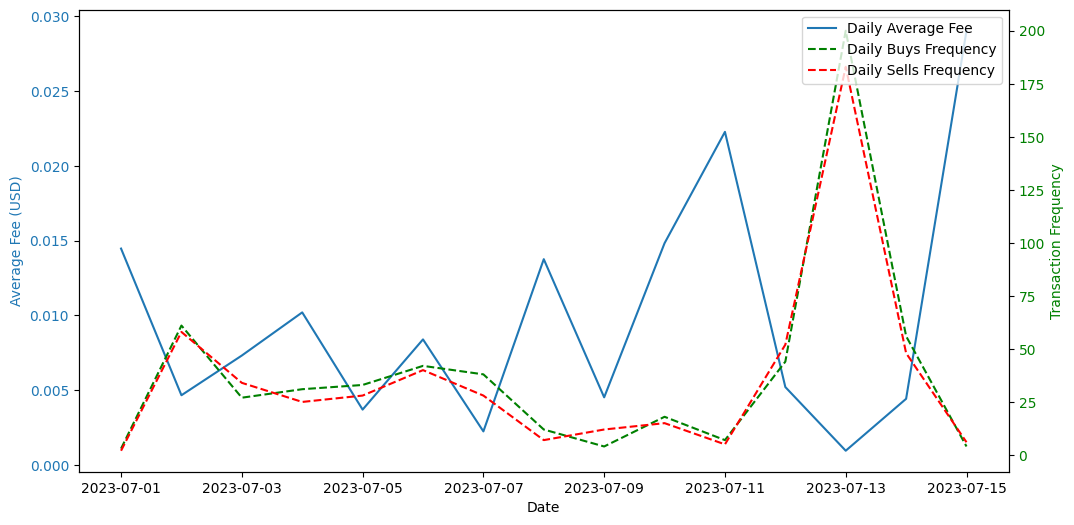

Spearman Correlation (Buys) and p-value: Correlation=-0.686, p-value=0.005
Spearman Correlation (Sells) and p-value: Correlation=-0.710, p-value=0.003


In [115]:
df['total_fee'] = df['fee'] * df['fee_ccy_usd_rate']

daily_avg_fee = df.groupby('date')['total_fee'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data_fees = pd.DataFrame({
    'avg_fee': daily_avg_fee,
    'buys': daily_buys,
    'sells': daily_sells
})

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data_fees.index, daily_data_fees['avg_fee'], color=color, label='Daily Average Fee')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Fee (USD)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.plot(daily_data_fees.index, daily_data_fees['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data_fees.index, daily_data_fees['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Fees vs. Transaction Frequency Over Time'
plt.show()

# Step 4: Spearman Correlation Analysis
spearman_corr_buys_fee, spearman_p_value_buys_fee = stats.spearmanr(daily_data_fees['avg_fee'], daily_data_fees['buys'])
spearman_corr_sells_fee, spearman_p_value_sells_fee = stats.spearmanr(daily_data_fees['avg_fee'], daily_data_fees['sells'])

print(f"Spearman Correlation (Buys) and p-value: Correlation={spearman_corr_buys_fee:.3f}, p-value={spearman_p_value_buys_fee:.3f}")
print(f"Spearman Correlation (Sells) and p-value: Correlation={spearman_corr_sells_fee:.3f}, p-value={spearman_p_value_sells_fee:.3f}")

In [116]:
highest_fee = df['total_fee'].max()
print(f"{highest_fee:.2f}")

0.08


The results of the plot and Spearman test show that the trading fees do have a statistically significant impact on the behaviour of the strategy, confirming my hypothesis. From observing the graph and the Spearman correlation, we can see that trading fees have a negative impact on the strategy's frequency of buying and selling. This makes sense because higher trading fees reflect higher variable costs to the trade, reducing PnL, which is not ideal. As a result, the strategy may be programmed to take advantage of trades with lower fees and avoid trades with higher fees to maintain profitability. In fact, this result aligns with the IceBerg orders we observed in the `fills_data` dataset, which are large orders that are broken down into smaller orders to avoid large fees. 

If we assume that the highest trading fee in the data set is the maximum trading fee before the strategy splits the order into smaller orders, then it may be that `0.08` USD is the critical value before the strategy splits the order into IceBerg orders to avoid higher fees. This is just a speculation, and I would need more information to confirm this such as more data entries to confirm if there may be trades with trading fees higher than `0.08` USD as a counter example.

### Implementing Classification Models

In this section, I want to build a decision tree, random forest, and logistic regression model to classify when the strategy buys and sells and compare their results. The goal of my classification models is not to build a predictive model for when the strategy buys and sells, but to see if the models can provide further insight into the trading patterns of the strategy.

The reason I am implementing classification models is because I believe the question of investigating the behaviour of the strategy can be rephrased to the problem of developing a classification model which can determine if the strategy buys or sells based on the features of the data. By investigating the classification models, I can identify which features are correlated with the strategy's decision to buy or sell and see if it is consistent with my previous analysis.

In [117]:
# First I must prepare the dataset
df = merged_data.copy()

In [118]:
# remove pnl related columns and more since I am interested in determining if the trade is likely to be a buy or sell
df.drop(['order_id', 'fee_ccy', 'fill_id', 'symbol_x', 'exch', 'symbol_y', 'trade_pnl', 'cumulative_trade_pnl',
        'inventory_pnl', 'cumulative_inventory_pnl', 'net_pnl', 'cumulative_net_pnl'], axis=1, inplace=True)

In [119]:
# add features to the dataset that I believe will be useful in predicting the trade type
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
df['market_condition'] = df.apply(categorize_market_condition, axis=1)
df['spread'] = df['ask_prc'] - df['bid_prc']
df['total_fee'] = df['fee'] * df['fee_ccy_usd_rate']

# prune out overlapping features
# removing balance and balance value since we identified deviation from balance is not significant
df = df.drop(['bid_prc', 'ask_prc', 'fee', 'fee_ccy_usd_rate', 'balance_value', 'mid_prc_pct_change', 'balance', 'liquidity', 'fill_prc'], axis=1)
# add dummy encoding for market_condition
df = pd.get_dummies(df, columns=['market_condition'])
# remove first row since it will have NaN values
df = df.iloc[1:]
df

side  fill_qty   mid_prc  spread  total_fee  \
timestamp                                                                
2023-07-01 06:52:59.387733    B    0.0264  1921.735    0.01   0.000000   
2023-07-01 09:19:52.809436    B    0.0707  1915.365    0.01   0.000000   
2023-07-01 10:16:21.048157    B    0.1719  1917.325    0.01   0.072353   
2023-07-01 14:37:25.452850    S    0.1719  1921.865    0.01   0.000000   
2023-07-02 00:15:18.613260    B    0.0693  1922.915    0.01   0.000000   
...                         ...       ...       ...     ...        ...   
2023-07-15 16:18:25.726018    B    0.1719  1932.345    0.01   0.077660   
2023-07-15 16:19:06.461829    B    0.1719  1932.345    0.01   0.077660   
2023-07-15 18:39:02.613882    S    0.0670  1932.345    0.01   0.000000   
2023-07-15 18:39:02.614281    S    0.0674  1932.345    0.01   0.000000   
2023-07-15 19:04:52.935896    B    0.0666  1932.345    0.01   0.000000   

                            market_condition_Bear  market_condition_Bull  \
timestamp                                                                  
2023-07-01 06:52:59.387733                   True                  False   
2023-07-01 09:19:52.809436                   True                  False   
2023-07-01 10:16:21.048157                  False                   True   
2023-07-01 14:37:25.452850                  False                   True   
2023-07-02 00:15:18.613260                  False                   True   
...                                           ...                    ...   
2023-07-15 16:18:25.726018                  False                  False   
2023-07-15 16:19:06.461829                  False                  False   
2023-07-15 18:39:02.613882                  False                  False   
2023-07-15 18:39:02.614281                  False                  False   
2023-07-15 19:04:52.935896                  False                  False   

                            market_condition_Neutral  
timestamp                                             
2023-07-01 06:52:59.387733                     False  
2023-07-01 09:19:52.809436                     False  
2023-07-01 10:16:21.048157                     False  
2023-07-01 14:37:25.452850                     False  
2023-07-02 00:15:18.613260                     False  
...                                              ...  
2023-07-15 16:18:25.726018                      True  
2023-07-15 16:19:06.461829                      True  
2023-07-15 18:39:02.613882                      True  
2023-07-15 18:39:02.614281                      True  
2023-07-15 19:04:52.935896                      True  

[1122 rows x 8 columns]

In [120]:
# Since I am more interested in the relationships 
# in the data than the accuracy of the model,
# I thought engineering my features to be categorical 
# would help serve my purpose best.
mean_fill_qty = estimate_sample_mean(df, 'fill_qty')
mean_mid_prc = estimate_sample_mean(df, 'mid_prc')
mean_spread = estimate_sample_mean(df, 'spread')

df['deviation_from_mean_fill_qty'] = df['fill_qty'] - mean_fill_qty
df['deviation_from_mean_mid_prc'] = df['mid_prc'] - mean_mid_prc
df['deviation_from_mean_spread'] = df['spread'] - mean_spread
df['is_total_fee_zero'] = (df['total_fee'] == 0).astype(int)

categorical_columns = ['market_condition_Bear', 'market_condition_Bull', 'market_condition_Neutral']

for col in categorical_columns:
    df[col] = df[col].astype('category').cat.codes

columns_to_drop = ['fill_qty', 'mid_prc', 'spread', 'total_fee']
df.drop(columns=columns_to_drop, inplace=True)

df

side  market_condition_Bear  market_condition_Bull  \
timestamp                                                                       
2023-07-01 06:52:59.387733    B                      1                      0   
2023-07-01 09:19:52.809436    B                      1                      0   
2023-07-01 10:16:21.048157    B                      0                      1   
2023-07-01 14:37:25.452850    S                      0                      1   
2023-07-02 00:15:18.613260    B                      0                      1   
...                         ...                    ...                    ...   
2023-07-15 16:18:25.726018    B                      0                      0   
2023-07-15 16:19:06.461829    B                      0                      0   
2023-07-15 18:39:02.613882    S                      0                      0   
2023-07-15 18:39:02.614281    S                      0                      0   
2023-07-15 19:04:52.935896    B                      0                      0   

                            market_condition_Neutral  \
timestamp                                              
2023-07-01 06:52:59.387733                         0   
2023-07-01 09:19:52.809436                         0   
2023-07-01 10:16:21.048157                         0   
2023-07-01 14:37:25.452850                         0   
2023-07-02 00:15:18.613260                         0   
...                                              ...   
2023-07-15 16:18:25.726018                         1   
2023-07-15 16:19:06.461829                         1   
2023-07-15 18:39:02.613882                         1   
2023-07-15 18:39:02.614281                         1   
2023-07-15 19:04:52.935896                         1   

                            deviation_from_mean_fill_qty  \
timestamp                                                  
2023-07-01 06:52:59.387733                     -0.043578   
2023-07-01 09:19:52.809436                      0.000722   
2023-07-01 10:16:21.048157                      0.101922   
2023-07-01 14:37:25.452850                      0.101922   
2023-07-02 00:15:18.613260                     -0.000678   
...                                                  ...   
2023-07-15 16:18:25.726018                      0.101922   
2023-07-15 16:19:06.461829                      0.101922   
2023-07-15 18:39:02.613882                     -0.002978   
2023-07-15 18:39:02.614281                     -0.002578   
2023-07-15 19:04:52.935896                     -0.003378   

                            deviation_from_mean_mid_prc  \
timestamp                                                 
2023-07-01 06:52:59.387733                   -12.347461   
2023-07-01 09:19:52.809436                   -18.717461   
2023-07-01 10:16:21.048157                   -16.757461   
2023-07-01 14:37:25.452850                   -12.217461   
2023-07-02 00:15:18.613260                   -11.167461   
...                                                 ...   
2023-07-15 16:18:25.726018                    -1.737461   
2023-07-15 16:19:06.461829                    -1.737461   
2023-07-15 18:39:02.613882                    -1.737461   
2023-07-15 18:39:02.614281                    -1.737461   
2023-07-15 19:04:52.935896                    -1.737461   

                            deviation_from_mean_spread  is_total_fee_zero  
timestamp                                                                  
2023-07-01 06:52:59.387733                    -0.05224                  1  
2023-07-01 09:19:52.809436                    -0.05224                  1  
2023-07-01 10:16:21.048157                    -0.05224                  0  
2023-07-01 14:37:25.452850                    -0.05224                  1  
2023-07-02 00:15:18.613260                    -0.05224                  1  
...                                                ...                ...  
2023-07-15 16:18:25.726018                    -0.05224                  0  
2023-07-15 

In [121]:
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})
y = df['side_binary']
X = df.drop(columns=['side', 'side_binary'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Decision Tree

In [122]:
clf = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': range(1, 20)}

# Identify the ideal depth of the tree
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best tree depth:", grid_search.best_params_['max_depth'])

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {decision_tree_accuracy * 100:.2f}%")


Best tree depth: 1
Test set accuracy: 59.05%


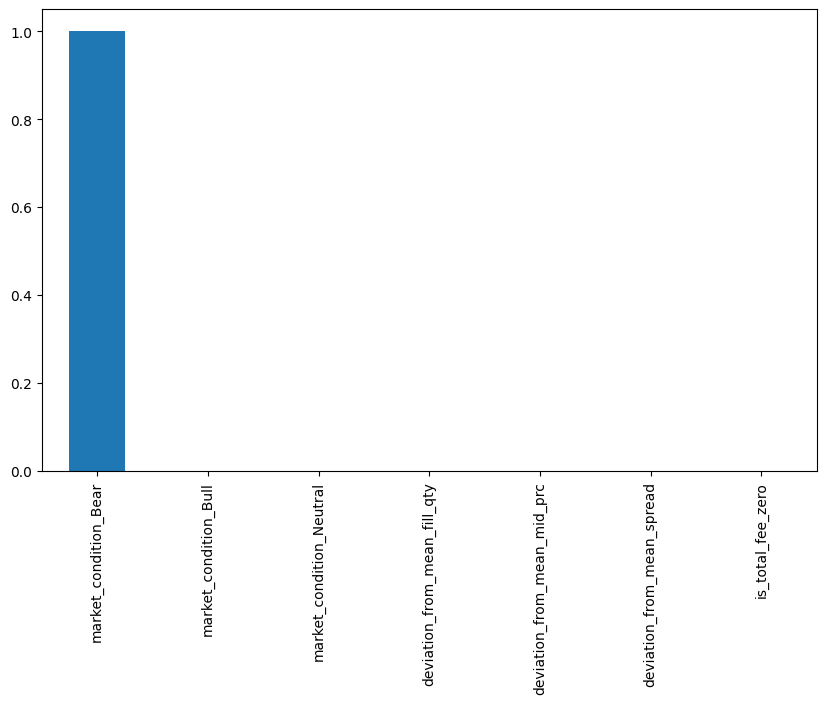

In [123]:
feature_importances = best_clf.feature_importances_
importances = pd.Series(feature_importances, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title = 'Feature Importance in Decision Tree'
plt.ylabel = 'Importance Score'
plt.xlabe = 'Features'
plt.show()

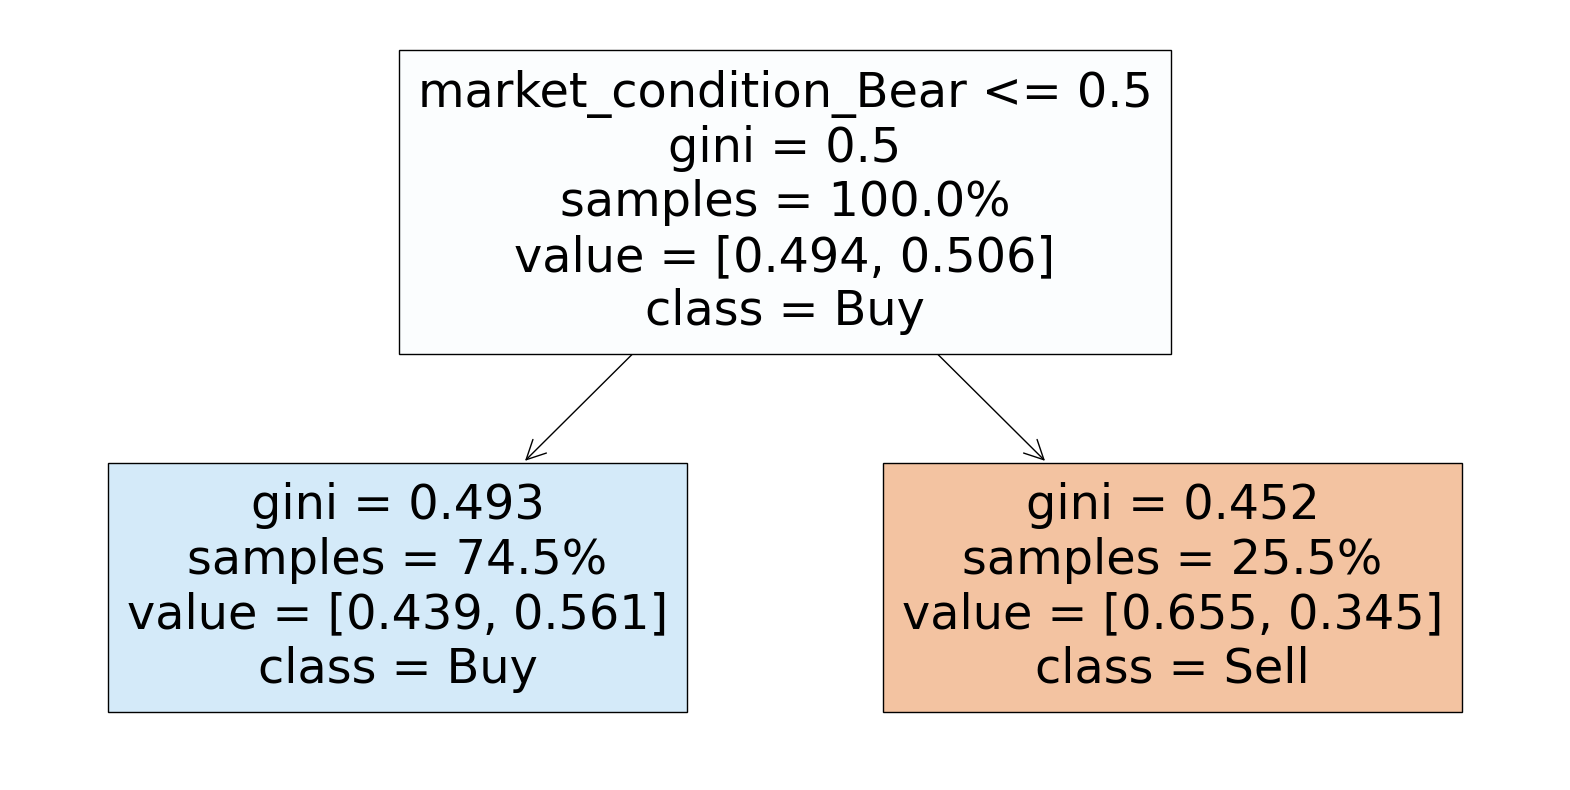

In [124]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=['Sell', 'Buy'], proportion=True)
plt.show()

Observing the results of the decision tree model, we can see that the model has a  poor performance of `59.05%`. Furthermore, the decision tree's optimum depth is a max depth of 1, which means it makes a decision by only asking one question. In this case, the question is whether the market condition is bearish `(market_condition_Bear <= 0.5)`. However, even after the branching, the Gini impurity is still high, indicating that the decision tree is not able to classify the data well. This is a sign that the decision tree model is not able to capture the information in the data well.

The only point of interest in the decision tree model is the samples percentages, which shows the proportion of total samples that went to each side of the split. 74.5% of the samples have a `market_condition_Bear` value of less than or equal to 0.5 and are classified as Buy, while the remaining 25.5% are classified as Sell. This means when the market condition is not bearish, the strategy is more likely to buy. This coincides with the findings when we identified trading patterns in different market conditions and found that buys occur the least in bear markets.

#### Random Forest

In [125]:
number_of_variables = X_train.shape[1]
random_forest_errors = np.zeros(number_of_variables)
oob_scores = []

for variable_count in range(1, number_of_variables + 1):
    # Train a random forest model with a varying number of variables (max_features)
    clf = RandomForestClassifier(n_estimators=500, max_features=variable_count, oob_score=True, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    oob_error = 1 - clf.oob_score_
    random_forest_errors[variable_count - 1] = oob_error
    oob_scores.append(clf.oob_score_)

optimal_variables = np.argmin(random_forest_errors) + 1  # Adding 1 because index starts at 0
print(f"Optimal number of variables (max_features): {optimal_variables}")

optimal_clf = RandomForestClassifier(n_estimators=500, max_features=optimal_variables, oob_score=True, random_state=42, n_jobs=-1)
optimal_clf.fit(X_train, y_train)

y_pred = optimal_clf.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {random_forest_accuracy * 100:.2f}%")

Optimal number of variables (max_features): 1
Accuracy on test set: 60.24%


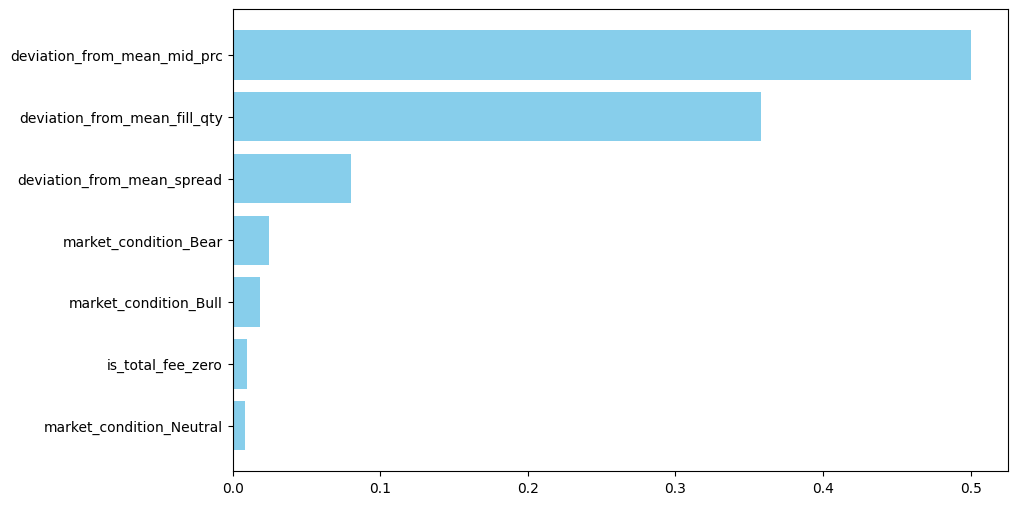

In [126]:
feature_importances = optimal_clf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel = 'Importance'
plt.title= 'Feature Importances in RandomForest Classifier'
plt.gca().invert_yaxis()
plt.show()

The random forest model has a better performance of `62.61%` than the decision tree model. However, the performance is still not high as I would want it to be. The model identified that the optimal number of variables is 7 with `deviation_from_mean_mid_prc`, and `deviation_from_mean_fill_qty` being the top two most important features according to the random forest model. This is interesting to me because market conditions is not one of the top most important features, which differs from the decision tree model. Perhaps the combination of these two features, `deviation_from_mean_mid_prc`, and `deviation_from_mean_fill_qty`, reveal a pattern for a trading discount or market trends that a simple decision tree model cannot capture.

#### Logistic Regression

In [127]:
X_train_const = sm.add_constant(X_train)

logistic_model = sm.Logit(y_train, X_train_const).fit()
p_value_threshold = 0.05
while True:
    p_values = logistic_model.pvalues
    p_values = p_values.drop('const')  # Ignore the intercept's p-value for this process
    max_p_value = p_values.max()
    if max_p_value < p_value_threshold:
        break  # Stop if all p-values are below the threshold
    else:
        # Remove the feature with the highest p-value
        feature_to_remove = p_values.idxmax()
        X_train_const = X_train_const.drop(columns=[feature_to_remove])
        logistic_model = sm.Logit(y_train, X_train_const).fit(disp=0)  # Refit logistic_model without the feature
        print(f"Removed: {feature_to_remove}, Refitting logistic_model...\n")

print("Final logistic_model:")
print(logistic_model.summary())

X_test_const = sm.add_constant(X_test[X_train_const.columns[1:]], has_constant='add')
y_pred_prob = logistic_model.predict(X_test_const)

# Compute the accuracy
logistic_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of logistic model: {logistic_accuracy * 100:.2f}%")

Optimization terminated successfully.
         Current function value: 0.669530
         Iterations 6
Removed: deviation_from_mean_spread, Refitting logistic_model...

Removed: deviation_from_mean_mid_prc, Refitting logistic_model...

Removed: is_total_fee_zero, Refitting logistic_model...

Removed: deviation_from_mean_fill_qty, Refitting logistic_model...

Removed: market_condition_Neutral, Refitting logistic_model...

Final logistic_model:
                           Logit Regression Results                           
Dep. Variable:            side_binary   No. Observations:                  785
Model:                          Logit   Df Residuals:                      782
Method:                           MLE   Df Model:                            2
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                 0.03097
Time:                        19:30:54   Log-Likelihood:                -527.22
converged:                       True   LL-Null:                       -544.07
C

In [128]:

logistic_intercept = logistic_model.params[0]
logistic_coefficients = logistic_model.params[1:]

logistic_equation = f"logit(P) = {logistic_intercept:.4f} + "
logistic_equation += " + ".join([f"{coef:.4f} * {feat}" for feat, coef in zip(logistic_coefficients.index, logistic_coefficients.values)])

logistic_equation


'logit(P) = 0.1137 + -0.7548 * market_condition_Bear + 0.4328 * market_condition_Bull'

The logistic regression's p-value, `4.809e-08`, indicates that the model is statistically significant with an accuracy of `62.61%`. However, it has a Pseudo R-squared value of `0.03097`, which is really low. This means that though the model has some predictive power, there is a lot of room for improvement. 

Observing the coefficients of the logistic regression model, `const` has a log-odds of `0.1137`, which translates to a probability of about `52.8%` on my calculator, telling is that the strategy is slightly more likely to buy than sell during neutral market conditions, which is similar to what we found in our analysis on trading patterns by market conditions. The negative coefficient on `market_condition_Bear` and positive coefficient on `market_condition_Bull` tells us that the strategy is more likely to sell during bear markets and buy during bull markets. This is also consistent with our previous analysis on trading patterns by market conditions. Again, the p-value of the model tells us this relationship is statistically significant. However, the R-squared value of the model is low, indicating that the model does not explain a lot of the variance in the data. Ideally, I would like access to more features like external market data to see if the trading strategy pairs (i.e pairs trading) with external market data to make decisions.

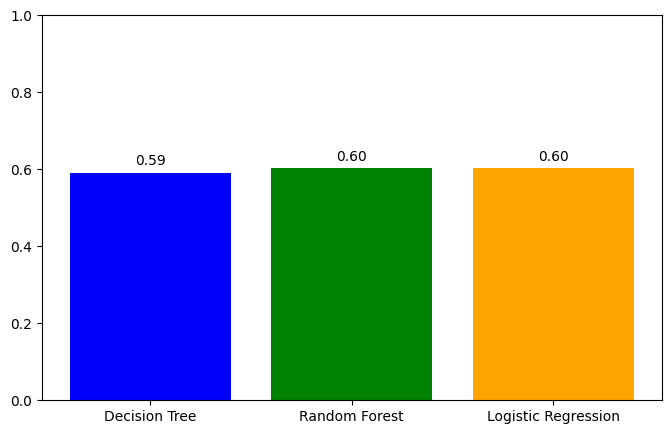

In [129]:
accuracy_dt = decision_tree_accuracy  
accuracy_rf = random_forest_accuracy  
accuracy_logreg = logistic_accuracy 

models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [accuracy_dt, accuracy_rf, accuracy_logreg]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel = 'Model'
plt.ylabel = 'Accuracy'
plt.title = 'Comparison of Model Accuracies'
plt.ylim(0, 1) 
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

Here, we can see that the random forest and logistic regression models have similar performance despite prioritizing different features. For future work, I would like to investigate if the combination of the features identified by the random forest model and the logistic regression model can improve the performance of the models.

## Deeper Dive on Market Impact: Investigating the impact of the trading strategy on the market

In this section, I will investigate the impact of the strategy on the market. The main question I will be answering here is to figure out what tends to happen to the market prices after a fill happens.

In [130]:
market_df = market_data.copy()
df = merged_data.copy()

### Investigating Average Price Changes after Order Fills 

In this section, I want to investigate the average price change of the asset after the strategy makes a fill. As a premilimary step, I will investigate the average price change in the mid price after the strategy makes a fill.


In [131]:
# Calculate the effect of a fill on the market price by getting the 1 minute window price change after a fill occurs
market_df = market_df.sort_index()
df = df.sort_index()
df.index = df.index.tz_localize(None)
market_df.index = market_df.index.tz_localize(None)
time_window = pd.Timedelta(minutes=1)
price_change_fill_effect = []
price_pct_change_fill_effect = []

for idx, row in df.iterrows():
    end_time = idx + time_window
    post_fill_market_data = market_df.loc[idx:end_time]
    
    # Calculate the price change if there is any market data in the window
    if not post_fill_market_data.empty:
        initial_mid_price = (row['bid_prc'] + row['ask_prc']) / 2
        final_mid_price = (post_fill_market_data.iloc[-1]['bid_prc'] + post_fill_market_data.iloc[-1]['ask_prc']) / 2
        price_change = final_mid_price - initial_mid_price
    else:
        # If no market data is available in the window, use NA
        price_change = pd.NA
    
    price_change_fill_effect.append(price_change)

df['fill_effect_on_prc'] = price_change_fill_effect

for idx, row in df.iterrows():
    end_time = idx + time_window
    post_fill_market_data = market_df.loc[idx:end_time]
    
    if not post_fill_market_data.empty:
        initial_mid_price = (row['bid_prc'] + row['ask_prc']) / 2
        final_mid_price = (post_fill_market_data.iloc[-1]['bid_prc'] + post_fill_market_data.iloc[-1]['ask_prc']) / 2
        # Calculate percentage price change instead of absolute price change
        price_change = ((final_mid_price - initial_mid_price) / initial_mid_price) * 100
    else:
        price_change = pd.NA 
    
    price_pct_change_fill_effect.append(price_change)

df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect


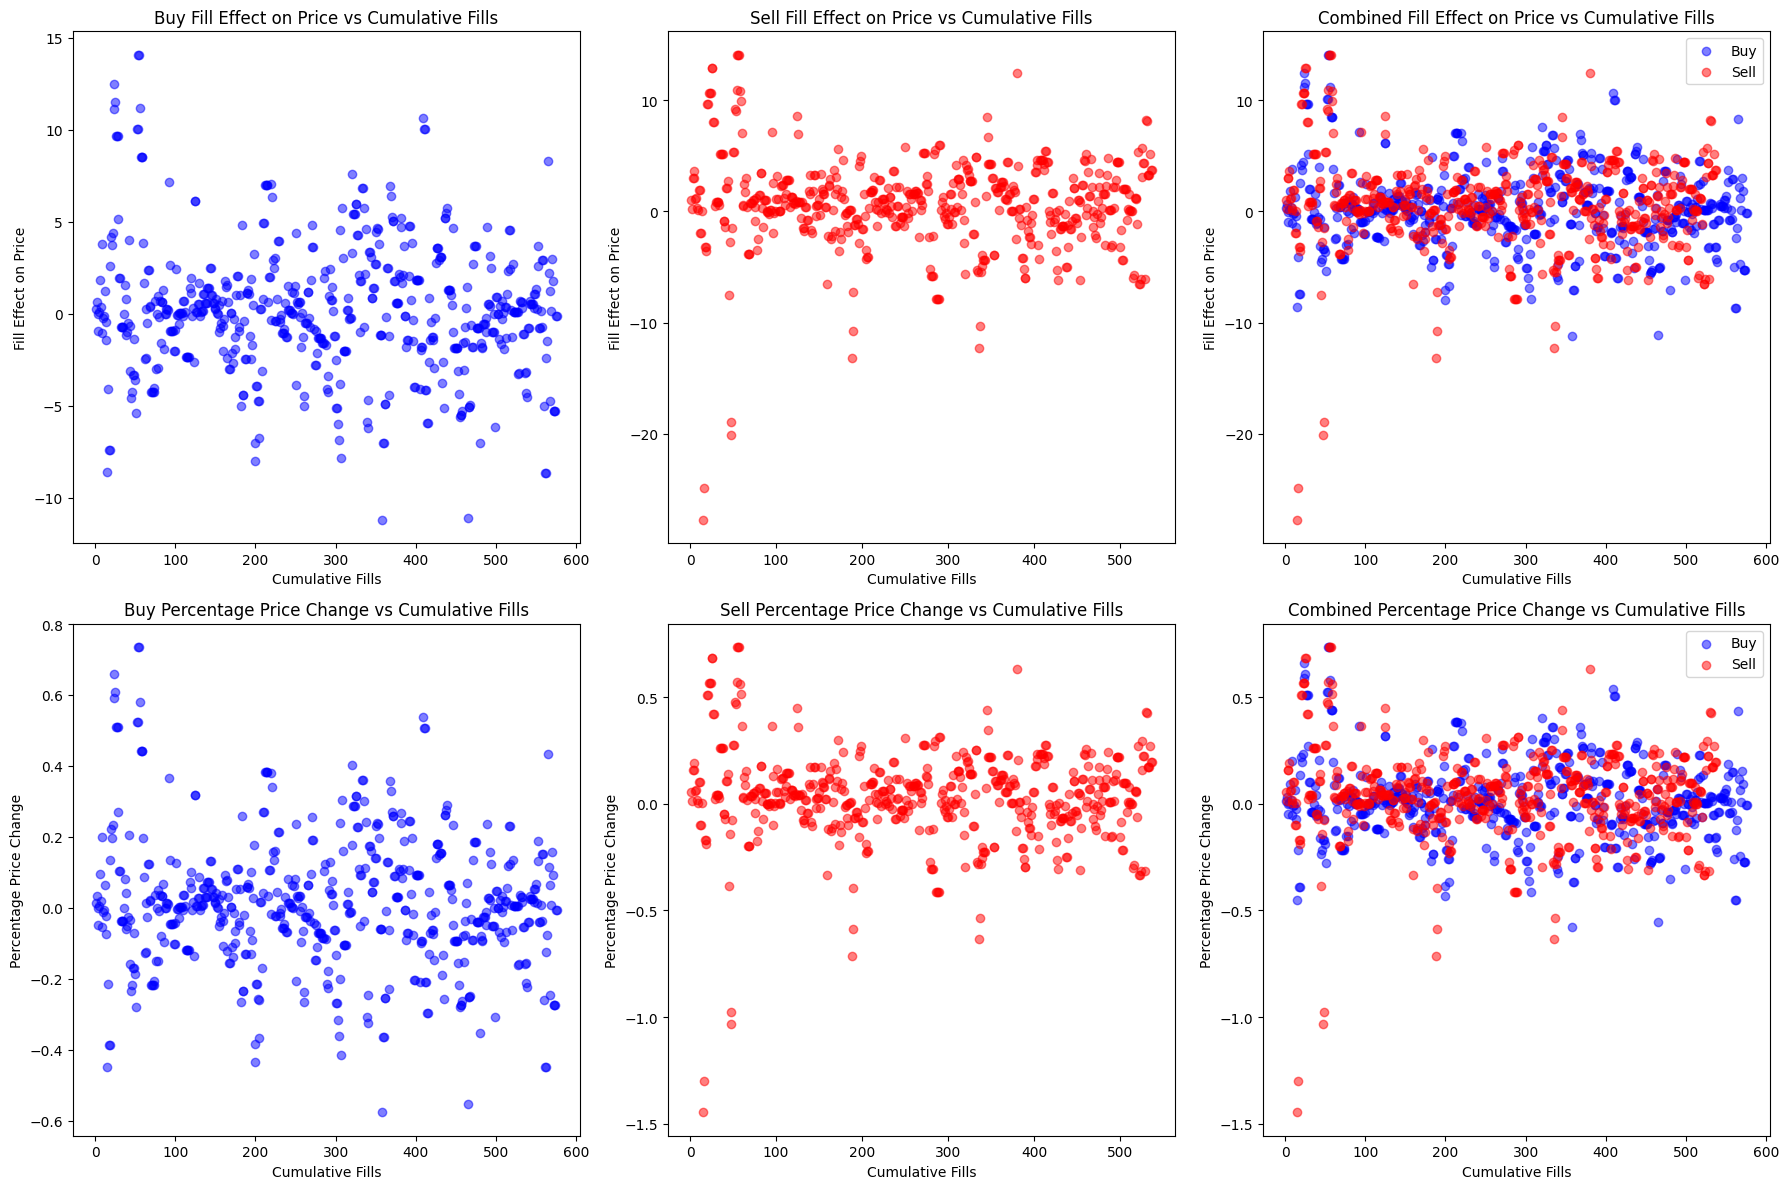

Buys - Pearson Correlation Coefficient: -0.1072, P-value: 1.0028e-02
Sells - Pearson Correlation Coefficient: -0.0578, P-value: 1.8086e-01
Overall - Pearson Correlation Coefficient: -0.0812, P-value: 6.7279e-03
Buys - Fill Effect on Price % - Pearson Correlation Coefficient: -0.1076, P-value: 9.7652e-03
Sells - Fill Effect on Price % - Pearson Correlation Coefficient: -0.0589, P-value: 1.7257e-01
Overall - Fill Effect on Price % - Pearson Correlation Coefficient: -0.0819, P-value: 6.2308e-03


In [132]:
cleaned_df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent', 'fill_qty']) # last few rows do not have an available price change
buys = cleaned_df[cleaned_df['side'] == 'B']
sells = cleaned_df[cleaned_df['side'] == 'S']

buys['cumulative_fills'] = range(1, len(buys) + 1)
sells['cumulative_fills'] = range(1, len(sells) + 1)
cleaned_df['cumulative_fills'] = range(1, len(cleaned_df) + 1)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

axes[0, 0].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0, 0].set_title('Buy Fill Effect on Price vs Cumulative Fills')
axes[0, 0].set_xlabel('Cumulative Fills')
axes[0, 0].set_ylabel('Fill Effect on Price')

axes[0, 1].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[0, 1].set_title('Sell Fill Effect on Price vs Cumulative Fills')
axes[0, 1].set_xlabel('Cumulative Fills')
axes[0, 1].set_ylabel('Fill Effect on Price')

axes[0, 2].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc'], color='blue', alpha=0.5, label='Buy')
axes[0, 2].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc'], color='red', alpha=0.5, label='Sell')
axes[0, 2].set_title('Combined Fill Effect on Price vs Cumulative Fills')
axes[0, 2].set_xlabel('Cumulative Fills')
axes[0, 2].set_ylabel('Fill Effect on Price')
axes[0, 2].legend()

axes[1, 0].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5)
axes[1, 0].set_title('Buy Percentage Price Change vs Cumulative Fills')
axes[1, 0].set_xlabel('Cumulative Fills')
axes[1, 0].set_ylabel('Percentage Price Change')

axes[1, 1].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5)
axes[1, 1].set_title('Sell Percentage Price Change vs Cumulative Fills')
axes[1, 1].set_xlabel('Cumulative Fills')
axes[1, 1].set_ylabel('Percentage Price Change')

axes[1, 2].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5, label='Buy')
axes[1, 2].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5, label='Sell')
axes[1, 2].set_title('Combined Percentage Price Change vs Cumulative Fills')
axes[1, 2].set_xlabel('Cumulative Fills')
axes[1, 2].set_ylabel('Percentage Price Change')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

buy_pearson_corr, buy_pearson_p = pearsonr(buys['cumulative_fills'], buys['fill_effect_on_prc'])
sell_pearson_corr, sell_pearson_p = pearsonr(sells['cumulative_fills'], sells['fill_effect_on_prc'])
overall_pearson_corr, overall_pearson_p = pearsonr(cleaned_df['cumulative_fills'], cleaned_df['fill_effect_on_prc'])
print(f"Buys - Pearson Correlation Coefficient: {buy_pearson_corr:.4f}, P-value: {buy_pearson_p:.4e}")
print(f"Sells - Pearson Correlation Coefficient: {sell_pearson_corr:.4f}, P-value: {sell_pearson_p:.4e}")
print(f"Overall - Pearson Correlation Coefficient: {overall_pearson_corr:.4f}, P-value: {overall_pearson_p:.4e}")
buy_pearson_corr_percent, buy_pearson_p_percent = pearsonr(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'])
sell_pearson_corr_percent, sell_pearson_p_percent = pearsonr(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'])
overall_pearson_corr_percent, overall_pearson_p_percent = pearsonr(cleaned_df['cumulative_fills'], cleaned_df['fill_effect_on_prc_percent'])
print(f"Buys - Fill Effect on Price % - Pearson Correlation Coefficient: {buy_pearson_corr_percent:.4f}, P-value: {buy_pearson_p_percent:.4e}")
print(f"Sells - Fill Effect on Price % - Pearson Correlation Coefficient: {sell_pearson_corr_percent:.4f}, P-value: {sell_pearson_p_percent:.4e}")
print(f"Overall - Fill Effect on Price % - Pearson Correlation Coefficient: {overall_pearson_corr_percent:.4f}, P-value: {overall_pearson_p_percent:.4e}")

Observing the results, we can see that fulfilling orders has a statistically significant relationship with the change in market price in the 1 minute window after a fill occurs, and the percentage change in market prace in the 1 minute window after a fill occurs. Furthermore, the correlation for both is negative with cumulative overall trades, which means that as we fulfill more orders, the change in market price after a trade is fulfilled declines. This doesn't necessarily mean prices are dropping; rather, the magnitude of price changes (whether up or down) becomes smaller. The statistical analyses suggest that after a fill happens, subsequent price movements become less pronounced as more trades are executed. This could indicate that initial fills might correct or exploit price inefficiencies, and as these inefficiencies are addressed, the market becomes more stable and less reactive to new information or trades. Essentially, fills contribute to price discovery, leading to a market where prices more accurately reflect the underlying value, and thus, exhibit smaller fluctuations after each fill, providing a more efficient market.

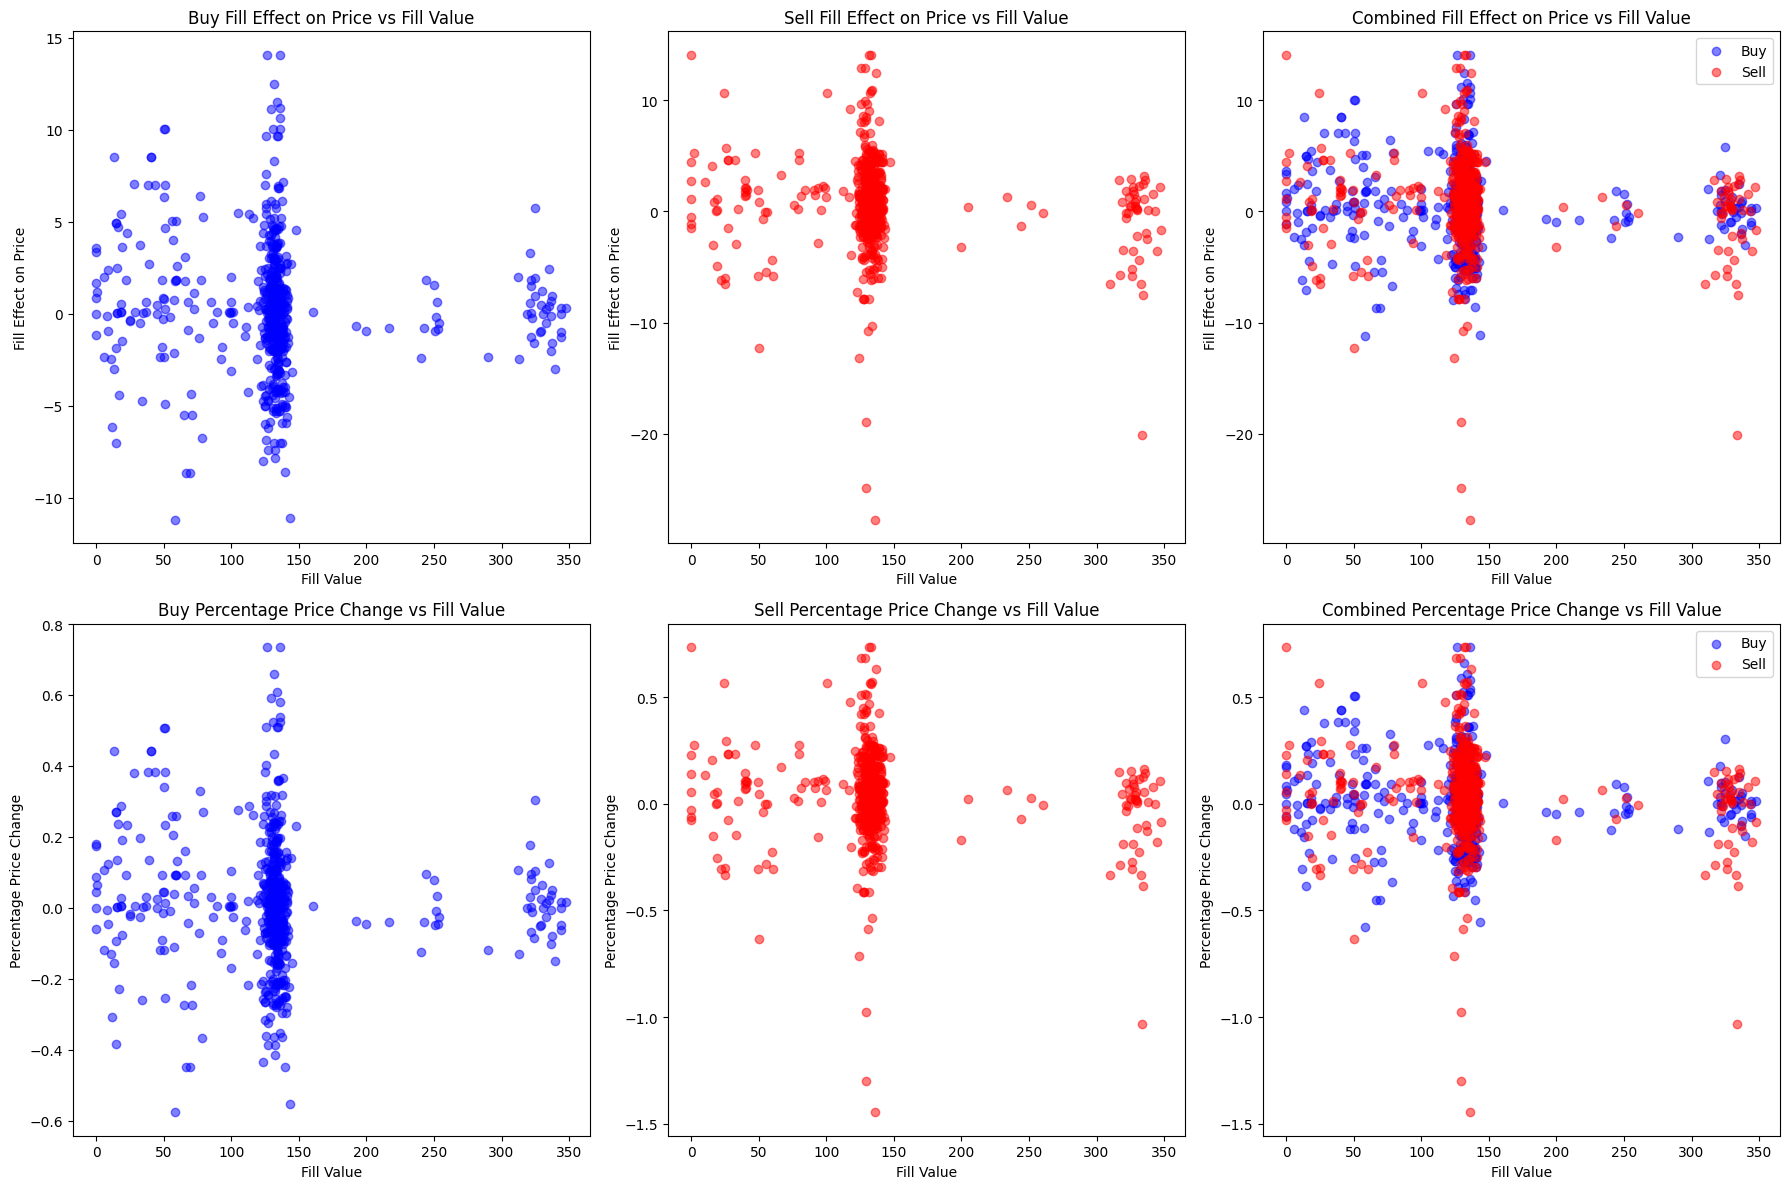

Buys - Fill Effect on Price - Pearson Correlation Coefficient: -0.0630, P-value: 1.3085e-01
Sells - Fill Effect on Price - Pearson Correlation Coefficient: -0.1177, P-value: 6.3188e-03
Overall - Fill Effect on Price - Pearson Correlation Coefficient: -0.0875, P-value: 3.4989e-03
Buys - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: -0.0629, P-value: 1.3156e-01
Sells - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: -0.1172, P-value: 6.5468e-03
Overall - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: -0.0872, P-value: 3.5876e-03


In [136]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

axes[0, 0].scatter(buys['fill_value'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0, 0].set_title('Buy Fill Effect on Price vs Fill Value')
axes[0, 0].set_xlabel('Fill Value')
axes[0, 0].set_ylabel('Fill Effect on Price')

axes[0, 1].scatter(sells['fill_value'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[0, 1].set_title('Sell Fill Effect on Price vs Fill Value')
axes[0, 1].set_xlabel('Fill Value')
axes[0, 1].set_ylabel('Fill Effect on Price')

axes[0, 2].scatter(buys['fill_value'], buys['fill_effect_on_prc'], color='blue', alpha=0.5, label='Buy')
axes[0, 2].scatter(sells['fill_value'], sells['fill_effect_on_prc'], color='red', alpha=0.5, label='Sell')
axes[0, 2].set_title('Combined Fill Effect on Price vs Fill Value')
axes[0, 2].set_xlabel('Fill Value')
axes[0, 2].set_ylabel('Fill Effect on Price')
axes[0, 2].legend()

axes[1, 0].scatter(buys['fill_value'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5)
axes[1, 0].set_title('Buy Percentage Price Change vs Fill Value')
axes[1, 0].set_xlabel('Fill Value')
axes[1, 0].set_ylabel('Percentage Price Change')

axes[1, 1].scatter(sells['fill_value'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5)
axes[1, 1].set_title('Sell Percentage Price Change vs Fill Value')
axes[1, 1].set_xlabel('Fill Value')
axes[1, 1].set_ylabel('Percentage Price Change')

axes[1, 2].scatter(buys['fill_value'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5, label='Buy')
axes[1, 2].scatter(sells['fill_value'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5, label='Sell')
axes[1, 2].set_title('Combined Percentage Price Change vs Fill Value')
axes[1, 2].set_xlabel('Fill Value')
axes[1, 2].set_ylabel('Percentage Price Change')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

buy_pearson_corr, buy_pearson_p = pearsonr(buys['fill_value'], buys['fill_effect_on_prc'])
sell_pearson_corr, sell_pearson_p = pearsonr(sells['fill_value'], sells['fill_effect_on_prc'])
overall_pearson_corr, overall_pearson_p = pearsonr(cleaned_df['fill_value'], cleaned_df['fill_effect_on_prc'])

print(f"Buys - Fill Effect on Price - Pearson Correlation Coefficient: {buy_pearson_corr:.4f}, P-value: {buy_pearson_p:.4e}")
print(f"Sells - Fill Effect on Price - Pearson Correlation Coefficient: {sell_pearson_corr:.4f}, P-value: {sell_pearson_p:.4e}")
print(f"Overall - Fill Effect on Price - Pearson Correlation Coefficient: {overall_pearson_corr:.4f}, P-value: {overall_pearson_p:.4e}")

buy_pearson_corr_percent, buy_pearson_p_percent = pearsonr(buys['fill_value'], buys['fill_effect_on_prc_percent'])
sell_pearson_corr_percent, sell_pearson_p_percent = pearsonr(sells['fill_value'], sells['fill_effect_on_prc_percent'])
overall_pearson_corr_percent, overall_pearson_p_percent = pearsonr(cleaned_df['fill_value'], cleaned_df['fill_effect_on_prc_percent'])

print(f"Buys - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {buy_pearson_corr_percent:.4f}, P-value: {buy_pearson_p_percent:.4e}")
print(f"Sells - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {sell_pearson_corr_percent:.4f}, P-value: {sell_pearson_p_percent:.4e}")
print(f"Overall - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {overall_pearson_corr_percent:.4f}, P-value: {overall_pearson_p_percent:.4e}")

Exploring further, we can also see that the value of the orders fulfilled also has a statistically significant relationship with the percentage change on market price in the 1 minute window price change after the fill occurs. Furthermore, the correlations for buys, sells, and overall orders are negative, which means that as the value of the orders fulfilled increases, this percentage declines. One interpretation of this result is that as the value of a fill increases, the immediate impact on market price tends to decrease slightly. This might suggest a form of market efficiency where larger trades, possibly anticipated or better absorbed by the market, lead to less price volatility immediately after the trade. However, the correlation coefficients are close to zero, indicating that while the trend is consistent and statistically significant, the strength of this relationship is weak.

### Investigating Price Impact of Fills by Trade

In this section, I want to investigate the direction of the price change that occurs after a buy order is fulfilled and after a sell order is fulfilled. This will provide further insight into my previous analysis.


In [ ]:
df = merged_data.copy()
df['fill_effect_on_prc'] = fill_effects
buys = cleaned_df[cleaned_df['side'] == 'B']
sells = cleaned_df[cleaned_df['side'] == 'S']


In [ ]:
mean_buy_price_change = estimate_sample_mean(buys, 'fill_effect_on_prc')
mean_sell_price_change = estimate_sample_mean(sells, 'fill_effect_on_prc')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for buys
axes[0].hist(buys['fill_effect_on_prc'], bins=50, alpha=0.7, color='blue', label='Buy')
axes[0].axvline(mean_buy_price_change, color='k', linestyle='dashed', linewidth=1)
axes[0].set_title('Distribution of Price Change After Buy Orders')
axes[0].set_xlabel('Price Change')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram for sells
axes[1].hist(sells['fill_effect_on_prc'], bins=50, alpha=0.7, color='red', label='Sell')
axes[1].axvline(mean_sell_price_change, color='k', linestyle='dashed', linewidth=1)
axes[1].set_title('Distribution of Price Change After Sell Orders')
axes[1].set_xlabel('Price Change')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
cleaned_df = df.dropna(subset=['fill_effect_on_prc', 'fill_qty']) # last few rows do not have an available price change
buys = cleaned_df[cleaned_df['side'] == 'B']
sells = cleaned_df[cleaned_df['side'] == 'S']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Buys
axes[0].scatter(buys['fill_qty'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0].set_title('Buy Fill Effect on Price vs Fill Quantity')
axes[0].set_xlabel('Fill Quantity')
axes[0].set_ylabel('Fill Effect on Price')

# Sells
axes[1].scatter(sells['fill_qty'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[1].set_title('Sell Fill Effect on Price vs Fill Quantity')
axes[1].set_xlabel('Fill Quantity')
axes[1].set_ylabel('Fill Effect on Price')

# Overlapped
axes[2].scatter(buys['fill_qty'], buys['fill_effect_on_prc'], color='blue', alpha=0.5, label='Buy')
axes[2].scatter(sells['fill_qty'], sells['fill_effect_on_prc'], color='red', alpha=0.5, label='Sell')
axes[2].set_title('Combined Fill Effect on Price vs Fill Quantity')
axes[2].set_xlabel('Fill Quantity')
axes[2].set_ylabel('Fill Effect on Price')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Pearson correlation for buying
buy_pearson_corr, buy_p_value = pearsonr(buys['fill_qty'], buys['fill_effect_on_prc'])
print(f"Buying Pearson Correlation Coefficient: {buy_pearson_corr:.4f}, P-value: {buy_p_value:.4e}")


# Pearson correlation for selling
sell_pearson_corr, sell_p_value = pearsonr(sells['fill_qty'], sells['fill_effect_on_prc'])
print(f"Selling Pearson Correlation Coefficient: {sell_pearson_corr:.4f}, P-value: {sell_p_value:.4e}")


overall_pearson_corr, overall_pearson_p = pearsonr(cleaned_df['fill_qty'], cleaned_df['fill_effect_on_prc'])

print("Overall (No Outliers):")
print(f"Pearson Correlation Coefficient: {overall_pearson_corr:.4f}, P-value: {overall_pearson_p:.4e}")


### Fill Price vs. Bid/Ask Price Difference

In this section, I want to investigate the relationship between the fill price and the bid/ask price the trade was executed at. I will calculate the difference between the fill price and the bid/ask price and then plot the difference against the fill price.

In [ ]:
df['price_difference'] = df.apply(
    lambda row: row['fill_prc'] - row['ask_prc'] if row['side'] == 'B' else row['fill_prc'] - row['bid_prc'], axis=1)

df['price_difference'].plot(title='Price Difference of Trades', figsize=(10, 6))

In [ ]:
df['price_difference'] = df.apply(
    lambda row: row['fill_prc'] - row['ask_prc'] if row['side'] == 'B' else row['fill_prc'] - row['bid_prc'], axis=1)

plt.figure(figsize=(10, 6))

# Buy orders
buy_df = df[df['side'] == 'B']
plt.scatter(buy_df['fill_prc'], buy_df['price_difference'], color='blue', alpha=0.5, label='Buy')
# Sell orders
sell_df = df[df['side'] == 'S']
plt.scatter(sell_df['fill_prc'], sell_df['price_difference'], color='red', alpha=0.5, label='Sell')

plt.title = 'Post-Fill Price Difference vs. Fill Price'
plt.xlabel = 'Fill Price'
plt.ylabel = 'Price Difference (Fill Price - Ask/Bid Price'

plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mean_post_fill_price_difference = estimate_sample_mean(df, 'price_difference')
buys_above_mean_post_fill_price_difference = buy_df[buy_df['price_difference'] > mean_post_fill_price_difference].shape[0]
sells_above_mean_post_fill_price_difference = sell_df[sell_df['price_difference'] > mean_post_fill_price_difference].shape[0]
buys_below_mean_post_fill_price_difference = buy_df[buy_df['price_difference'] < mean_post_fill_price_difference].shape[0]
sells_below_mean_post_fill_price_difference = sell_df[sell_df['price_difference'] < mean_post_fill_price_difference].shape[0]

print(f"Total trades above mean_post_fill_price_difference: {buys_above_mean_post_fill_price_difference + sells_above_mean_post_fill_price_difference}, Total trades below mean_post_fill_price_difference: {buys_below_mean_post_fill_price_difference + sells_below_mean_post_fill_price_difference}")
print(f"Buys above mean_post_fill_price_difference: {buys_above_mean_post_fill_price_difference}, Sells above mean_post_fill_price_difference: {sells_above_mean_post_fill_price_difference}")
print(f"Buys below mean_post_fill_price_difference: {buys_below_mean_post_fill_price_difference}, Sells below mean_post_fill_price_difference: {sells_below_mean_post_fill_price_difference}")

The plot shows that price fills typically happen close to the current market price. The points above and below the zero line indicate situations where the fill price was higher or lower than the bid or ask price, respectively.

Furthermore, when we compare the points above and below the mean post-fill price difference, we can see that more trading happens when the post-fill price difference is below the mean. In this region, this means that buyers are buying at a lower price than the current market price, and sellers are selling at a higher price than the current market price. This is a good sign as it means that there is more liquidity in the market, traers are getting a better deal, and market participants to get prices closer to their preferred bid/ask levels. In this region, there are predominantly more buy orders than sell orders, telling us that more buyers are active in this scenario to take advantage to better prices.

On the other hand, in the region above the mean fill-price difference, there are much more sell orders happening than buy orders. This region means that buyers may be paying more than the average asking price, or sellers are receiving less than the average bid price. 


In [ ]:
std_dev = df['price_difference'].std()

upper_bound = mean_post_fill_price_difference + 2 * std_dev
lower_bound = mean_post_fill_price_difference - 2 * std_dev

buy_outliers_above = df[(df['side'] == 'B') & (df['price_difference'] > upper_bound)]
buy_outliers_below = df[(df['side'] == 'B') & (df['price_difference'] < lower_bound)]

sell_outliers_above = df[(df['side'] == 'S') & (df['price_difference'] > upper_bound)]
sell_outliers_below = df[(df['side'] == 'S') & (df['price_difference'] < lower_bound)]

outliers = df[(df['price_difference'] > mean_post_fill_price_difference + upper_bound) | (df['price_difference'] < mean_post_fill_price_difference - lower_bound)]
print(f"Buy Outliers Above Mean: {buy_outliers_above.shape[0]}")
print(f"Buy Outliers Below Mean: {buy_outliers_below.shape[0]}")
print(f"Sell Outliers Above Mean: {sell_outliers_above.shape[0]}")
print(f"Sell Outliers Below Mean: {sell_outliers_below.shape[0]}")

chi2, p, dof, expected = stats.chi2_contingency([[buy_outliers_above.shape[0], sell_outliers_above.shape[0]], [buy_outliers_below.shape[0], sell_outliers_below.shape[0]]])
print(f"Chi-squared: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected counts:")
print(expected)

outliers

Looking at the results of the outliers table, the Chi-squared test tells us the results are not random. The more sell orders when the post-fill price difference is greater than the mean is indicative of a market crash and when traders want to quickly sell their stock, even at less favourable prices. On the other hand, we see than when the market is tstable, more buying activity occurs than selling. This is a good sign as it means that the market is healthy and there is more liquidity in the market.